## Load data and EDA

In [5]:
# !pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [1]:
import pandas as pd

In [2]:
import pandas as pd

df = pd.read_excel(io='CRA_train_1200.xlsx',
                    engine='openpyxl')
df.head()

Id                                             pr_txt Категория  \
0   1  Повышение кредитного рейтинга  Акционерного об...         A   
1   2  «Эксперт РА» подтвердил кредитный рейтинг комп...        BB   
2   3  НКР повысило кредитный рейтинг ООО "ОТЭКО-Порт...         A   
3   4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...       AAA   
4   5  29 марта 2023 г. Ведущий рейтинговый аналитик ...       BBB   

  Уровень рейтинга  
0                A  
1               BB  
2                A  
3              AAA  
4              BBB

### EDA

In [ ]:
# !pip install wordcloud
# !pip install spacy

In [4]:
# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
# from nltk.corpus import stopwords
# russian_stopwords = stopwords.words("russian")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
# !pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('russian'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /home/yagor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yagor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yagor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/yagor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
n = len(df)
trainv, testv = df.iloc[int(n*0.2):], df.iloc[:int(n*0.2)]

In [5]:
display(trainv.sample(5))
display(testv.sample(5))

Id                                             pr_txt Категория  \
1076  1088  АКРА подтвердило кредитный рейтинг Акционерног...        AA   
717    720  Кредитный рейтинг  ПАО «Россети Ленэнерго»  (д...       AAA   
590    591  «Эксперт РА» присвоил рейтинг компании «Уральс...         A   
1133  1145  АКРА подтвердило кредитный рейтинг АО «Концерн...         A   
1163  1175  «Эксперт РА» подтвердил рейтинг компании ТВСЗ ...        BB   

     Уровень рейтинга  
1076              AA+  
717               AAA  
590                A-  
1133                A  
1163               BB

Id                                             pr_txt Категория  \
166  167  НРА подтвердило кредитный рейтинг ПАО «ИНГРАД»...       BBB   
205  206  Кредитный рейтинг  ООО «Группа Астон»  (далее ...        BB   
78    79  Подтверждение кредитного рейтинга  EVRAZ plc  ...       AAA   
212  213  «Эксперт РА» подтвердил кредитный рейтинг АО «...       BBB   
74    75  «Эксперт РА» пересмотрел кредитный рейтинг АО ...       AAA   

    Уровень рейтинга  
166             BBB+  
205              BB+  
78               AAA  
212              BBB  
74               AAA

In [6]:
print(trainv.shape)
print(testv.shape)

(960, 4)
(240, 4)


In [7]:
df.rename(columns={"pr_txt": "text", "Категория": "label"}, errors="raise", inplace=True)

In [9]:
df.head()

Id                                               text label  \
0   1  Повышение кредитного рейтинга  Акционерного об...     A   
1   2  «Эксперт РА» подтвердил кредитный рейтинг комп...    BB   
2   3  НКР повысило кредитный рейтинг ООО "ОТЭКО-Порт...     A   
3   4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   AAA   
4   5  29 марта 2023 г. Ведущий рейтинговый аналитик ...   BBB   

  Уровень рейтинга  
0                A  
1               BB  
2                A  
3              AAA  
4              BBB

In [10]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

df['text_clean'] = df['text'].apply(lambda x: remove_URL(x))
# trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_emoji(x))
# trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))

In [11]:
df['tokenized'] = df['text_clean'].apply(word_tokenize)

df.head()

Id                                               text label  \
0   1  Повышение кредитного рейтинга  Акционерного об...     A   
1   2  «Эксперт РА» подтвердил кредитный рейтинг комп...    BB   
2   3  НКР повысило кредитный рейтинг ООО "ОТЭКО-Порт...     A   
3   4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   AAA   
4   5  29 марта 2023 г. Ведущий рейтинговый аналитик ...   BBB   

  Уровень рейтинга                                         text_clean  \
0                A  Повышение кредитного рейтинга  Акционерного об...   
1               BB  «Эксперт РА» подтвердил кредитный рейтинг комп...   
2                A  НКР повысило кредитный рейтинг ООО ОТЭКОПортсе...   
3              AAA  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   
4              BBB  29 марта 2023 г Ведущий рейтинговый аналитик Ю...   

                                           tokenized  
0  [Повышение, кредитного, рейтинга, Акционерного...  
1  [«, Эксперт, РА, », подтвердил, кредитный, рей...  
2  [НКР, повысило, кредитный, рейтинг, ООО, ОТЭКО...  
3  [«, Эксперт, РА, », присвоил, кредитный, рейти...  
4  [29, марта, 2023, г, Ведущий, рейтинговый, ана...

In [13]:
df['lower'] = df['tokenized'].apply(
    lambda x: [word.lower() for word in x])

df.head()

Id                                               text label  \
0   1  Повышение кредитного рейтинга  Акционерного об...     A   
1   2  «Эксперт РА» подтвердил кредитный рейтинг комп...    BB   
2   3  НКР повысило кредитный рейтинг ООО "ОТЭКО-Порт...     A   
3   4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   AAA   
4   5  29 марта 2023 г. Ведущий рейтинговый аналитик ...   BBB   

  Уровень рейтинга                                         text_clean  \
0                A  Повышение кредитного рейтинга  Акционерного об...   
1               BB  «Эксперт РА» подтвердил кредитный рейтинг комп...   
2                A  НКР повысило кредитный рейтинг ООО ОТЭКОПортсе...   
3              AAA  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   
4              BBB  29 марта 2023 г Ведущий рейтинговый аналитик Ю...   

                                           tokenized  \
0  [Повышение, кредитного, рейтинга, Акционерного...   
1  [«, Эксперт, РА, », подтвердил, кредитный, рей...   
2  [НКР, повысило, кредитный, рейтинг, ООО, ОТЭКО...   
3  [«, Эксперт, РА, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, Ведущий, рейтинговый, ана...   

                                               lower  
0  [повышение, кредитного, рейтинга, акционерного...  
1  [«, эксперт, ра, », подтвердил, кредитный, рей...  
2  [нкр, повысило, кредитный, рейтинг, ооо, отэко...  
3  [«, эксперт, ра, », присвоил, кредитный, рейти...  
4  [29, марта, 2023, г, ведущий, рейтинговый, ана...

In [14]:
df['stopwords_removed'] = df['lower'].apply(
    lambda x: [word for word in x if word not in stop])

df.head()

Id                                               text label  \
0   1  Повышение кредитного рейтинга  Акционерного об...     A   
1   2  «Эксперт РА» подтвердил кредитный рейтинг комп...    BB   
2   3  НКР повысило кредитный рейтинг ООО "ОТЭКО-Порт...     A   
3   4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   AAA   
4   5  29 марта 2023 г. Ведущий рейтинговый аналитик ...   BBB   

  Уровень рейтинга                                         text_clean  \
0                A  Повышение кредитного рейтинга  Акционерного об...   
1               BB  «Эксперт РА» подтвердил кредитный рейтинг комп...   
2                A  НКР повысило кредитный рейтинг ООО ОТЭКОПортсе...   
3              AAA  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   
4              BBB  29 марта 2023 г Ведущий рейтинговый аналитик Ю...   

                                           tokenized  \
0  [Повышение, кредитного, рейтинга, Акционерного...   
1  [«, Эксперт, РА, », подтвердил, кредитный, рей...   
2  [НКР, повысило, кредитный, рейтинг, ООО, ОТЭКО...   
3  [«, Эксперт, РА, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, Ведущий, рейтинговый, ана...   

                                               lower  \
0  [повышение, кредитного, рейтинга, акционерного...   
1  [«, эксперт, ра, », подтвердил, кредитный, рей...   
2  [нкр, повысило, кредитный, рейтинг, ооо, отэко...   
3  [«, эксперт, ра, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, ведущий, рейтинговый, ана...   

                                   stopwords_removed  
0  [повышение, кредитного, рейтинга, акционерного...  
1  [«, эксперт, ра, », подтвердил, кредитный, рей...  
2  [нкр, повысило, кредитный, рейтинг, ооо, отэко...  
3  [«, эксперт, ра, », присвоил, кредитный, рейти...  
4  [29, марта, 2023, г, ведущий, рейтинговый, ана...

In [15]:
# Applying part of speech tags.

df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)

df.head()

Id                                               text label  \
0   1  Повышение кредитного рейтинга  Акционерного об...     A   
1   2  «Эксперт РА» подтвердил кредитный рейтинг комп...    BB   
2   3  НКР повысило кредитный рейтинг ООО "ОТЭКО-Порт...     A   
3   4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   AAA   
4   5  29 марта 2023 г. Ведущий рейтинговый аналитик ...   BBB   

  Уровень рейтинга                                         text_clean  \
0                A  Повышение кредитного рейтинга  Акционерного об...   
1               BB  «Эксперт РА» подтвердил кредитный рейтинг комп...   
2                A  НКР повысило кредитный рейтинг ООО ОТЭКОПортсе...   
3              AAA  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   
4              BBB  29 марта 2023 г Ведущий рейтинговый аналитик Ю...   

                                           tokenized  \
0  [Повышение, кредитного, рейтинга, Акционерного...   
1  [«, Эксперт, РА, », подтвердил, кредитный, рей...   
2  [НКР, повысило, кредитный, рейтинг, ООО, ОТЭКО...   
3  [«, Эксперт, РА, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, Ведущий, рейтинговый, ана...   

                                               lower  \
0  [повышение, кредитного, рейтинга, акционерного...   
1  [«, эксперт, ра, », подтвердил, кредитный, рей...   
2  [нкр, повысило, кредитный, рейтинг, ооо, отэко...   
3  [«, эксперт, ра, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, ведущий, рейтинговый, ана...   

                                   stopwords_removed  \
0  [повышение, кредитного, рейтинга, акционерного...   
1  [«, эксперт, ра, », подтвердил, кредитный, рей...   
2  [нкр, повысило, кредитный, рейтинг, ооо, отэко...   
3  [«, эксперт, ра, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, ведущий, рейтинговый, ана...   

                                            pos_tags  
0  [(повышение, JJ), (кредитного, NNP), (рейтинга...  
1  [(«, JJ), (эксперт, NNP), (ра, NNP), (», NNP),...  
2  [(нкр, JJ), (повысило, NNP), (кредитный, NNP),...  
3  [(«, JJ), (эксперт, NNP), (ра, NNP), (», NNP),...  
4  [(29, CD), (марта, JJ), (2023, CD), (г, NNP), ...

In [16]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


df['wordnet_pos'] = df['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

df.head()

Id                                               text label  \
0   1  Повышение кредитного рейтинга  Акционерного об...     A   
1   2  «Эксперт РА» подтвердил кредитный рейтинг комп...    BB   
2   3  НКР повысило кредитный рейтинг ООО "ОТЭКО-Порт...     A   
3   4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   AAA   
4   5  29 марта 2023 г. Ведущий рейтинговый аналитик ...   BBB   

  Уровень рейтинга                                         text_clean  \
0                A  Повышение кредитного рейтинга  Акционерного об...   
1               BB  «Эксперт РА» подтвердил кредитный рейтинг комп...   
2                A  НКР повысило кредитный рейтинг ООО ОТЭКОПортсе...   
3              AAA  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   
4              BBB  29 марта 2023 г Ведущий рейтинговый аналитик Ю...   

                                           tokenized  \
0  [Повышение, кредитного, рейтинга, Акционерного...   
1  [«, Эксперт, РА, », подтвердил, кредитный, рей...   
2  [НКР, повысило, кредитный, рейтинг, ООО, ОТЭКО...   
3  [«, Эксперт, РА, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, Ведущий, рейтинговый, ана...   

                                               lower  \
0  [повышение, кредитного, рейтинга, акционерного...   
1  [«, эксперт, ра, », подтвердил, кредитный, рей...   
2  [нкр, повысило, кредитный, рейтинг, ооо, отэко...   
3  [«, эксперт, ра, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, ведущий, рейтинговый, ана...   

                                   stopwords_removed  \
0  [повышение, кредитного, рейтинга, акционерного...   
1  [«, эксперт, ра, », подтвердил, кредитный, рей...   
2  [нкр, повысило, кредитный, рейтинг, ооо, отэко...   
3  [«, эксперт, ра, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, ведущий, рейтинговый, ана...   

                                            pos_tags  \
0  [(повышение, JJ), (кредитного, NNP), (рейтинга...   
1  [(«, JJ), (эксперт, NNP), (ра, NNP), (», NNP),...   
2  [(нкр, JJ), (повысило, NNP), (кредитный, NNP),...   
3  [(«, JJ), (эксперт, NNP), (ра, NNP), (», NNP),...   
4  [(29, CD), (марта, JJ), (2023, CD), (г, NNP), ...   

                                         wordnet_pos  
0  [(повышение, a), (кредитного, n), (рейтинга, n...  
1  [(«, a), (эксперт, n), (ра, n), (», n), (подтв...  
2  [(нкр, a), (повысило, n), (кредитный, n), (рей...  
3  [(«, a), (эксперт, n), (ра, n), (», n), (присв...  
4  [(29, n), (марта, a), (2023, n), (г, n), (веду...

In [17]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

df['lemmatized'] = df['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

df['lemmatized'] = df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]

df.head()

Id                                               text label  \
0   1  Повышение кредитного рейтинга  Акционерного об...     A   
1   2  «Эксперт РА» подтвердил кредитный рейтинг комп...    BB   
2   3  НКР повысило кредитный рейтинг ООО "ОТЭКО-Порт...     A   
3   4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   AAA   
4   5  29 марта 2023 г. Ведущий рейтинговый аналитик ...   BBB   

  Уровень рейтинга                                         text_clean  \
0                A  Повышение кредитного рейтинга  Акционерного об...   
1               BB  «Эксперт РА» подтвердил кредитный рейтинг комп...   
2                A  НКР повысило кредитный рейтинг ООО ОТЭКОПортсе...   
3              AAA  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...   
4              BBB  29 марта 2023 г Ведущий рейтинговый аналитик Ю...   

                                           tokenized  \
0  [Повышение, кредитного, рейтинга, Акционерного...   
1  [«, Эксперт, РА, », подтвердил, кредитный, рей...   
2  [НКР, повысило, кредитный, рейтинг, ООО, ОТЭКО...   
3  [«, Эксперт, РА, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, Ведущий, рейтинговый, ана...   

                                               lower  \
0  [повышение, кредитного, рейтинга, акционерного...   
1  [«, эксперт, ра, », подтвердил, кредитный, рей...   
2  [нкр, повысило, кредитный, рейтинг, ооо, отэко...   
3  [«, эксперт, ра, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, ведущий, рейтинговый, ана...   

                                   stopwords_removed  \
0  [повышение, кредитного, рейтинга, акционерного...   
1  [«, эксперт, ра, », подтвердил, кредитный, рей...   
2  [нкр, повысило, кредитный, рейтинг, ооо, отэко...   
3  [«, эксперт, ра, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, ведущий, рейтинговый, ана...   

                                            pos_tags  \
0  [(повышение, JJ), (кредитного, NNP), (рейтинга...   
1  [(«, JJ), (эксперт, NNP), (ра, NNP), (», NNP),...   
2  [(нкр, JJ), (повысило, NNP), (кредитный, NNP),...   
3  [(«, JJ), (эксперт, NNP), (ра, NNP), (», NNP),...   
4  [(29, CD), (марта, JJ), (2023, CD), (г, NNP), ...   

                                         wordnet_pos  \
0  [(повышение, a), (кредитного, n), (рейтинга, n...   
1  [(«, a), (эксперт, n), (ра, n), (», n), (подтв...   
2  [(нкр, a), (повысило, n), (кредитный, n), (рей...   
3  [(«, a), (эксперт, n), (ра, n), (», n), (присв...   
4  [(29, n), (марта, a), (2023, n), (г, n), (веду...   

                                          lemmatized  \
0  [повышение, кредитного, рейтинга, акционерного...   
1  [«, эксперт, ра, », подтвердил, кредитный, рей...   
2  [нкр, повысило, кредитный, рейтинг, ооо, отэко...   
3  [«, эксперт, ра, », присвоил, кредитный, рейти...   
4  [29, марта, 2023, г, ведущий, рейтинговый, ана...   

                                           lemma_str  
0  повышение кредитного рейтинга акционерного общ...  
1  « эксперт ра » подтвердил кредитный рейтинг ко...  
2  нкр повысило кредитный рейтинг ооо отэкопортсе...  
3  « эксперт ра » присвоил кредитный рейтинг пао ...  
4  29 марта 2023 г ведущий рейтинговый аналитик ю...

In [19]:
labs = np.unique(df['label'].values)
labs

array(['A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C'], dtype=object)

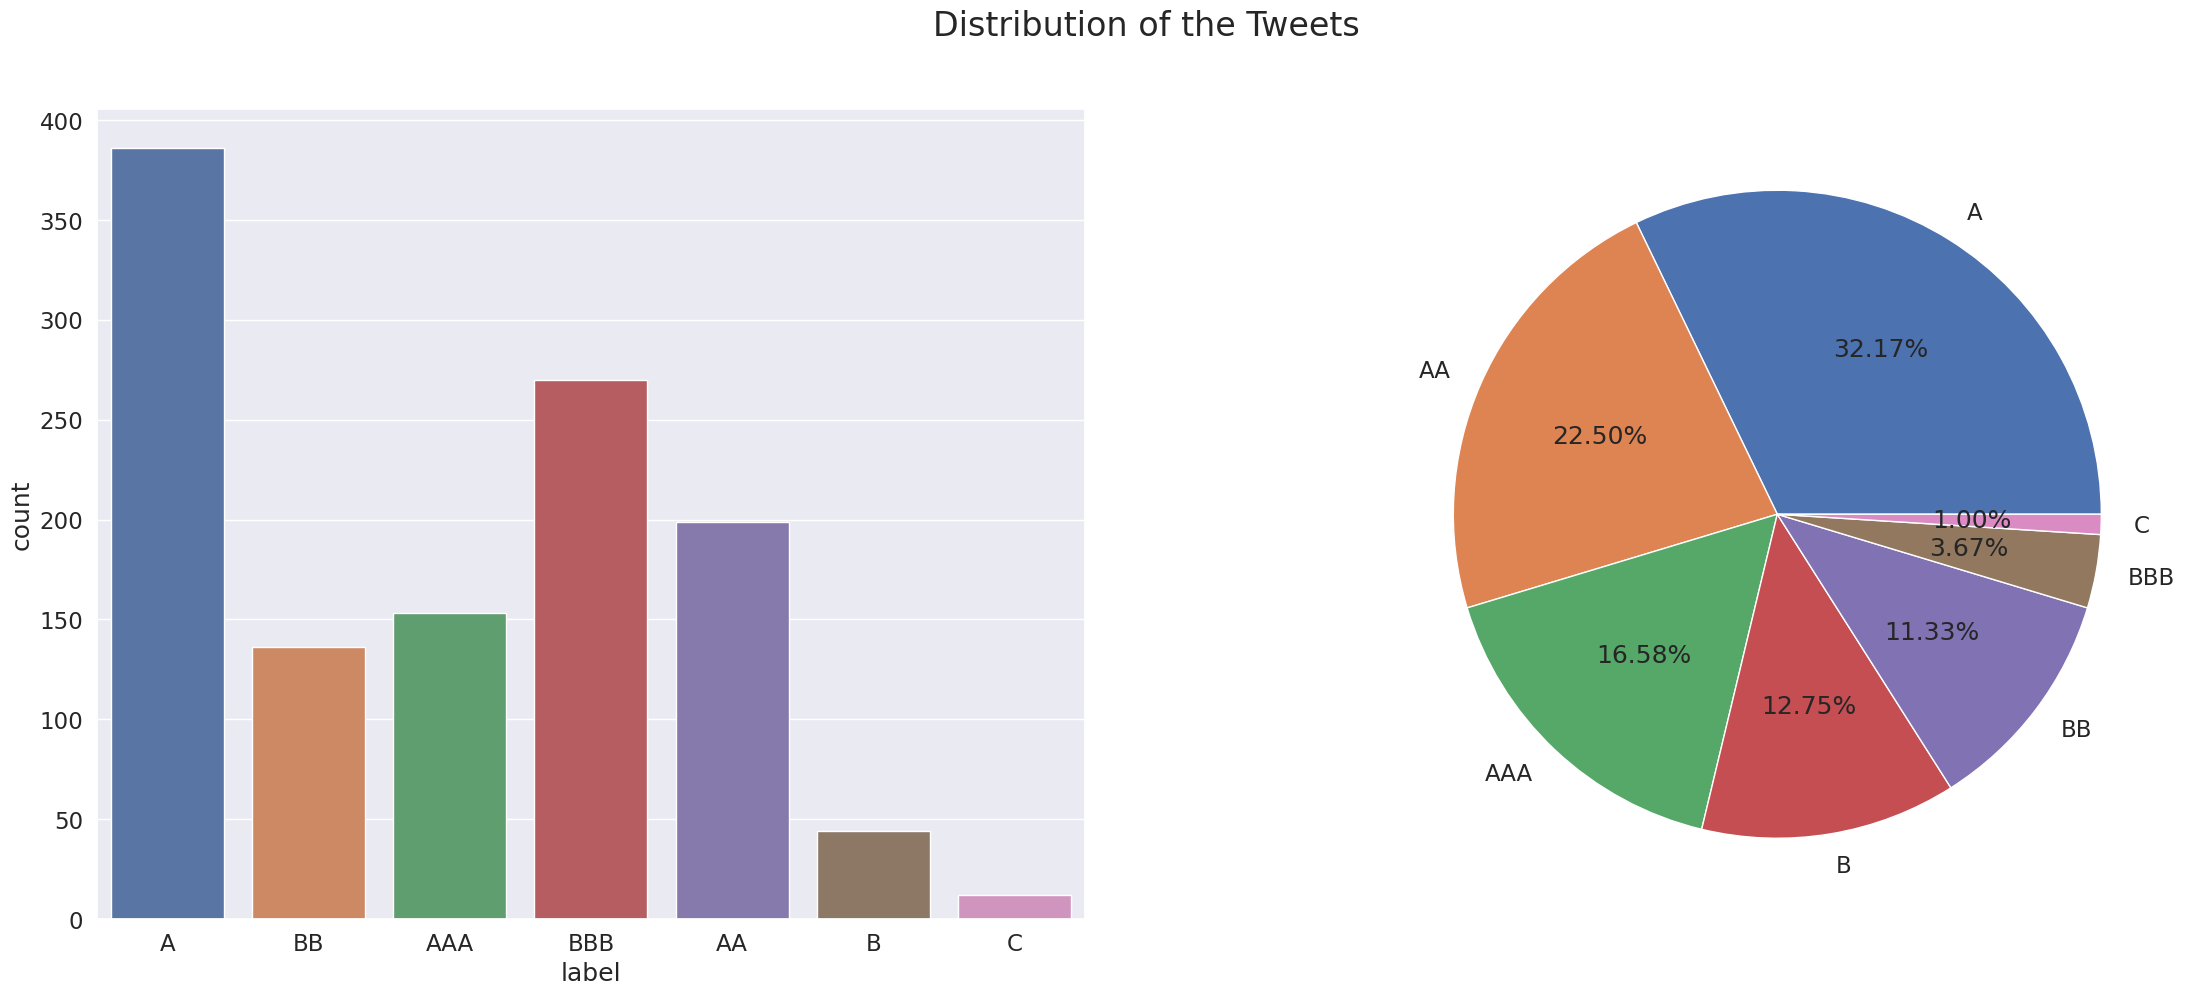

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 10), dpi=100)
sns.countplot(x=df['label'], ax=axes[0])
axes[1].pie(x=df['label'].value_counts(),
            labels=labs,
            autopct='%1.2f%%',)
            #shadow=True,
            #explode=None,#(0.05, 0)
            #startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

<a id="Tweet_Lengths"></a>
## Tweet Lengths

#### Let's start with the number of characters per tweet and compare if it's disaster related or not. It seems disaster tweets are longer than non disaster tweets in general. We can assume longer tweets are more likely for disasters but this is only an assumption and might be not true...

### [Back To Table of Contents](#top_section)

In [21]:
# Creating a new feature for the visualization.

df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(25, 10))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

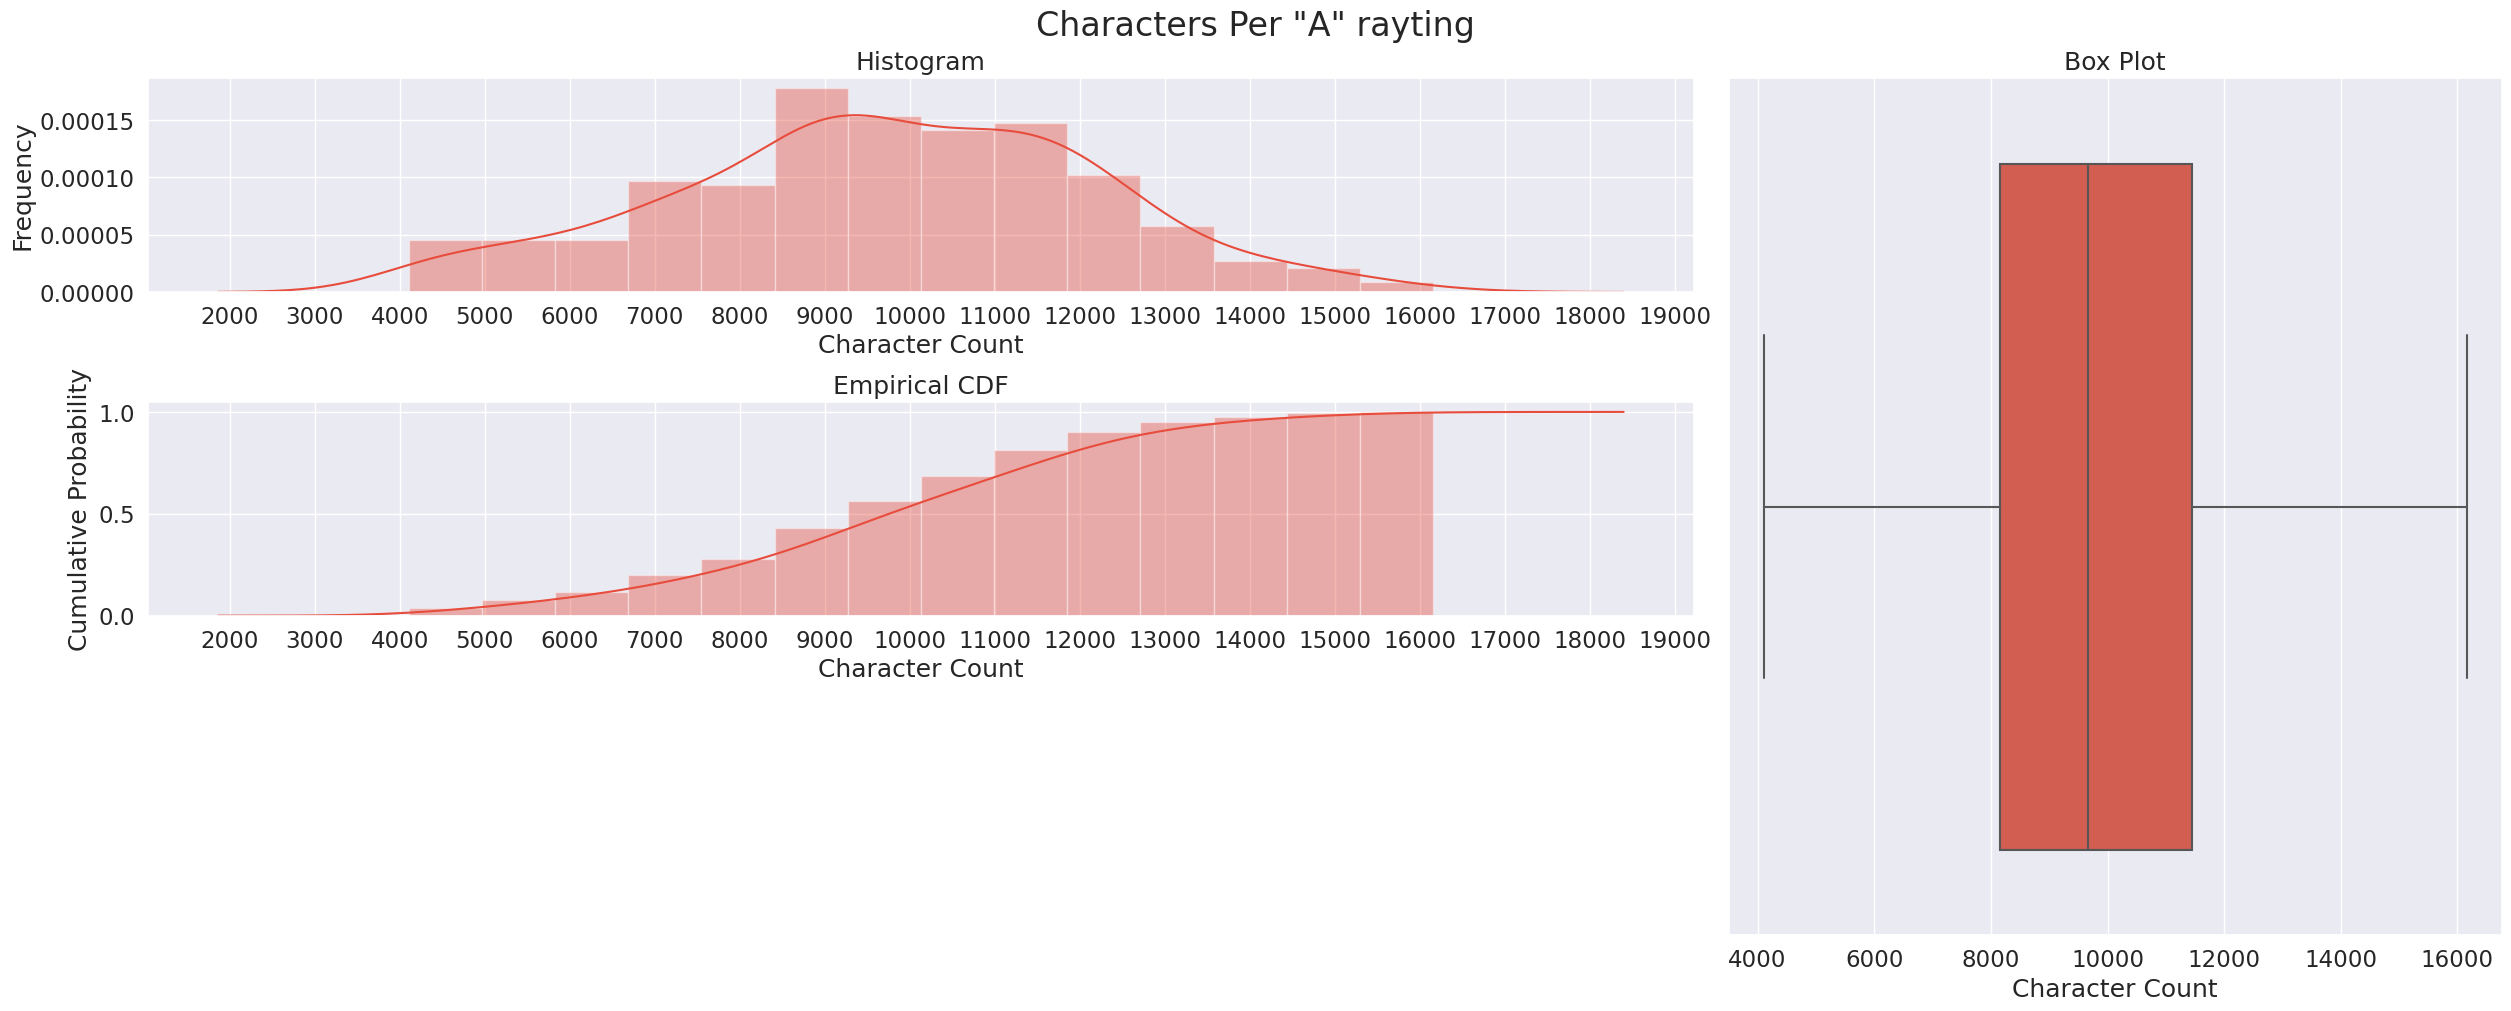

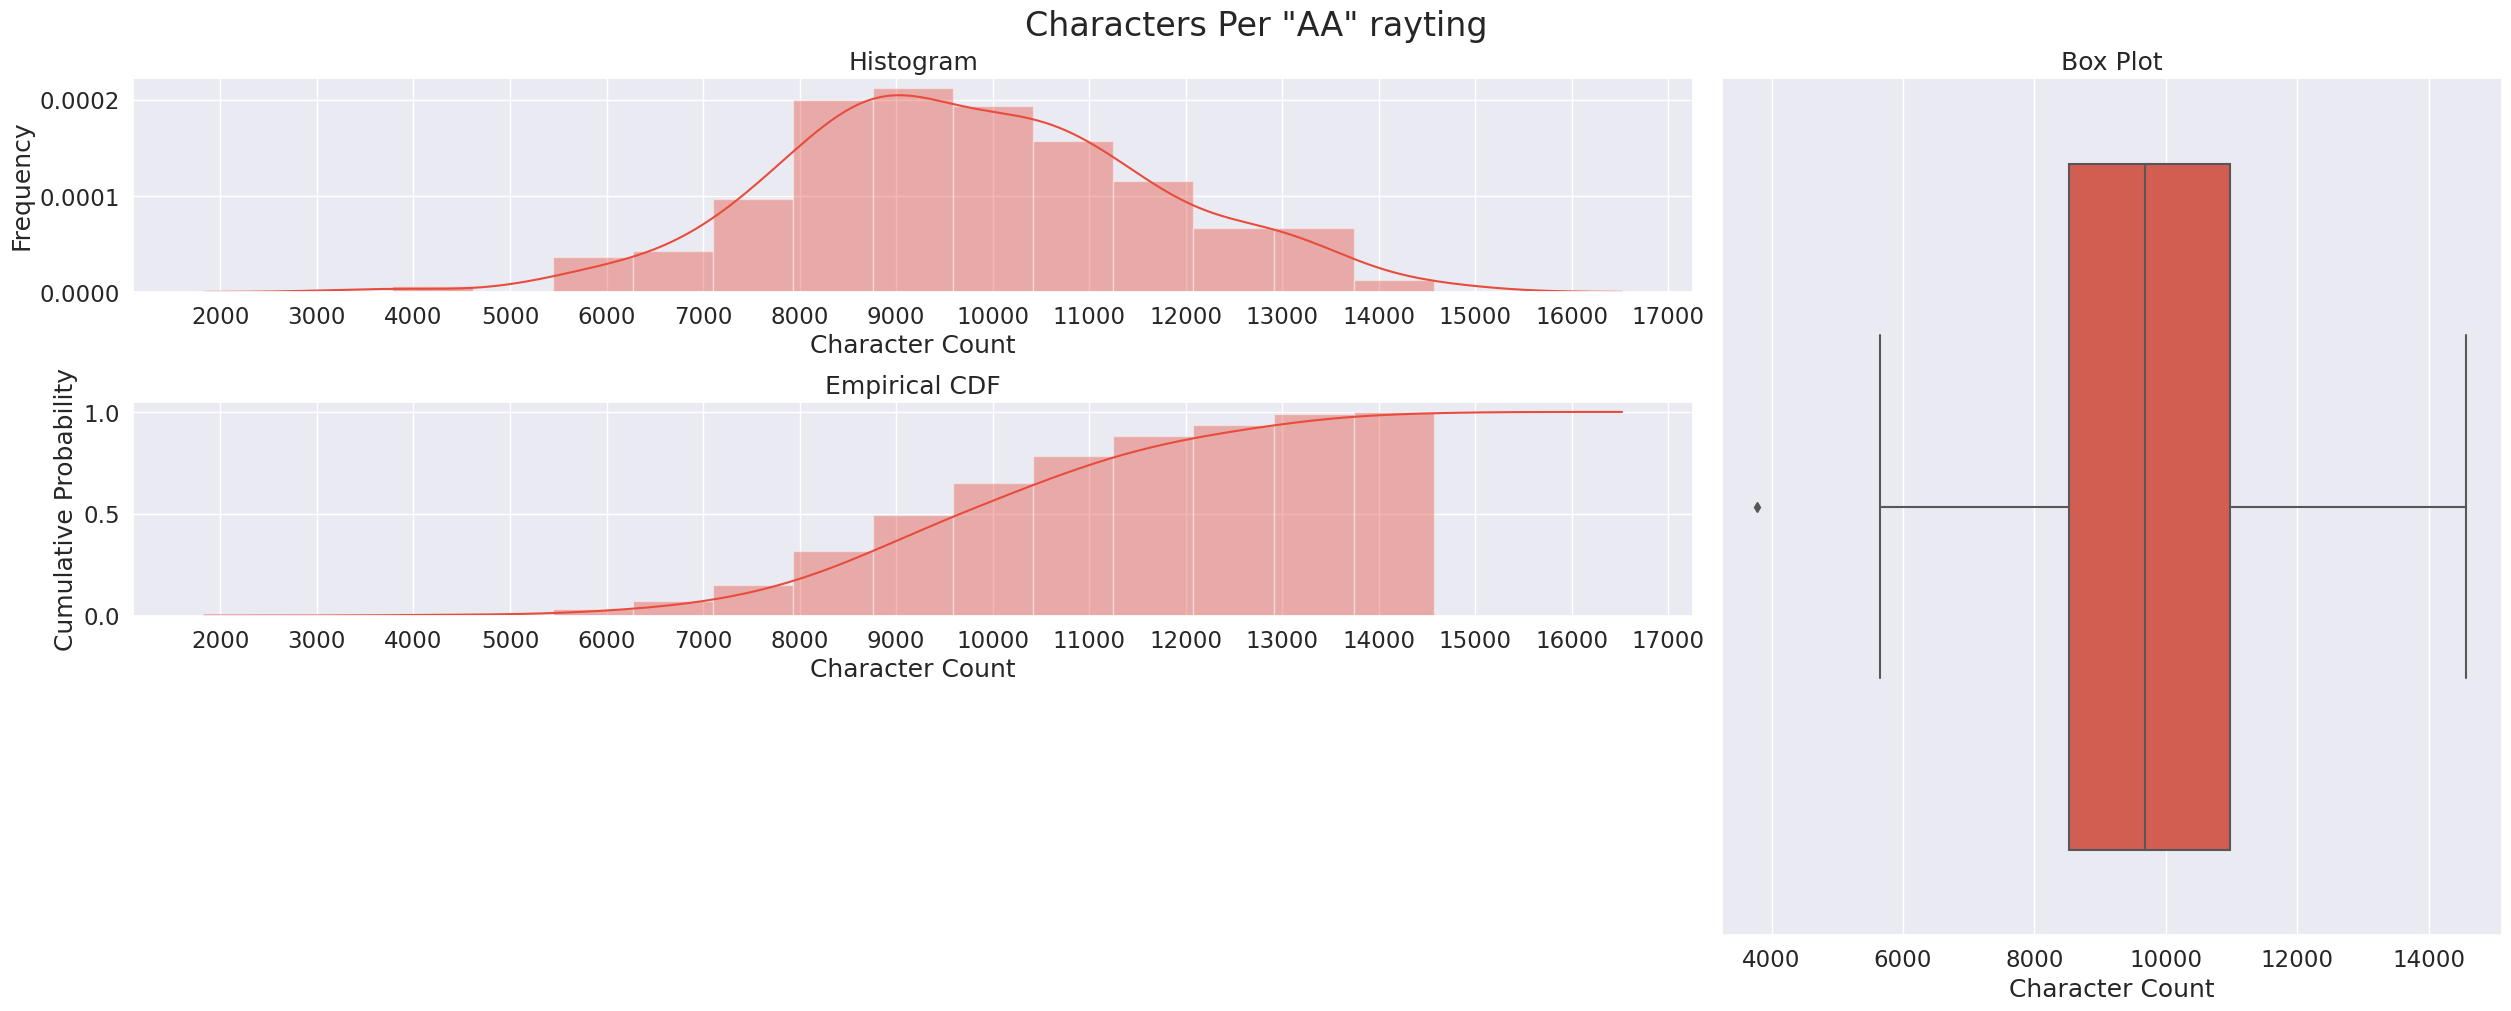

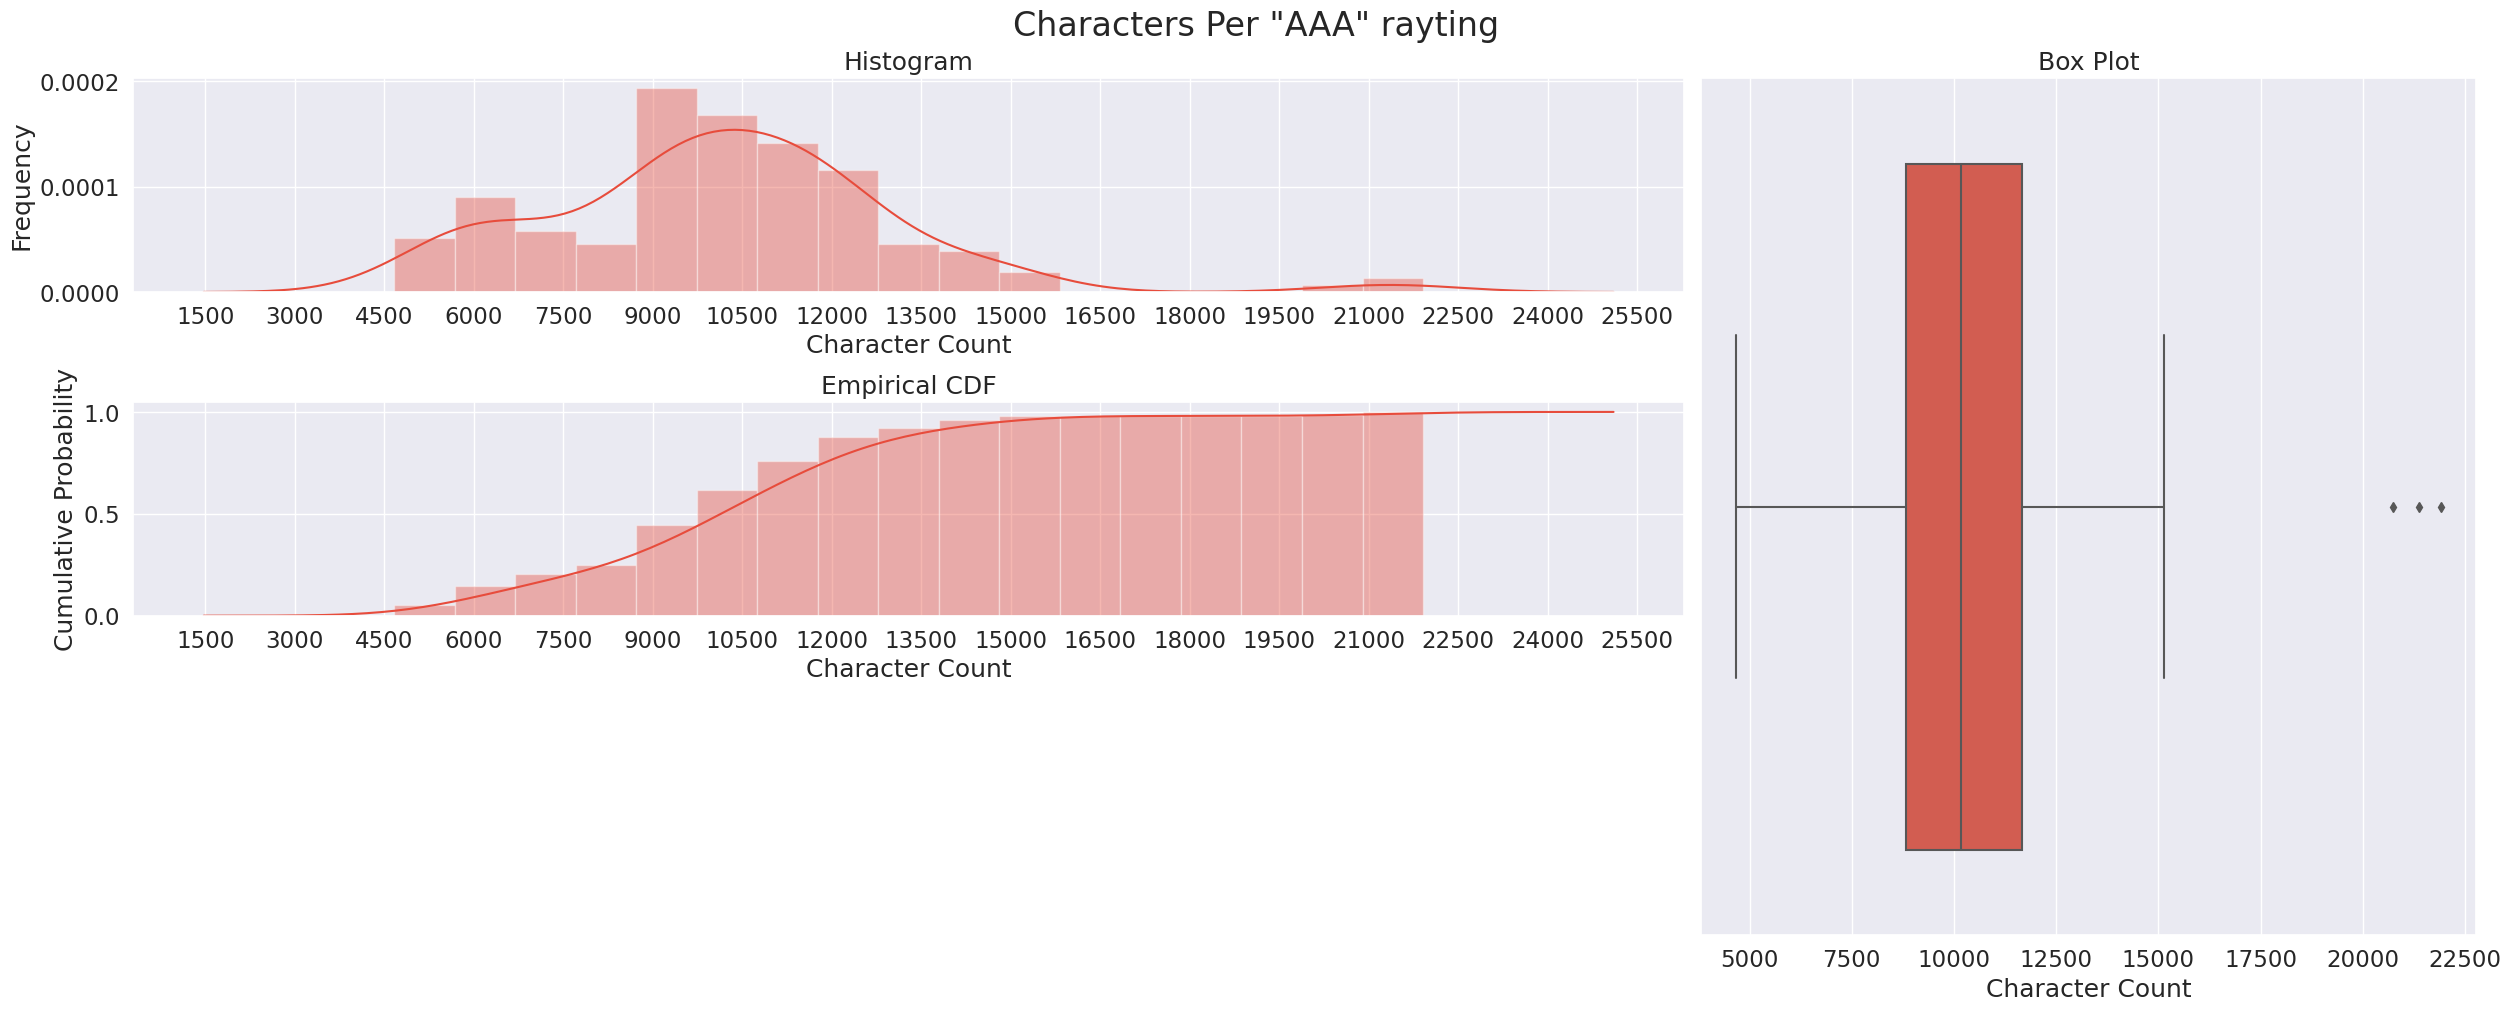

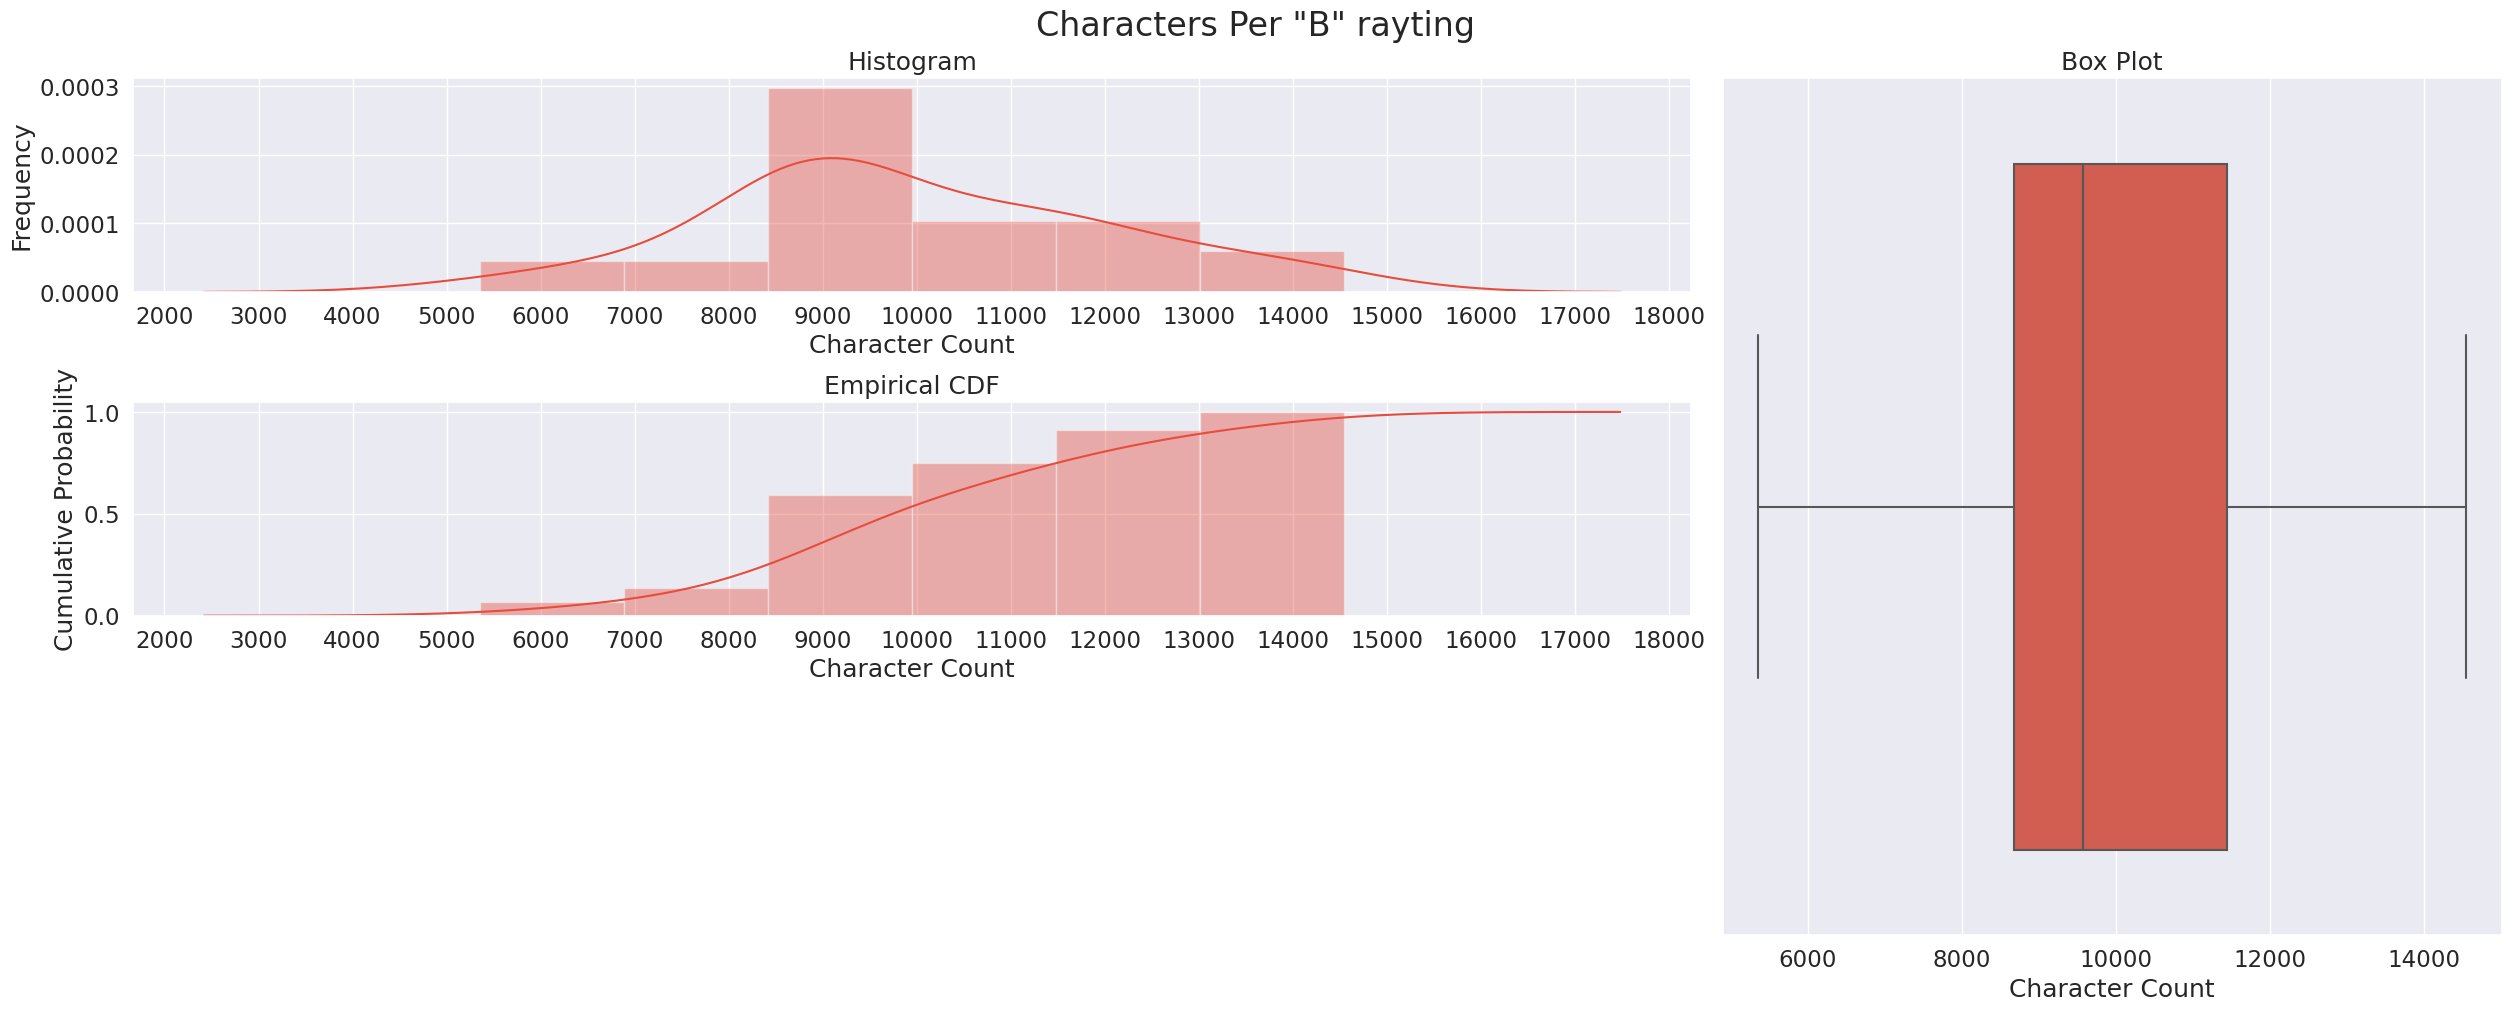

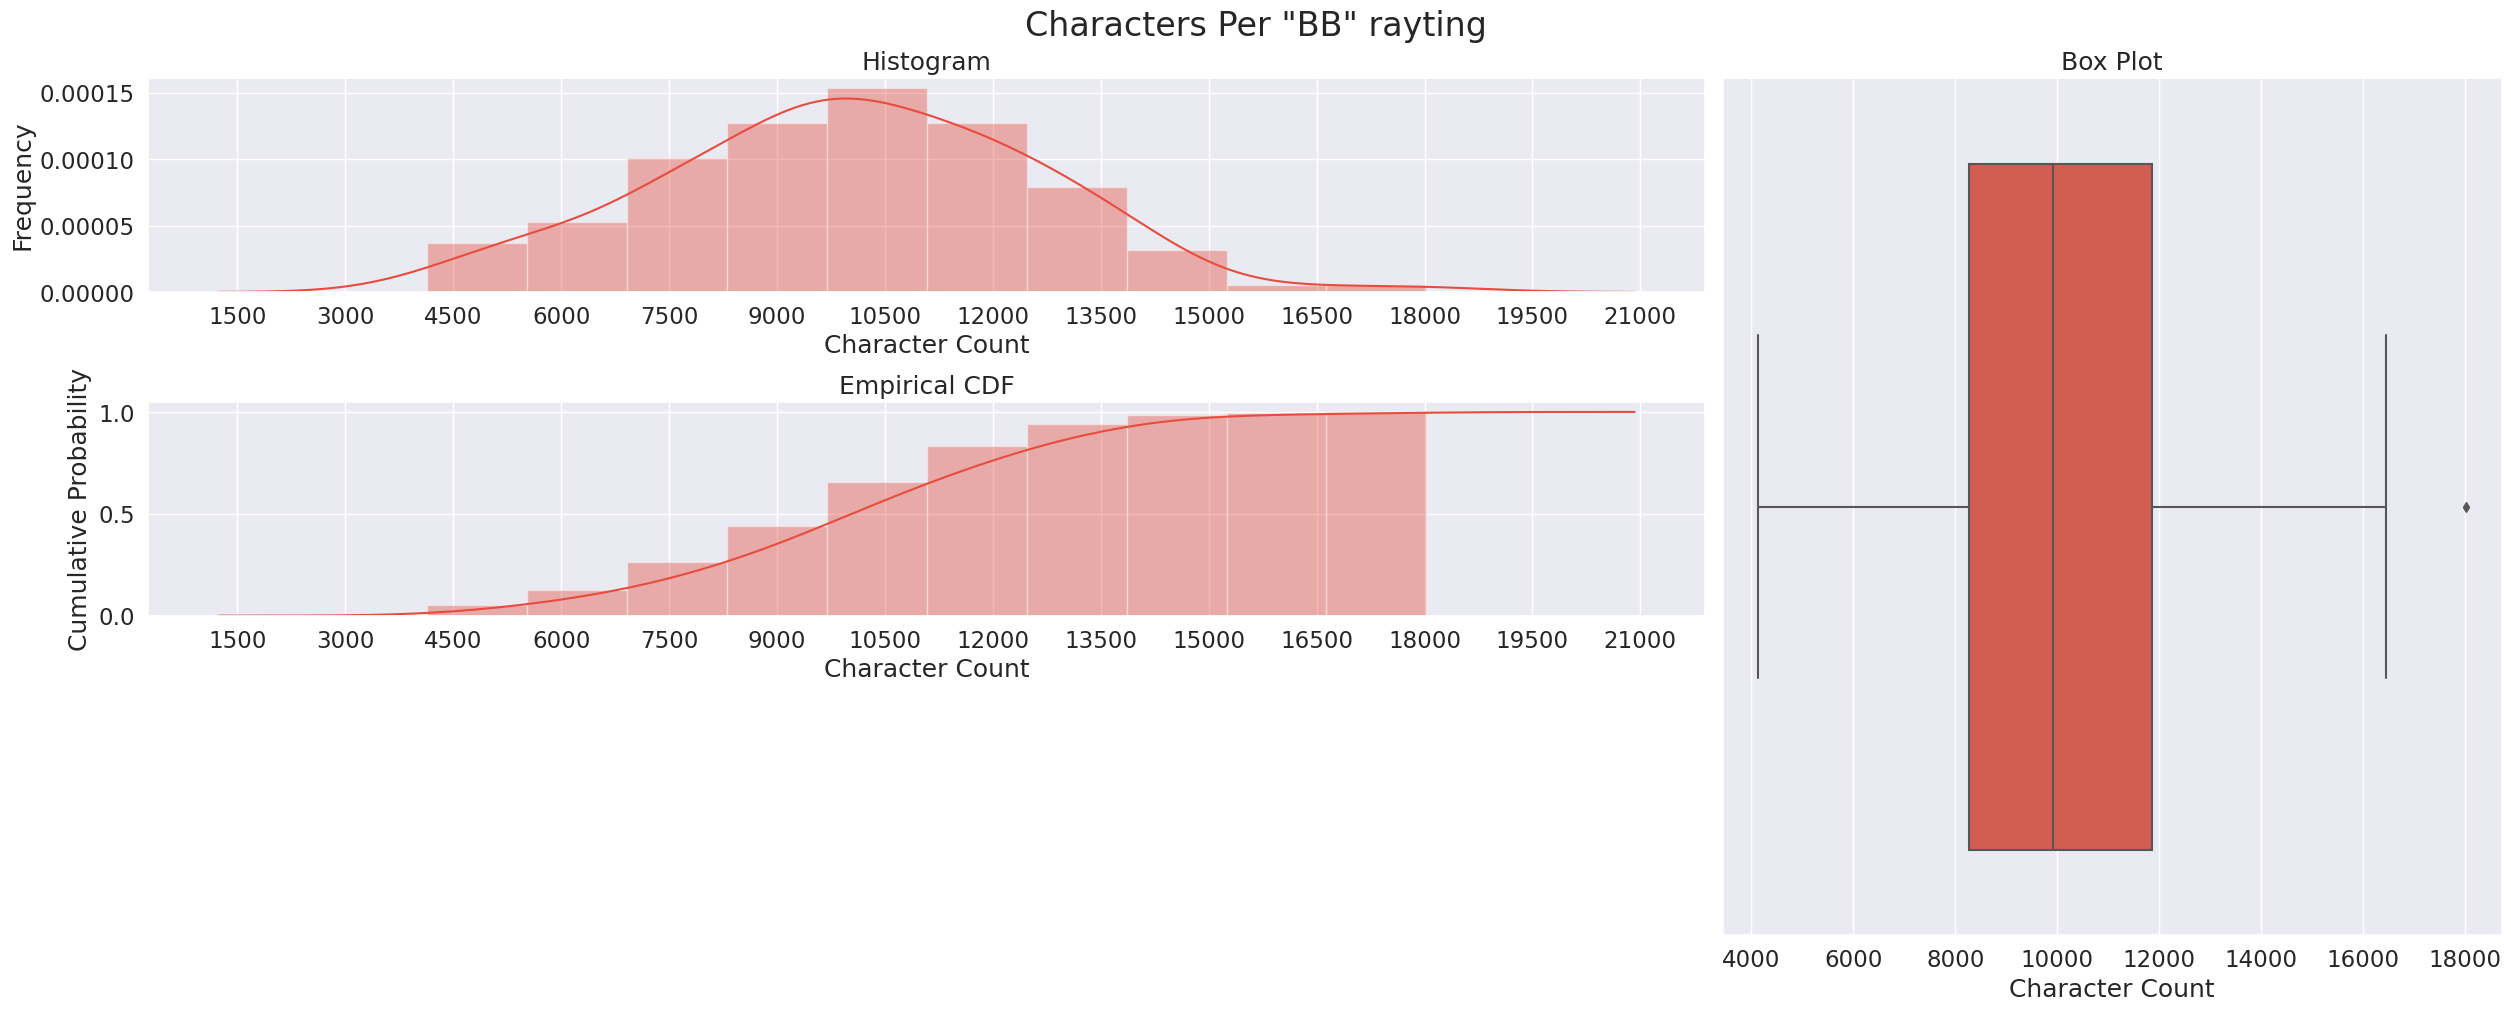

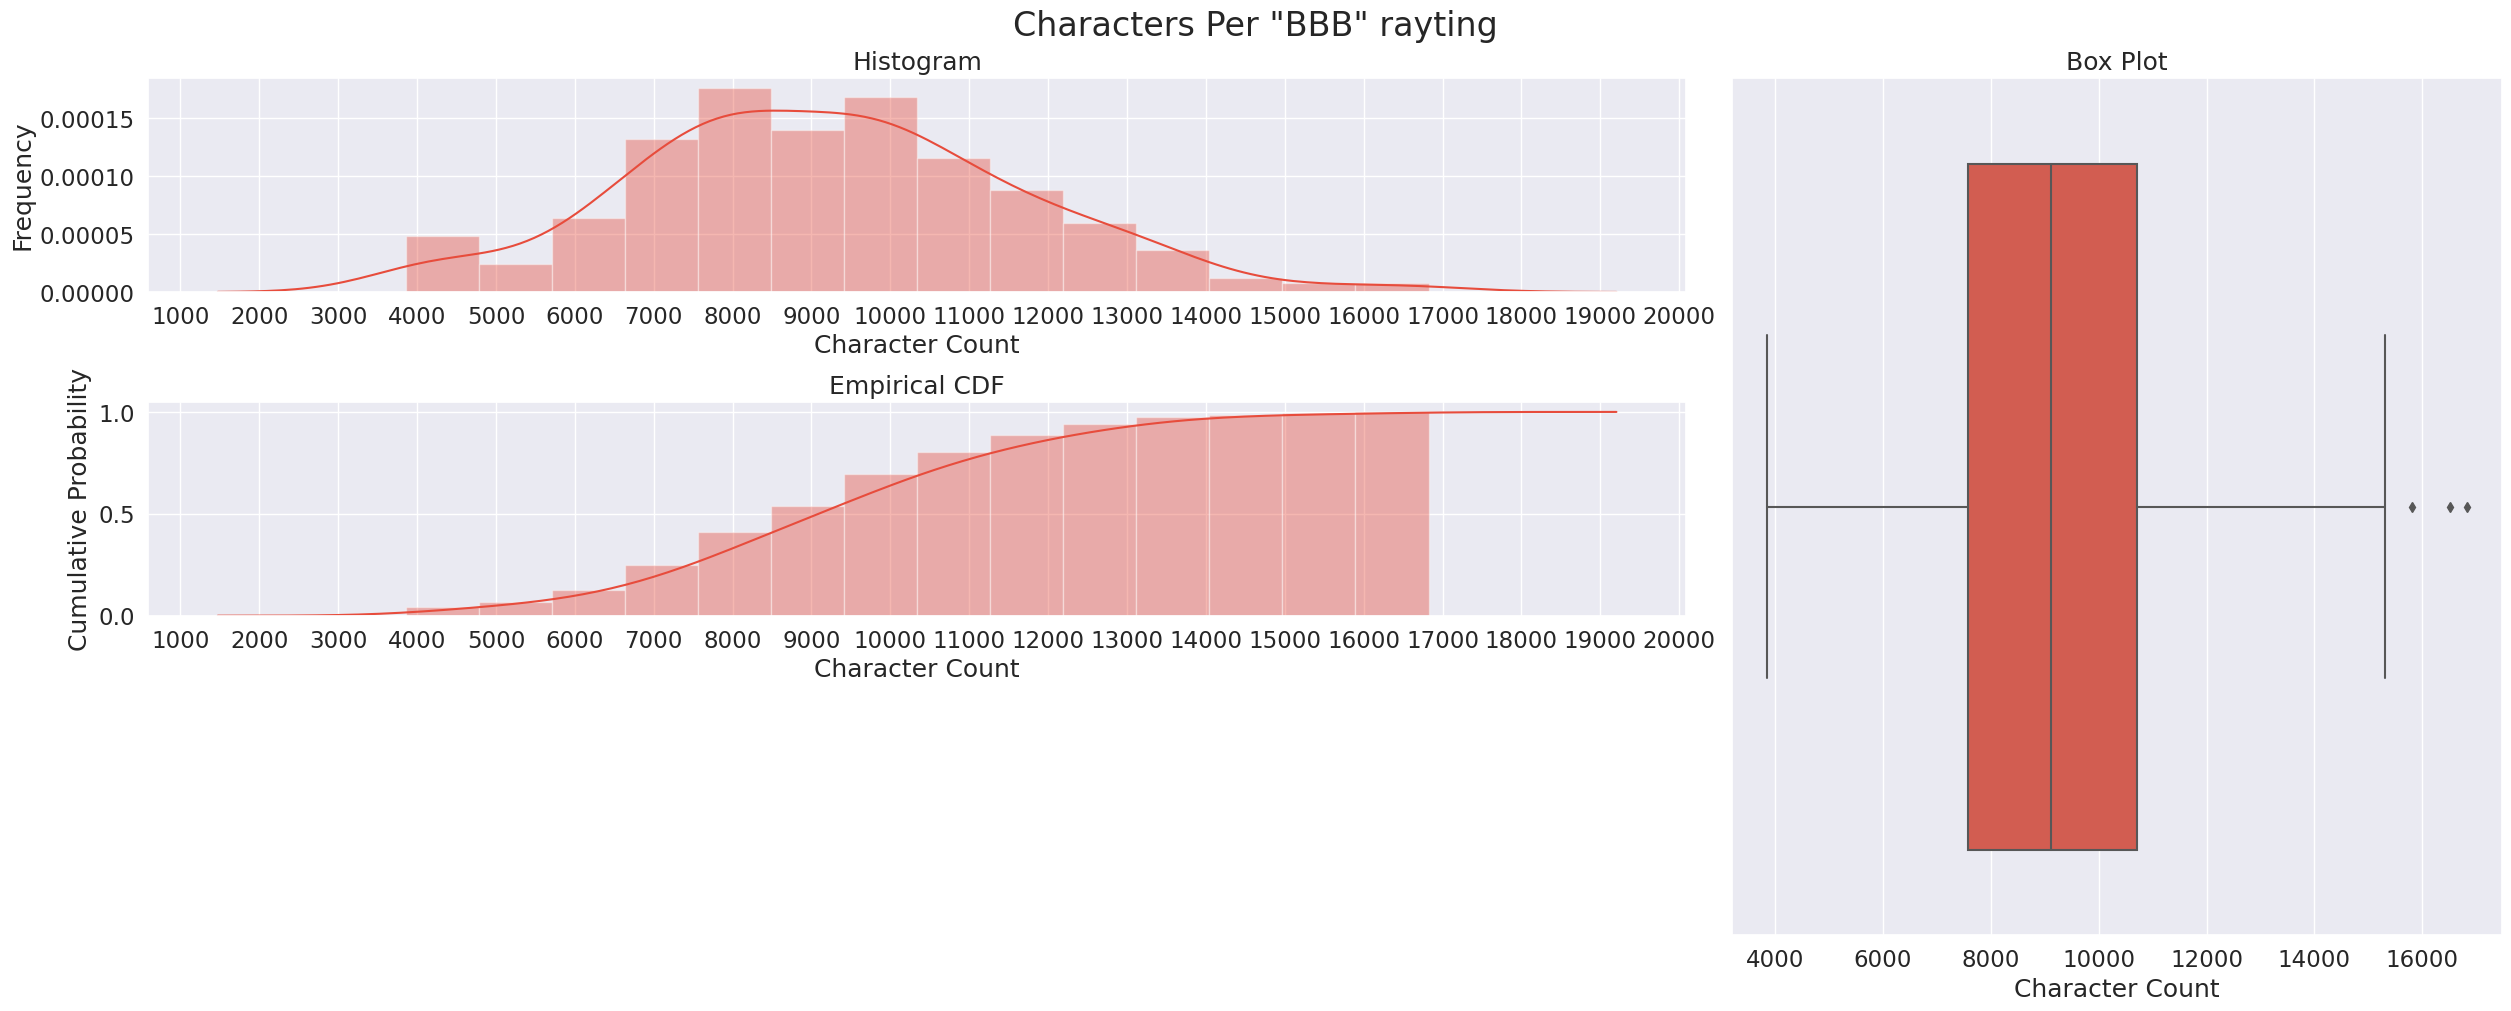

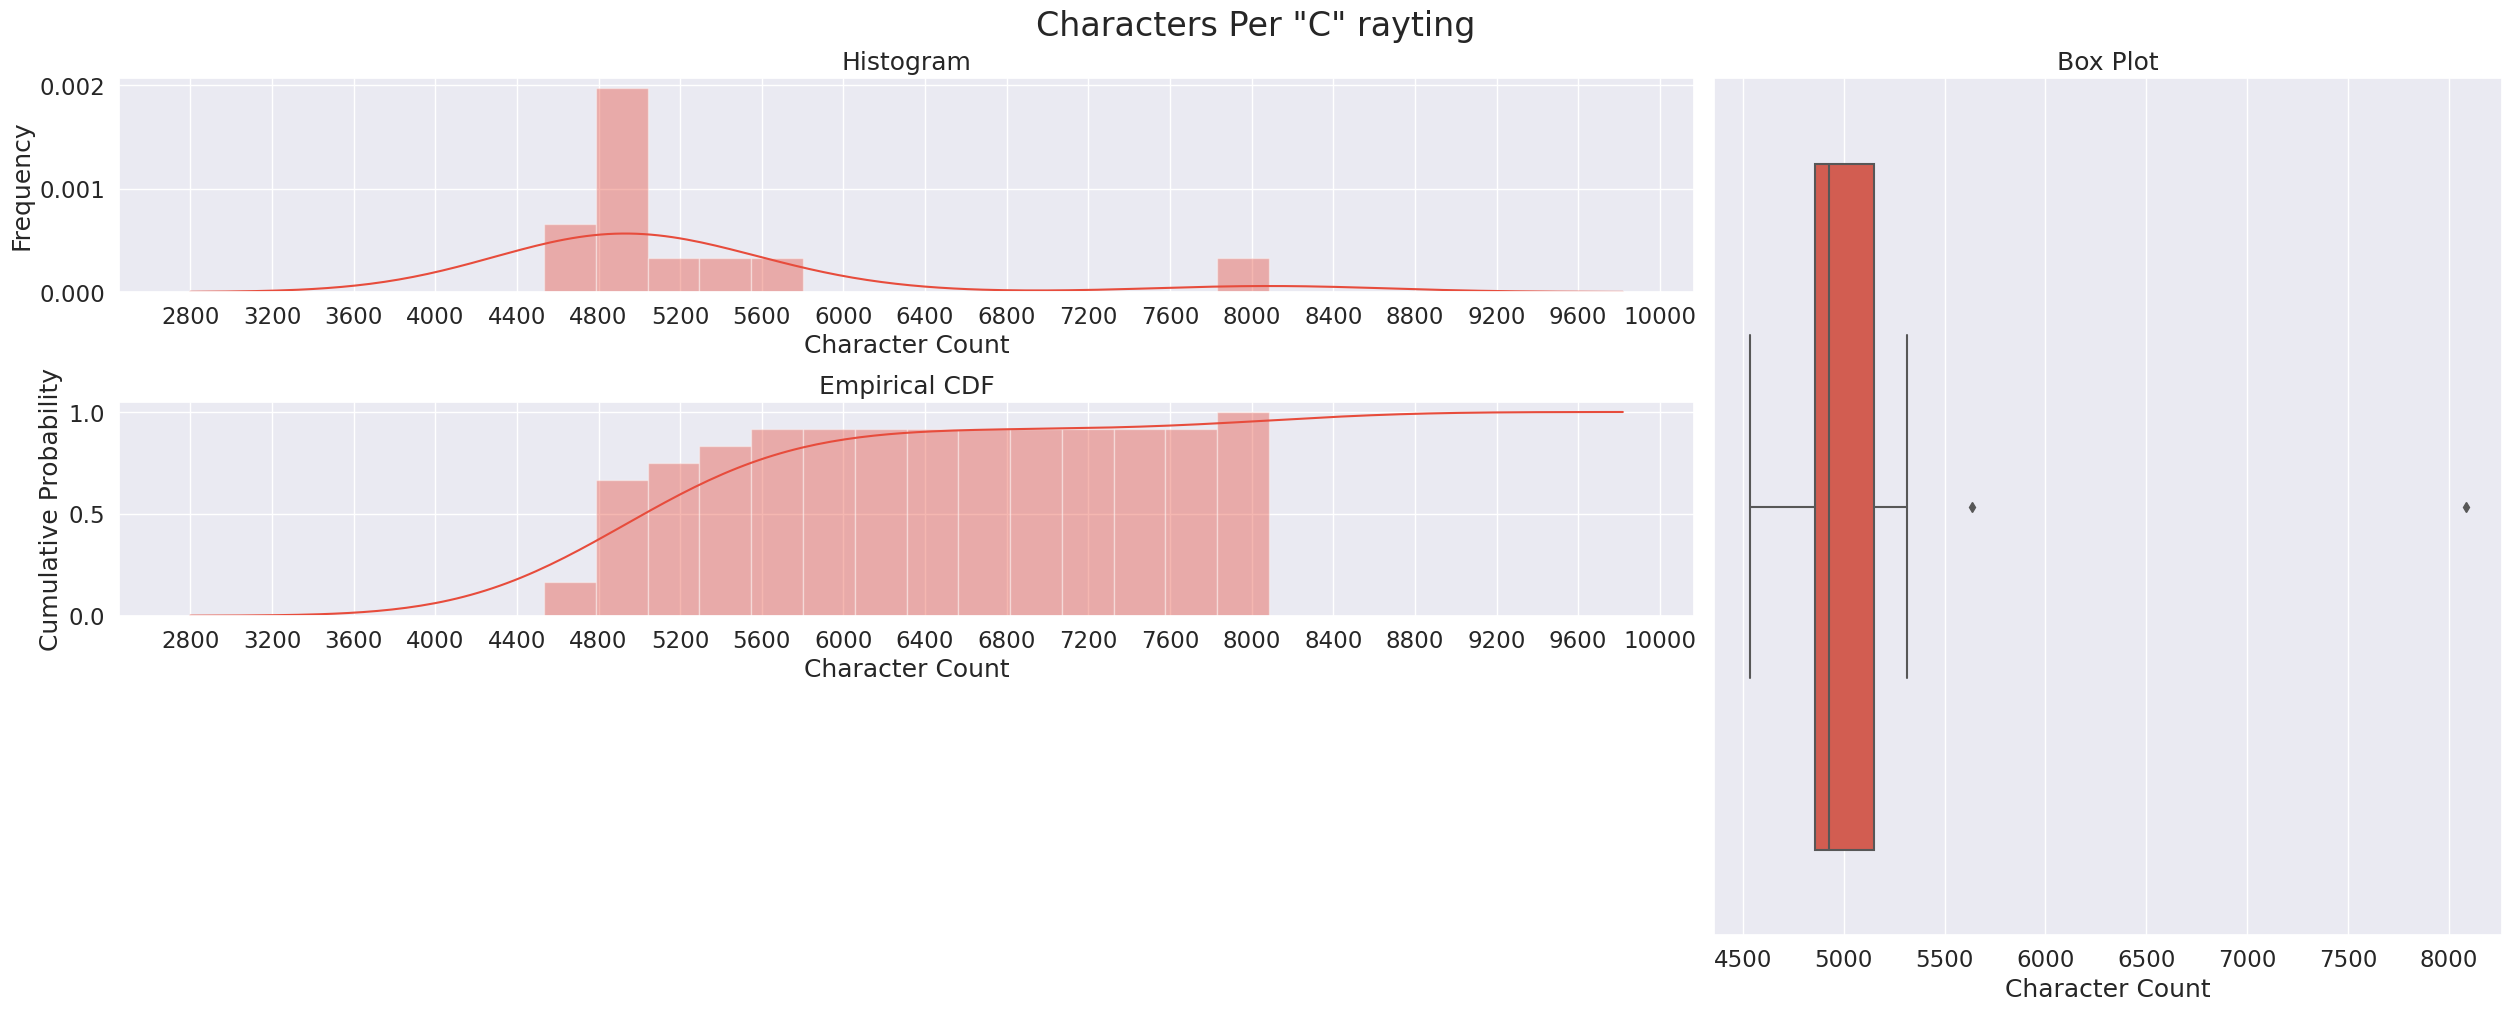

In [22]:
for i in labs:
    plot_dist3(df[df['label'] == i], 'Character Count', f'Characters Per "{i}" rayting')
    plt.show()

<a id="Word_Counts"></a>
## Word Counts

#### Ok let's check number of words per tweet now, they both look somewhat normally distributed, again disaster tweets seems to have slightly more words than non disaster ones. We might dig this deeper to get some more info in next part...

### [Back To Table of Contents](#top_section)

In [25]:
def plot_word_number_histogram(train):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=len(labs), figsize=(18, 6*len(labs)), sharey=False)
    for i, name in enumerate(labs):
        temp_data = df[df['label'] == name]['text'].copy()
        sns.distplot(temp_data.str.split().map(lambda x: len(x)), ax=axes[i], color='#e74c3c')
        axes[i].set_xlabel('Word Count')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'{name} rayting')

    fig.suptitle('Words Per Raytings', fontsize=24, va='baseline')

    fig.tight_layout()

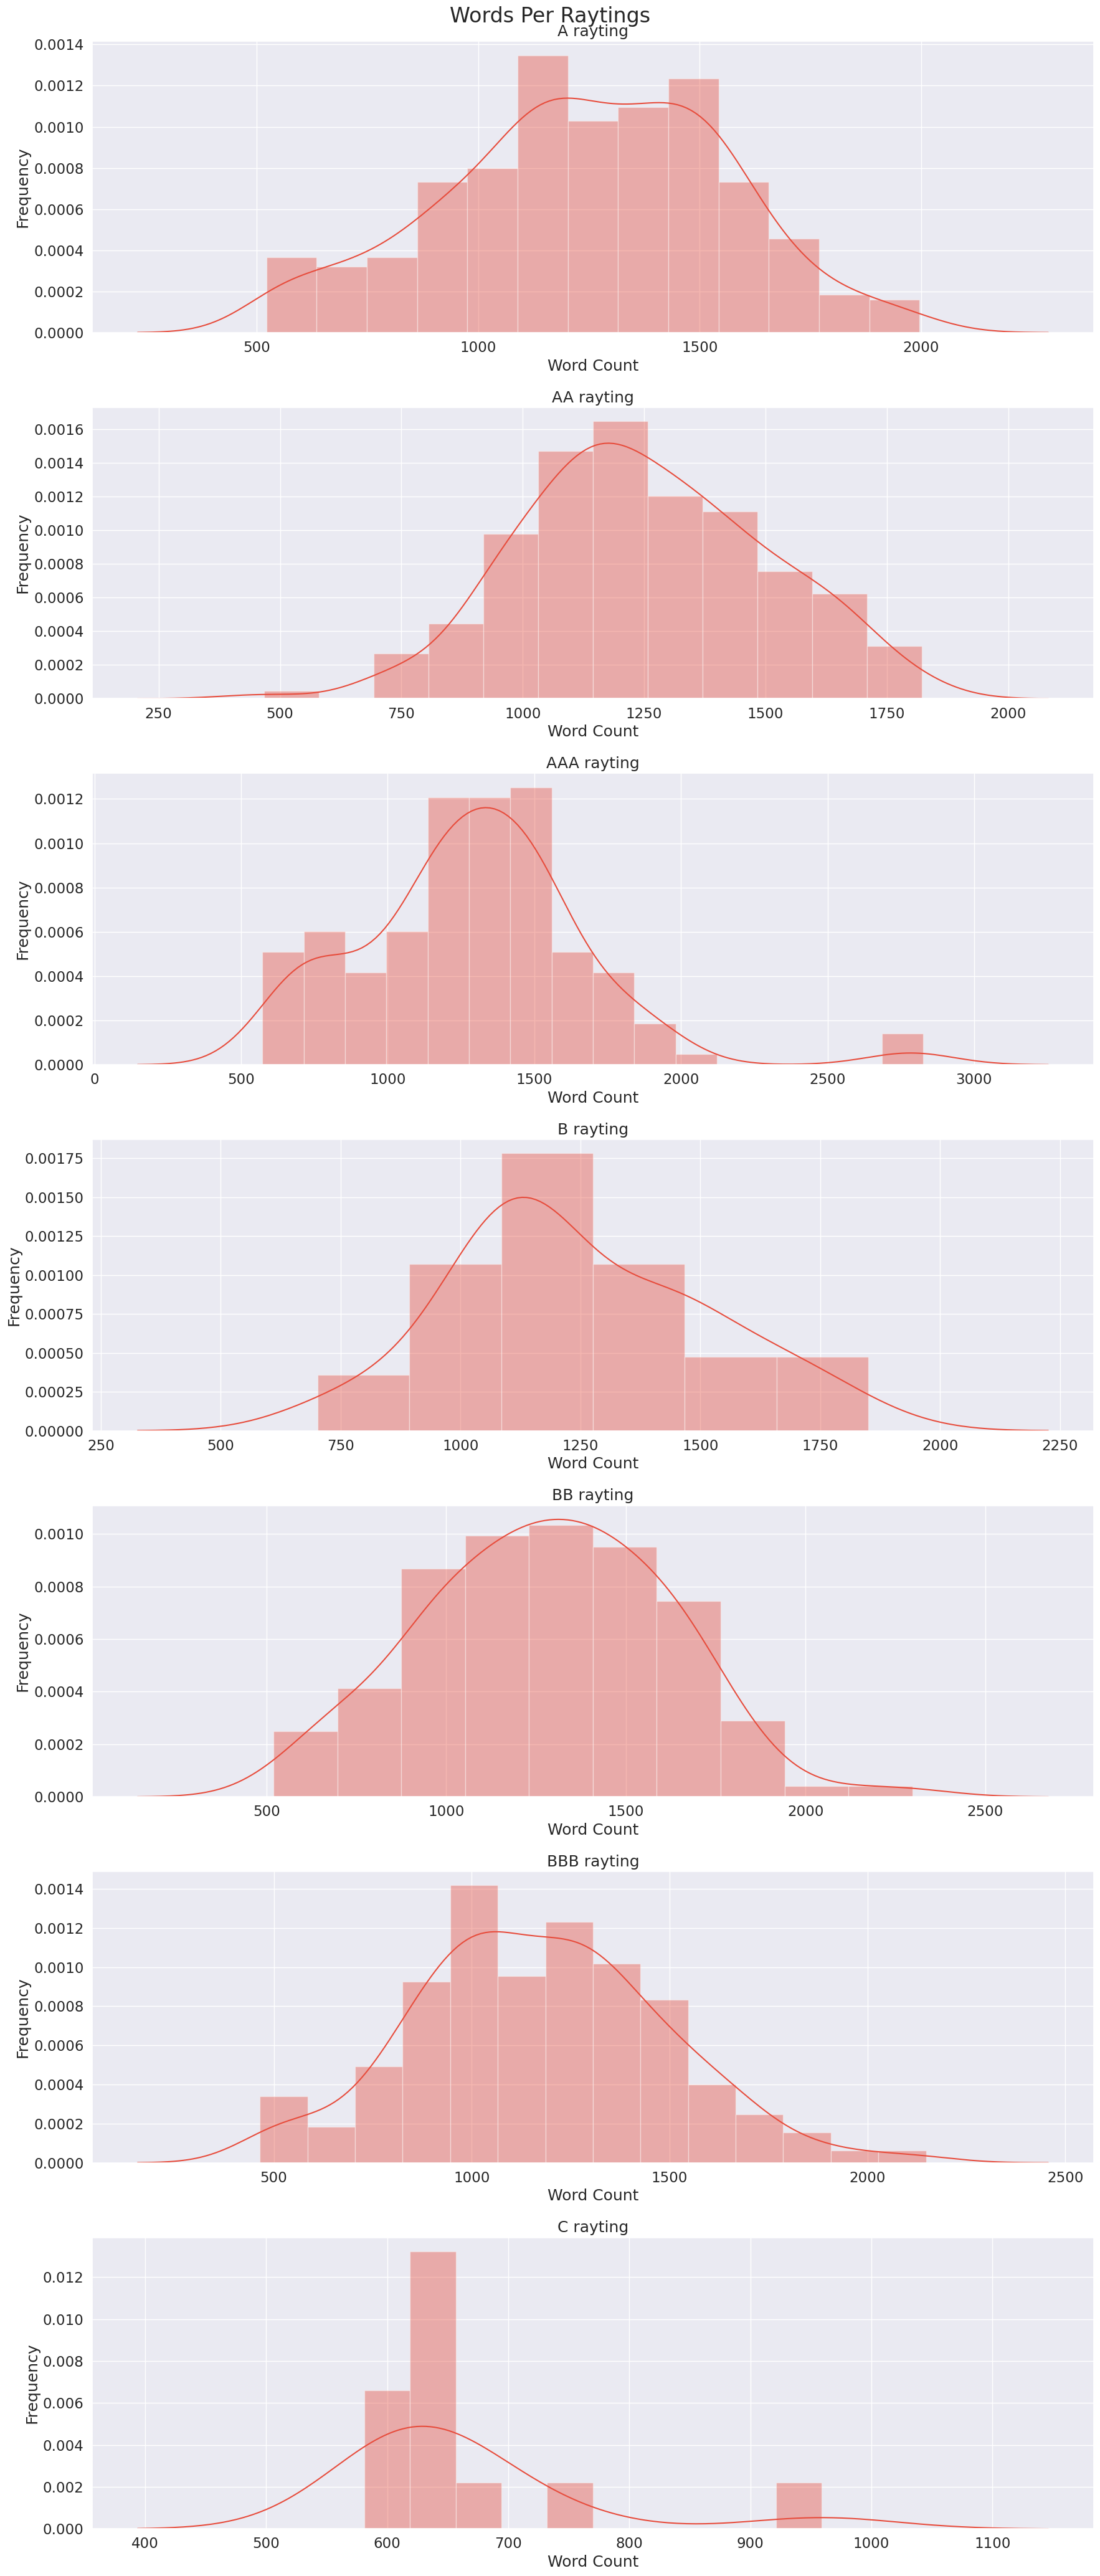

In [26]:
plot_word_number_histogram(df)

<a id="Word_Lengths"></a>
## Word Lengths

#### This time we're gonna check if word complexity differs from tweet class. It looks like disaster tweets has longer words than non disaster ones in general. It's pretty visible which is good sign, yet again we can only assume at this stage...

### [Back To Table of Contents](#top_section)

In [28]:
def plot_word_len_histogram(train):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=len(labs), figsize=(18, 6*len(labs)), sharey=False)
    for i, name in enumerate(labs):
        temp_data = train[train['label'] == name]['text'].copy()
        sns.distplot(temp_data.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[i], color='#e74c3c')
        axes[i].set_xlabel('Word Length')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'{name} rayting')

    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')

    fig.tight_layout()

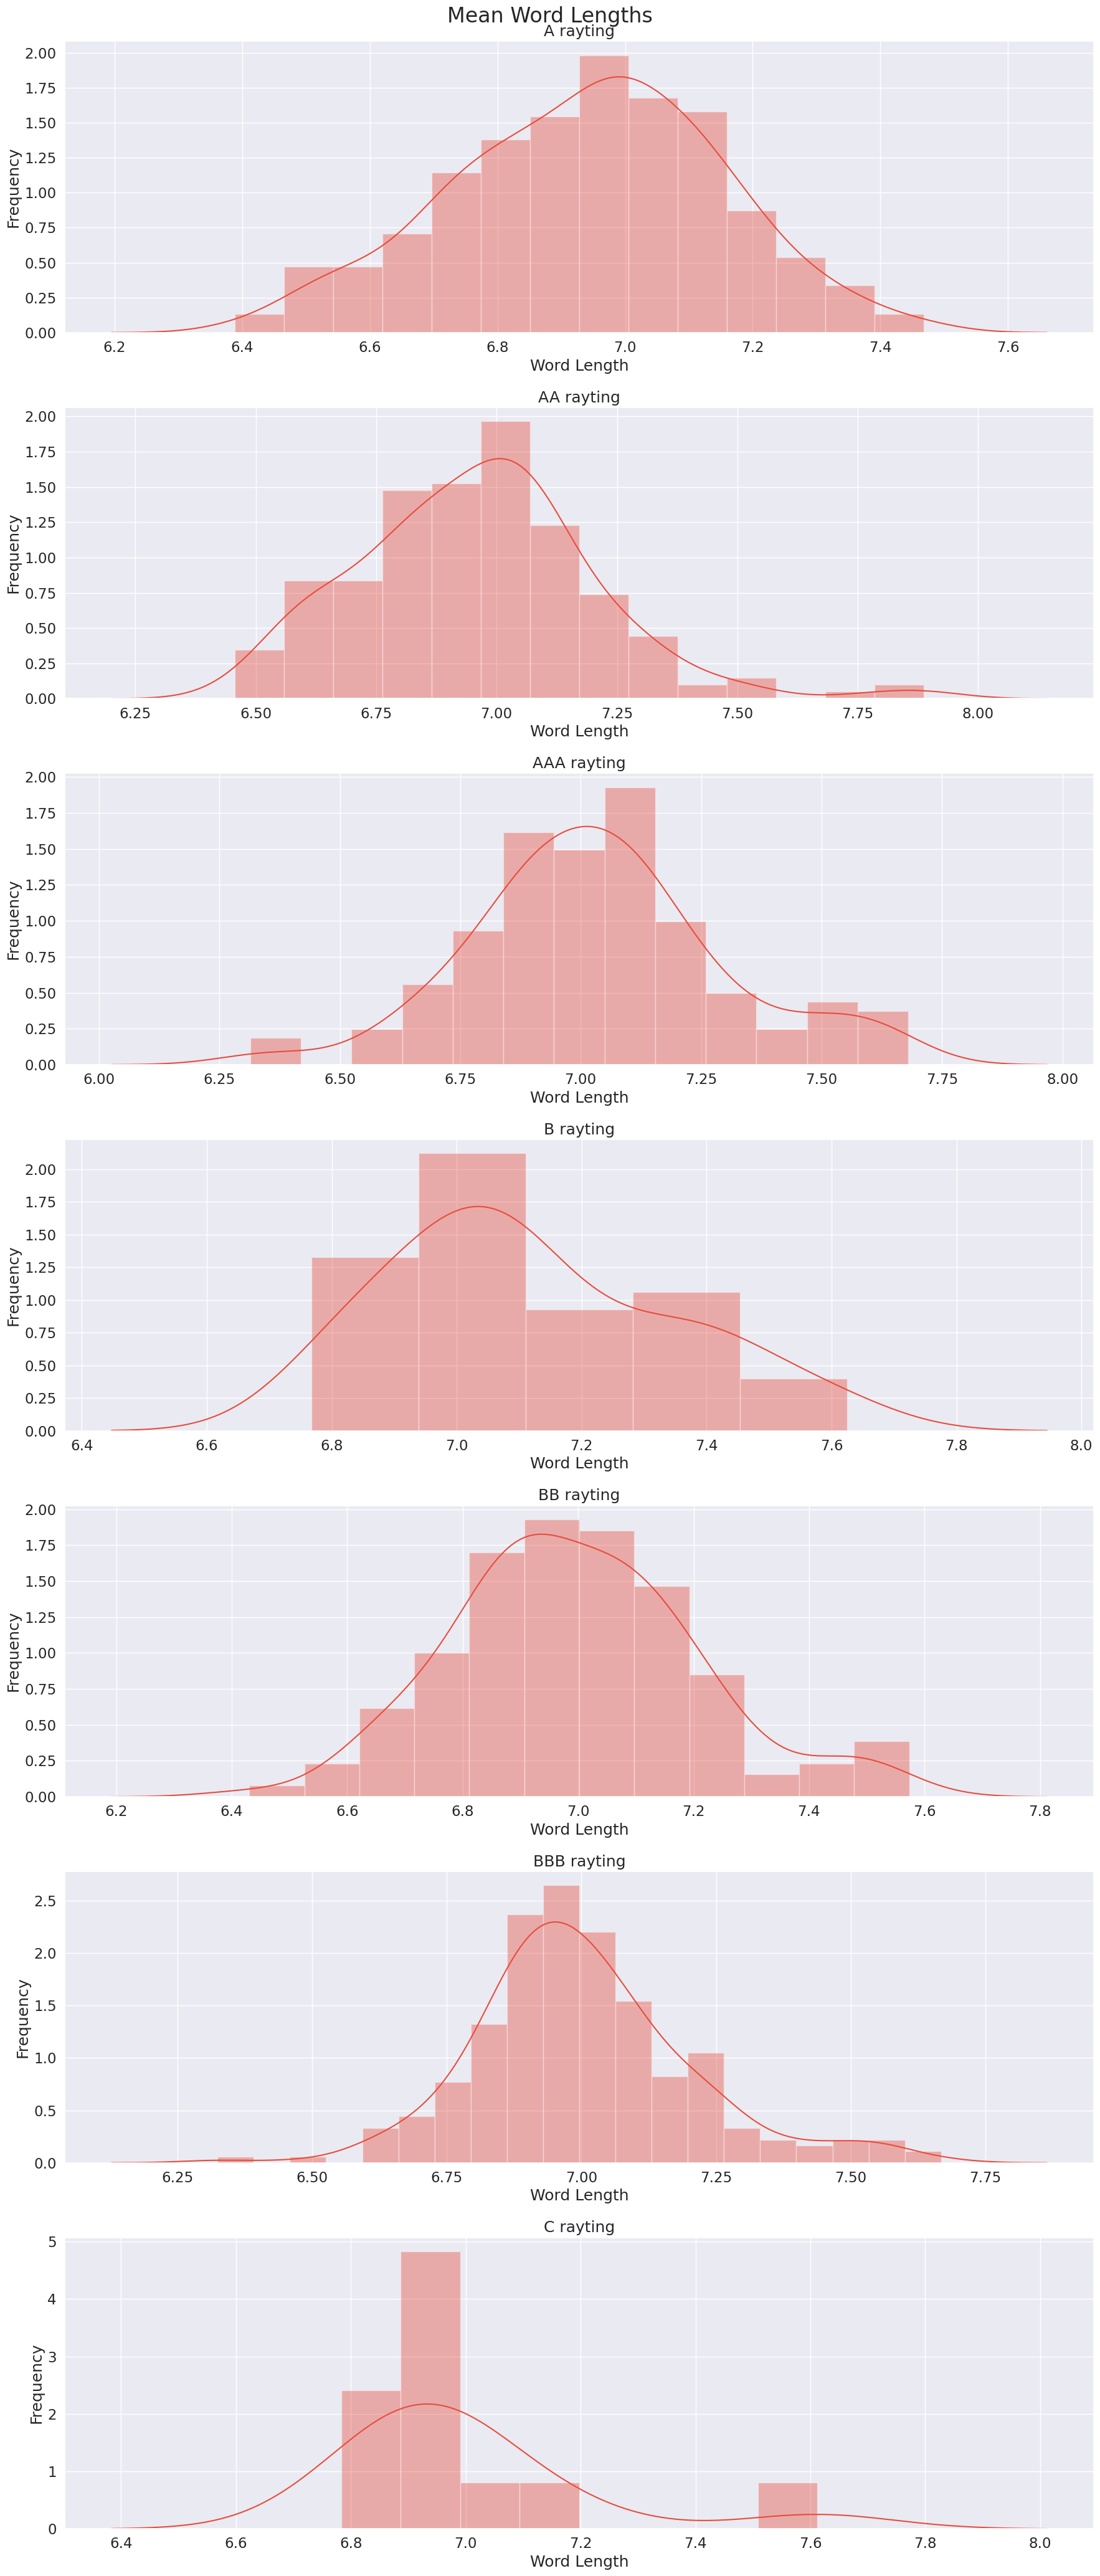

In [29]:
plot_word_len_histogram(df)

In [30]:
lis = [
    df[df['label'] == i]['lemma_str'] for i in labs
]

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        x, y = zip(*top)
        df1 = pd.DataFrame([x, y]).T
        df1 = df1.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df1, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

No stopwords left in texts.


<a id="Most_Common_Words"></a>
## Most Common Words

#### It's time to move to words themselves instead of their quantitative features. We start with most common words in both classes. I'd say it's pretty obvious if it's from disaster tweets or not. Disaster tweets has words like fire, kill, bomb indicating disasters. Meanwhile non disaster ones looks like pretty generic.


### [Back To Table of Contents](#top_section)

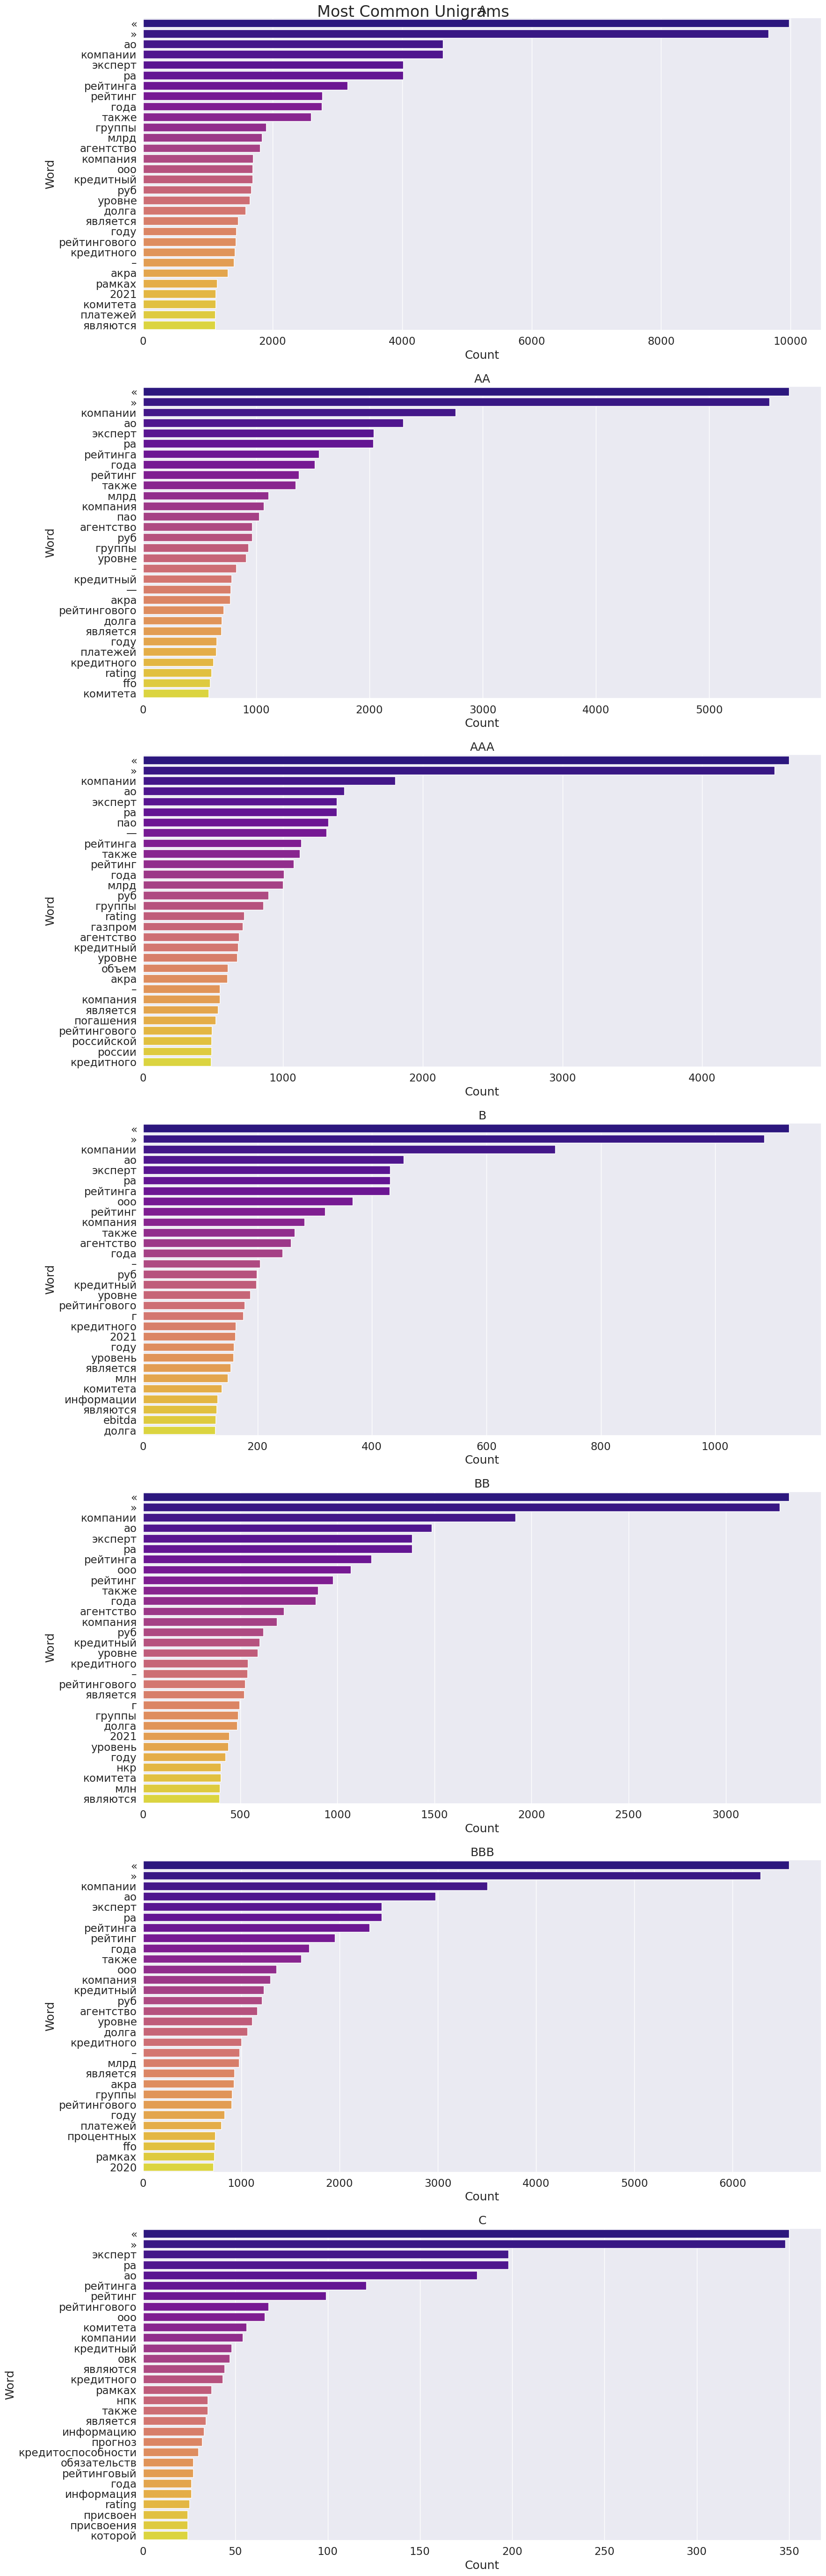

In [32]:
# Displaying most common words.

fig, axes = plt.subplots(len(labs), 1, figsize=(18, 8*len(labs)))
axes = axes.flatten()

for ind, (i, j) in enumerate(zip(lis, axes)):
    axes[ind].set_title(f'{labs[ind]}')
    axes[ind].set_xlabel('Count')
    axes[ind].set_ylabel('Word')

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [33]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(len(labs), 1, figsize=(18, 8*len(labs)))
    axes = axes.flatten()
    for ind, (i, j) in enumerate(zip(lis, axes)):
        axes[ind].set_title(f'{labs[ind]}')
        axes[ind].set_xlabel('Count')
        axes[ind].set_ylabel('Word')

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=1,
                                  min_df = 1,
                                  stop_words=list(stop)).fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

<a id="Most_Common_Bigrams"></a>
## Most Common Bigrams

#### Let's have a look for bigrams this time, which they are sequences of adjacent two words. Again it's pretty obvious to seperate two classes if it's disaster related or not. There are some confusing bigrams in non disaster ones like  body bag, emergency service etc. which needs deeper research but we'll leave it here since we got what we looking for in general.

### [Back To Table of Contents](#top_section)

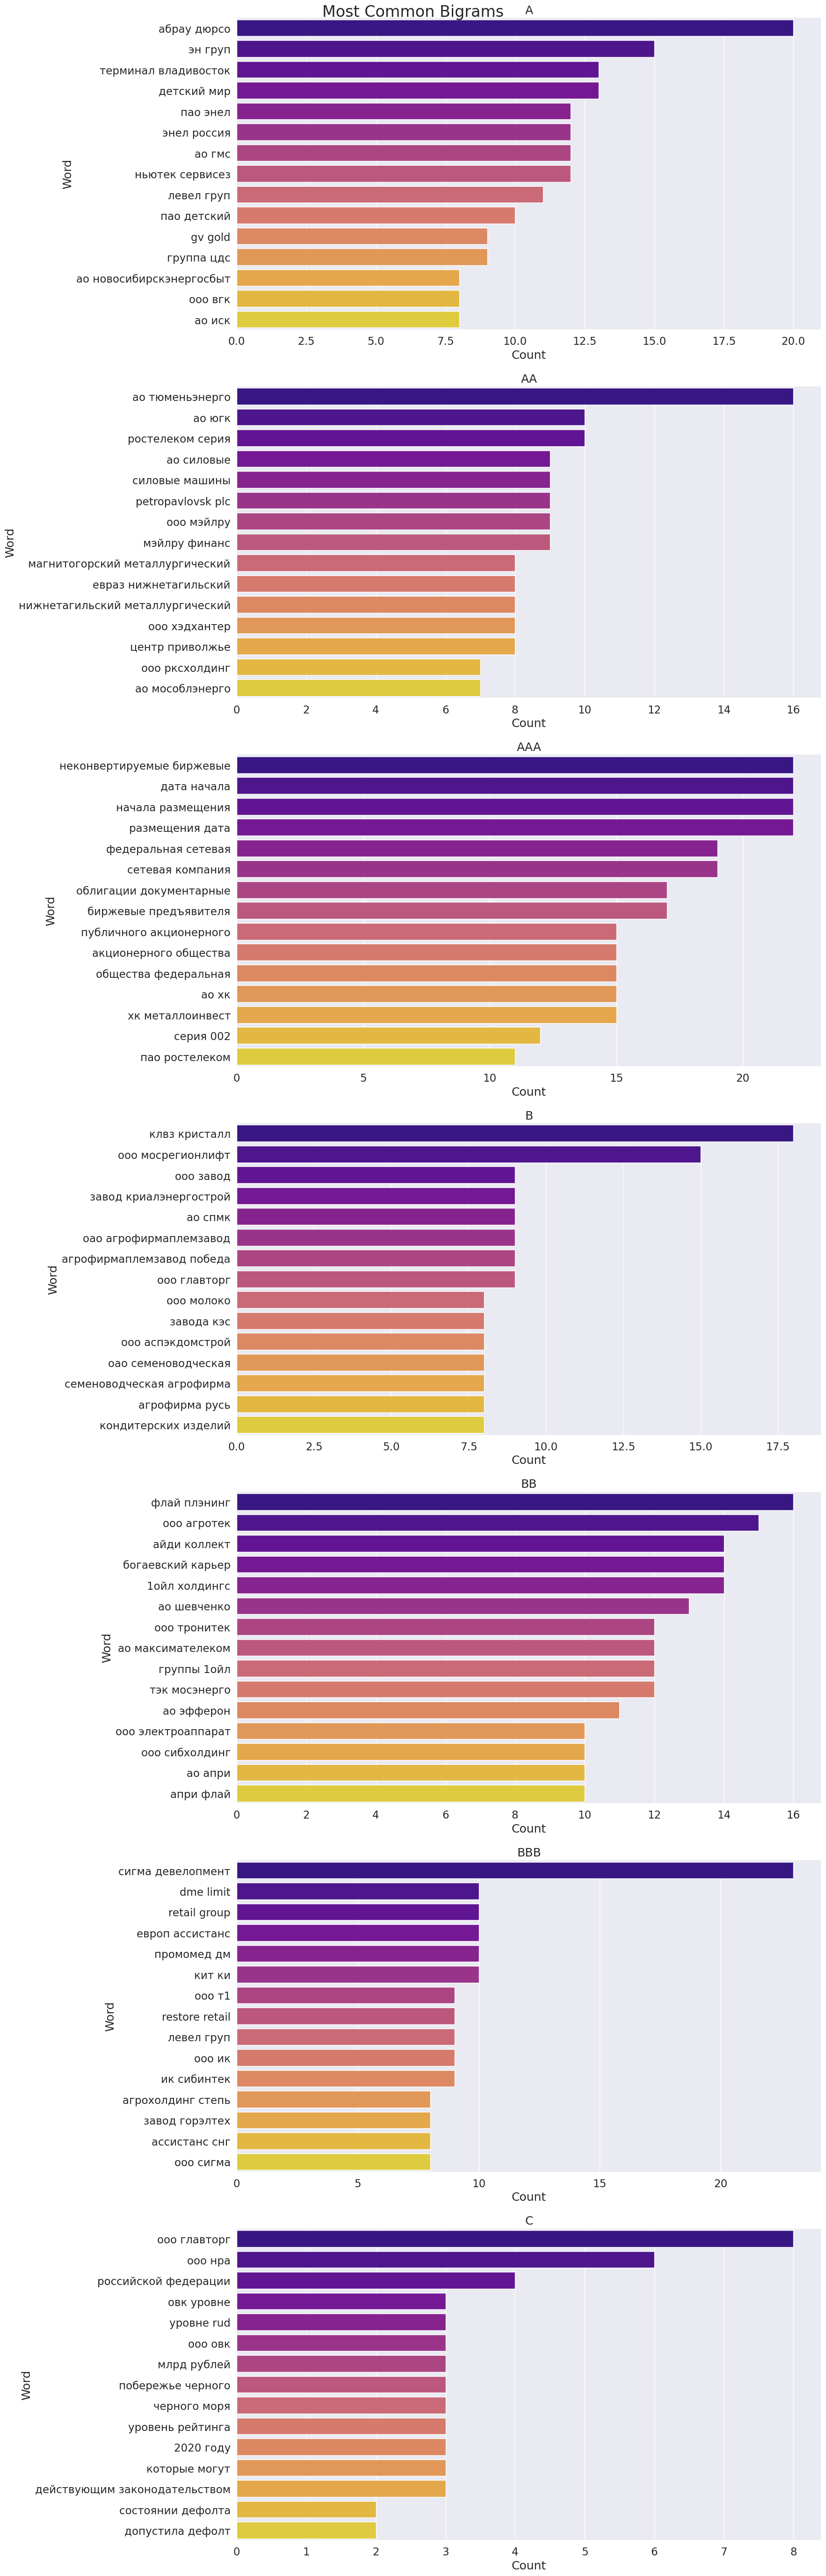

In [34]:
ngrams(2, 'Most Common Bigrams')

<a id="Most_Common_Trigrams"></a>
## Most Common Trigrams

#### Alright! Things are much clearer with sequences of 3 words. The confusing body bags were cross body bags (Who uses them in these days anyways!) which I found it pretty funny when I found the reason of the confusion. Anyways we can see disasters are highly seperable now from non disaster ones, which is great!

### [Back To Table of Contents](#top_section)

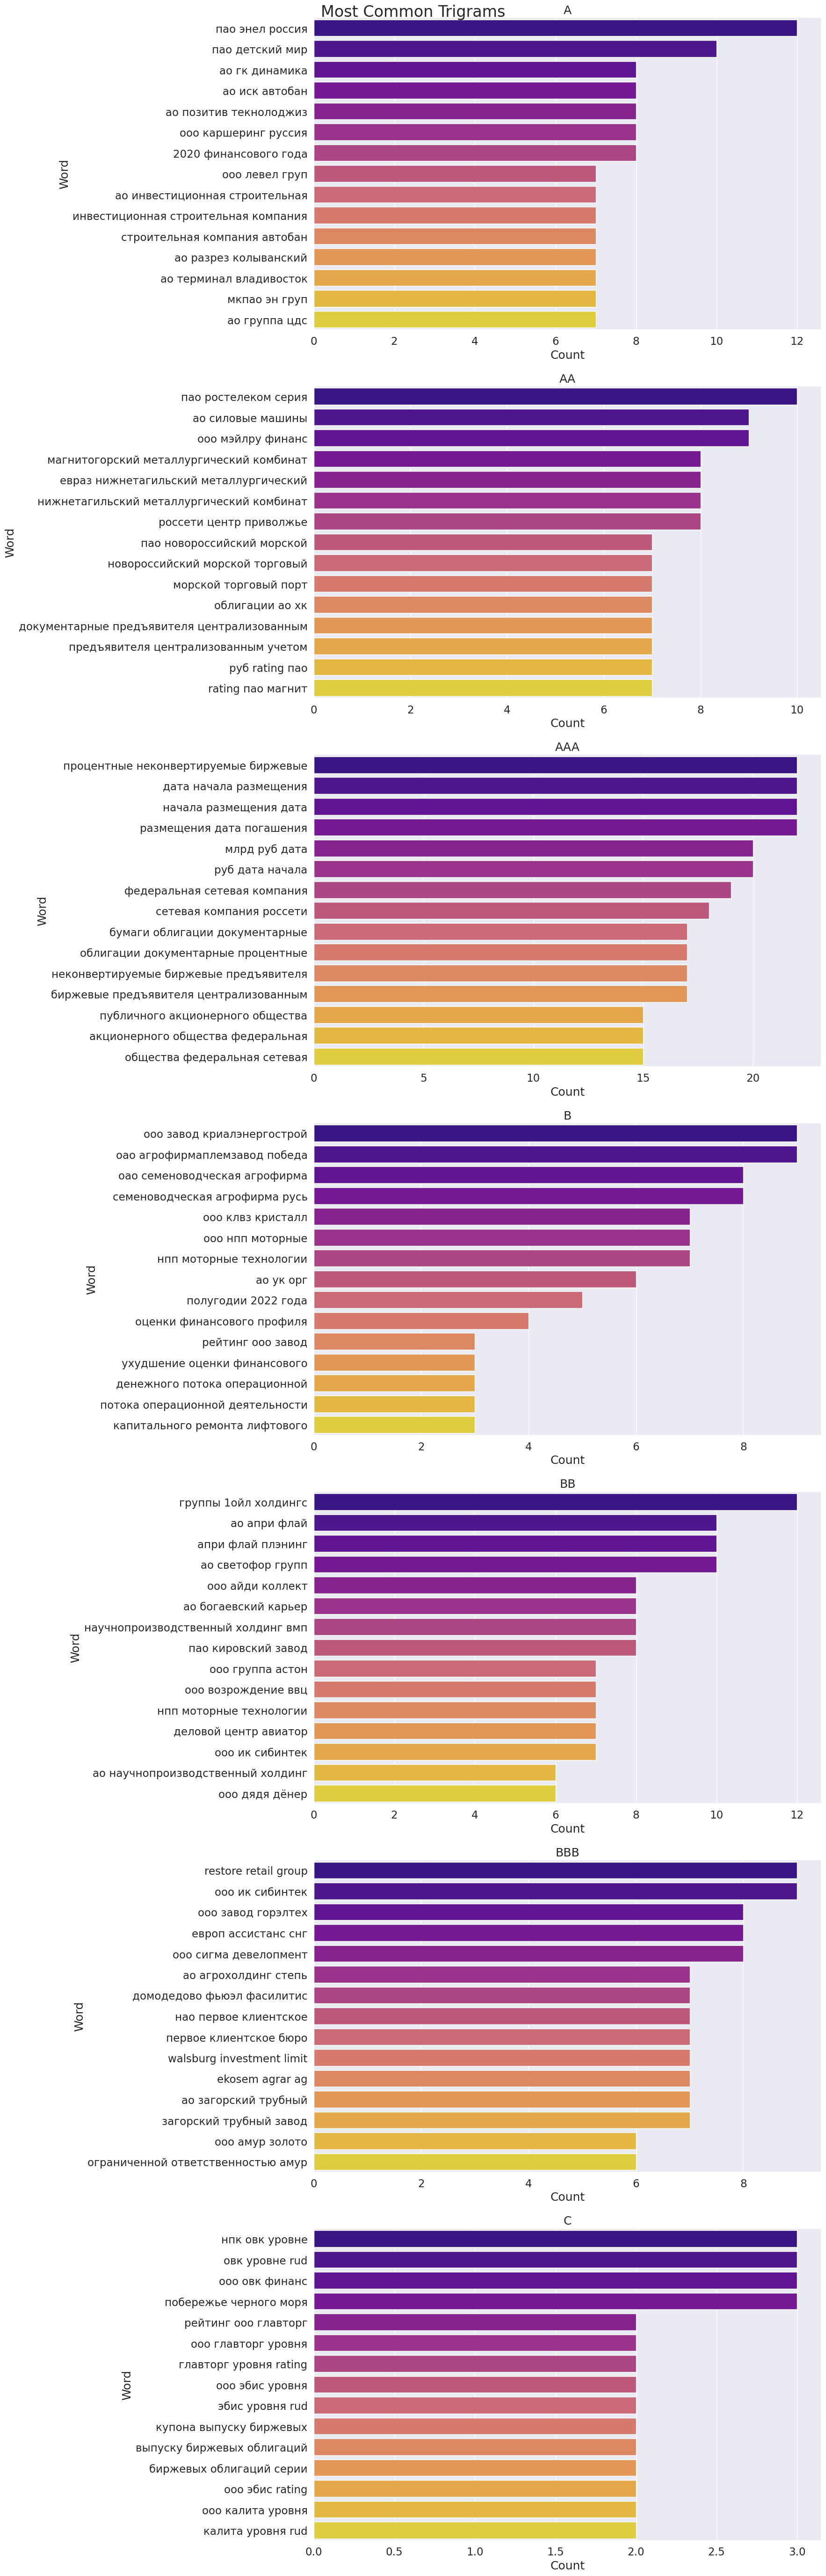

In [35]:
ngrams(3, 'Most Common Trigrams')

## Tokenizer

In [41]:
df['text'][0]

'Повышение кредитного рейтинга  Акционерного общества «Уральская сталь»  (далее — «Уральская сталь», Компания) вызвано улучшением качественной оценки ликвидности в связи с рефинансированием краткосрочного банковского кредита посредством выпуска облигационного займа с погашением в 2025 году. Также пересмотр стратегических планов по реализации ряда инвестиционных проектов способствовал улучшению показателя «капитальные затраты к выручке». Улучшение ценовой конъюнктуры на мировом рынке чугуна обеспечило запуск доменной печи №3, находившейся ранее в резерве, что окажет дополнительное положительное влияние на денежный поток Компании в 2023 году.   Кредитный рейтинг Компании определяется средними рыночной позицией, бизнес-профилем и уровнем корпоративного управления, а также средней оценкой за размер бизнеса. Показатели рентабельности, ликвидности, долговой нагрузки, обслуживания долга и денежного потока получили высокие оценки.   «Уральская сталь» — один из крупнейших в России производителе

In [42]:
df['text'][1]

'«Эксперт РА» подтвердил кредитный рейтинг компании ООО «Энергоконцепции» на уровне <rating>  Москва, 31 марта  2023 г.  Рейтинговое агентство «Эксперт РА» подтвердило  рейтинг кредитоспособности  нефинансовой компании   ООО «Энергоконцепции»   на уровне <rating>. Прогноз по рейтингу – стабильный. ") ООО «Энергоконцепции» (далее – «компания») –  российская компания, занимающаяся поставкой, монтажом и обслуживанием  энергетического оборудования. Основные клиенты представлены производителями  тепловой и электрической энергии группы компаний ООО «Газпром энергохолдинг»  (<rating>, стаб.).   Агентство оценивает риск-профиль отрасли, в  которой компания ведет деятельность, нейтрально. Платежеспособность основных  клиентов компании находится на высоком уровне. Устойчивость к внешним шокам  оценивается агентством на среднем уровне, т.к. спрос на продукцию и услуги ООО  «Энергоконцепции» подвержен колебаниям экономических циклов. Барьеры для входа  находятся на умеренно низком уровне.   Рыночн

In [57]:
df['text'][6]

'«Эксперт РА» повысил кредитный рейтинг ОАО «МРСК Урала» до уровня <rating>   Москва, 24 марта  2023 г.  Рейтинговое агентство «Эксперт РА» повысило  рейтинг кредитоспособности  нефинансовой компании   ОАО «МРСК Урала»   до уровня <rating>. Прогноз по рейтингу – стабильный. Ранее у компании действовал рейтинг на уровне <rating> со стабильным прогнозом.  ") ОАО «МРСК Урала» (далее – «Компания») – дочерняя компания ПАО «Россети»,  осуществляющая передачу и распределение электроэнергии по сети линий  электропередачи. Компания эксплуатирует более 155 тыс. км кабельных и воздушных  линий электропередач с подстанциями общей установленной мощностью более 43 тыс.  МВА, расположенных в Пермском крае, Свердловской и Челябинской областях.  Компания является естественной монополией в регионах присутствия. За 2022  год потребителям было передано 58,0 млрд кВт-ч электроэнергии (+1% г/г). Несмотря на  экономическую неопределенность Компании удалось сохранить и немного увеличить полезный  отпуск элект

In [47]:
df_copy = df.copy()

In [48]:
df_copy['text_clean'] = df_copy['text'].replace(r'\(.*?\)\ *','',regex=True)



после этого отрезаем:
    Ключевые допущения
    Контакты для СМИ:
«Эксперт РА» замена ЭкспертРА
удаляем все в скобках
    df_copy['text_clean'] = df_copy['text'].replace(r'\(.*?\)\ *','',regex=True)
удаляем знаки препинания
    df_copy['text_clean'] = df_copy['text'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()

In [62]:
df_copy['text_clean'][20]

'НКР присвоило ООО "Брусника. Строительство и девелопмент" кредитный рейтинг <rating> со стабильным прогнозом\n22 февраля 2023 года\nСтруктура рейтинга\nСтруктура БОСК\nБОСК1\na-\n\n\nОСК\na-.ru\n\n\nВнешнее влияние\n-\n\n\nКредитный рейтинг\n<rating>\n\n\nПрогноз\nстабильный\n\n\n1 Базовая оценка собственной кредитоспособности\n\nРейтинговое агентство НКР присвоило ООО "Брусника. Строительство и девелопмент" кредитный рейтинг <rating> со стабильным прогнозом.\nРезюме\n* Поддержку оценке бизнес-профиля оказывают географическая и продуктовая диверсификация, узнаваемость бренда, запуск новых проектов, значительный размер земельного банка.\n* Оценку бизнес-профиля сдерживает оценка рыночных позиций: достаточно большое количество игроков на первичном рынке жилья в регионах присутствия компании обуславливает низкие значения индекса Херфиндаля - Хиршмана для "Брусники". \n* Компания продемонстрировала существенный рост ключевых финансовых показателей в 2022 году: выручка увеличилась более че

In [45]:
df_copy['text_clean'] = df_copy['text'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()
df_copy['text_clean'].head()

0    повышение кредитного рейтинга акционерного общ...
1     эксперт ра подтвердил кредитный рейтинг компа...
2    нкр повысило кредитный рейтинг ооо отэко портс...
3     эксперт ра присвоил кредитный рейтинг пао фос...
4    29 марта 2023 г ведущий рейтинговый аналитик ю...
Name: text_clean, dtype: object

НКР пример [53] a+.ru.\nОценка [20] а-.ru.\nОценка
поиск резюме 
    \nРезюме\n*

    до
    \nИнформация о рейтингуемом лице\n
    c Факторы, определившие уровень БОСК: [234]
    до
    Факторы, способные привести к изменению рейтинга
    ФАКТОРЫ, КОТОРЫЕ МОГУТ ВЛИЯТЬ НА УРОВЕНЬ
    ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
a+.ru.

In [65]:
df_copy['Уровень рейтинга'][53]

'A+'

In [71]:
df_copy['Уровень рейтинга'][100]

'A-'

Оценка собственной кредитоспособности :  a- [100] [101]
начинается с: Кредитный рейтинг [ООО «Атомстройкомплекс-Строительство» (Акционерного общества «Уральская сталь»)]
[500] Оценка собственной кредитоспособности :  bbb  + (именно с пробелом)
полезная инфа до подстроки Ключевые допущения, но рейтинг написан после нее

ФАКТОРЫ, КОТОРЫЕ МОГУТ ВЛИЯТЬ НА УРОВЕНЬ РЕЙТИНГА В ТЕЧЕНИЕ БЛИЖАЙШИХ после этого не важно (я считаю) [785] 

In [ ]:
ПАО, ООО, ЗАО

In [ ]:
нкр, акра, Эксперт РА

In [94]:
[(m.start(0), m.end(0)) for m in re.finditer('АКРА', "fgiheribidebsiklbnslirugtyliursb")] #

[]

In [98]:
mo = re.search('АКРА', df_copy['text_clean'][255])
print(df_copy['text_clean'][255][mo.start(): mo.end(0)])

АКРА


### Who did this?

In [348]:
import pandas as pd

df = pd.read_excel(io='CRA_train_1200.xlsx',
                    engine='openpyxl')
df.head()

Id                                             pr_txt Категория  \
0   1  Повышение кредитного рейтинга  Акционерного об...         A   
1   2  «Эксперт РА» подтвердил кредитный рейтинг комп...        BB   
2   3  НКР повысило кредитный рейтинг ООО "ОТЭКО-Порт...         A   
3   4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...       AAA   
4   5  29 марта 2023 г. Ведущий рейтинговый аналитик ...       BBB   

  Уровень рейтинга  
0                A  
1               BB  
2                A  
3              AAA  
4              BBB

In [349]:
df.rename(columns={"pr_txt": "text", "Категория": "category", "Уровень рейтинга":'lvl'}, errors="raise", inplace=True)

In [350]:
rayting_company = ['НКР', 'АКРА', 'Эксперт РА', 'НРА']
def cheek_rayting_company(press_relize):
    if re.search('АКРА', press_relize):
        res = 'АКРА'
    elif re.search('НКР', press_relize):
        res = 'НКР'
    elif re.search('Эксперт РА', press_relize):
        res = 'Эксперт РА'
    elif re.search('НРА', press_relize):
        res = 'НРА'
    else:
        res = 'other'
    return res

In [351]:
df['agent'] = df['text'].apply(cheek_rayting_company)

In [352]:
sum(df['agent'].values == 'other')/len(df['agent'])

0.0

In [353]:
df['agent'].value_counts().index

Index(['Эксперт РА', 'АКРА', 'НКР', 'НРА'], dtype='object')

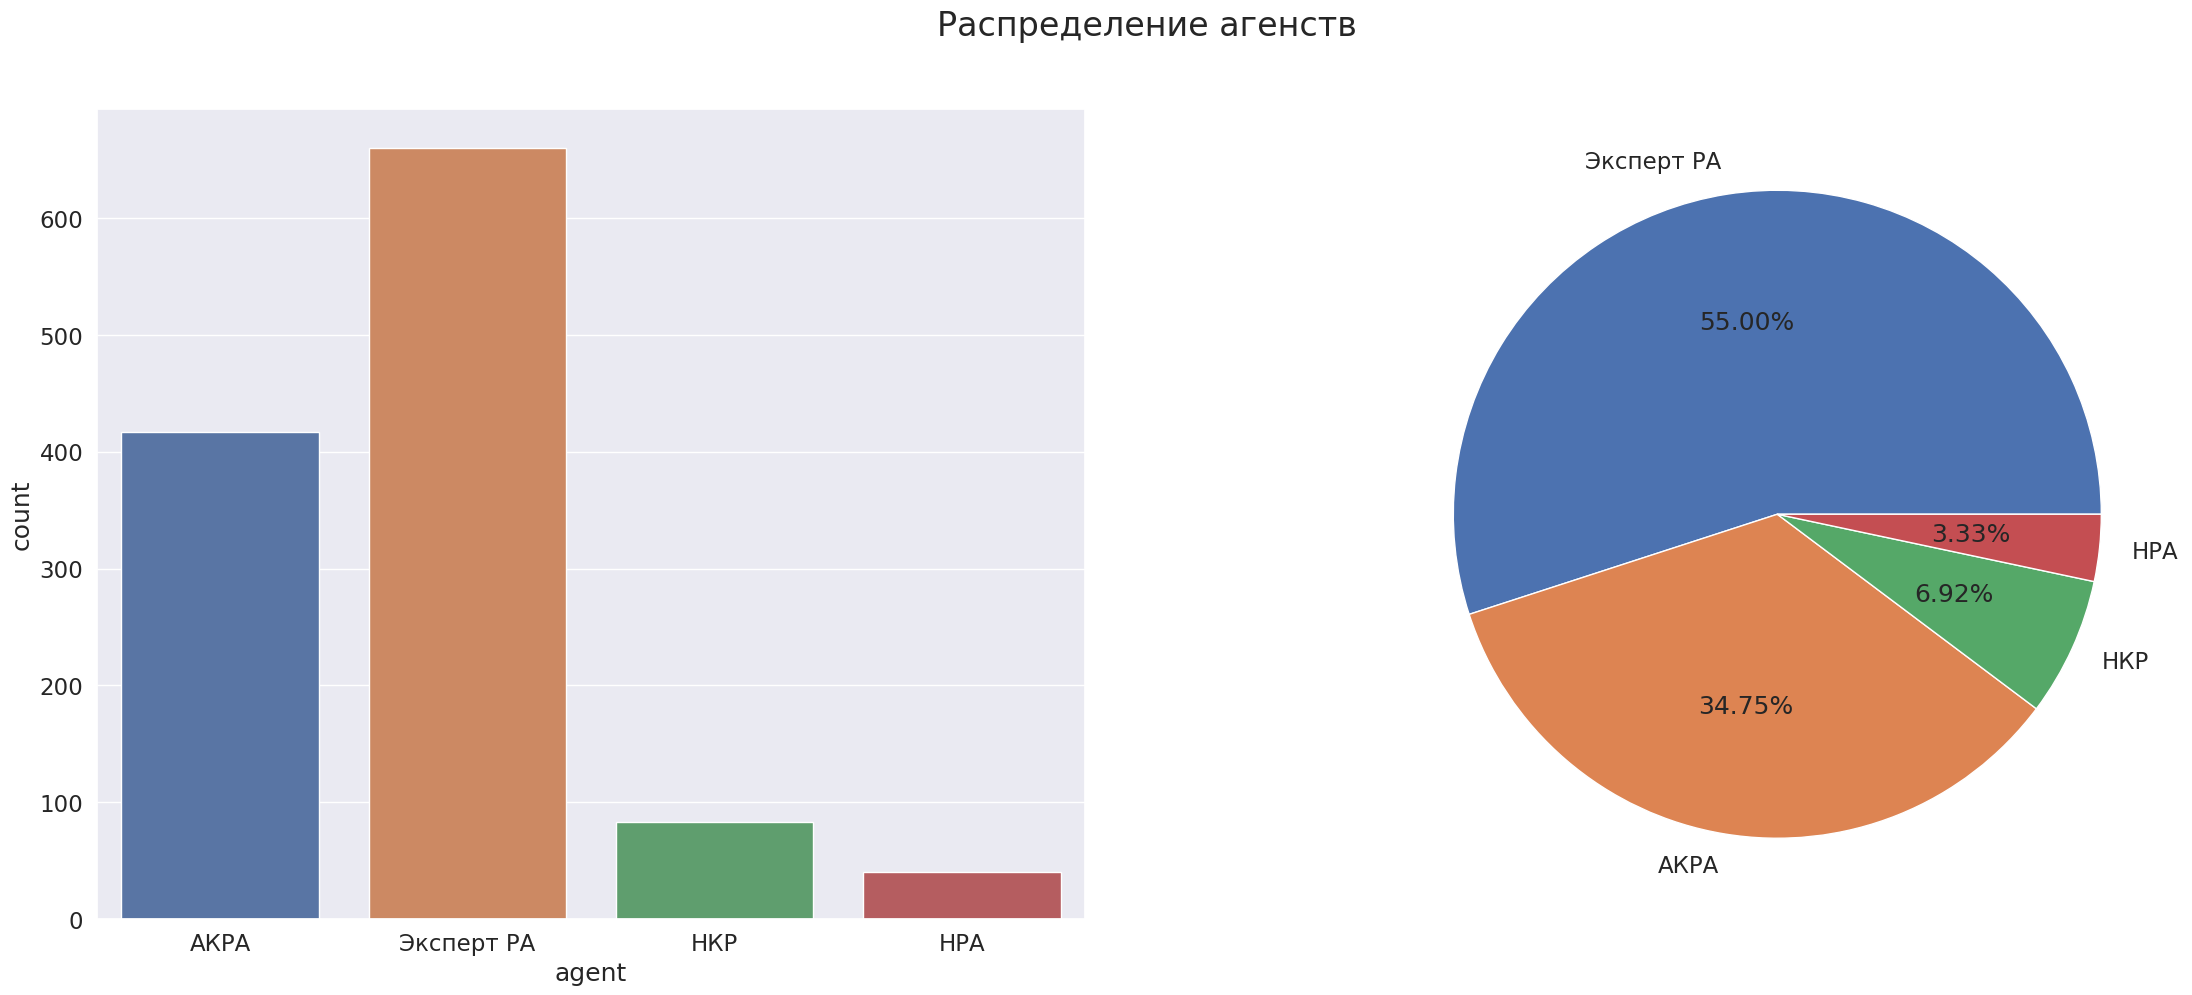

In [354]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 10), dpi=100)
sns.countplot(x=df['agent'], ax=axes[0])
axes[1].pie(x=df['agent'].value_counts(),
            labels=df['agent'].value_counts().index,
            autopct='%1.2f%%',)
            #shadow=True,
            #explode=None,#(0.05, 0)
            #startangle=60)
fig.suptitle('Распределение агенств', fontsize=24)
plt.show()

In [355]:
data = df[df['category'] == 'НРА'].reset_index(drop=True, inplace=False)
data

Empty DataFrame
Columns: [Id, text, category, lvl, agent]
Index: []

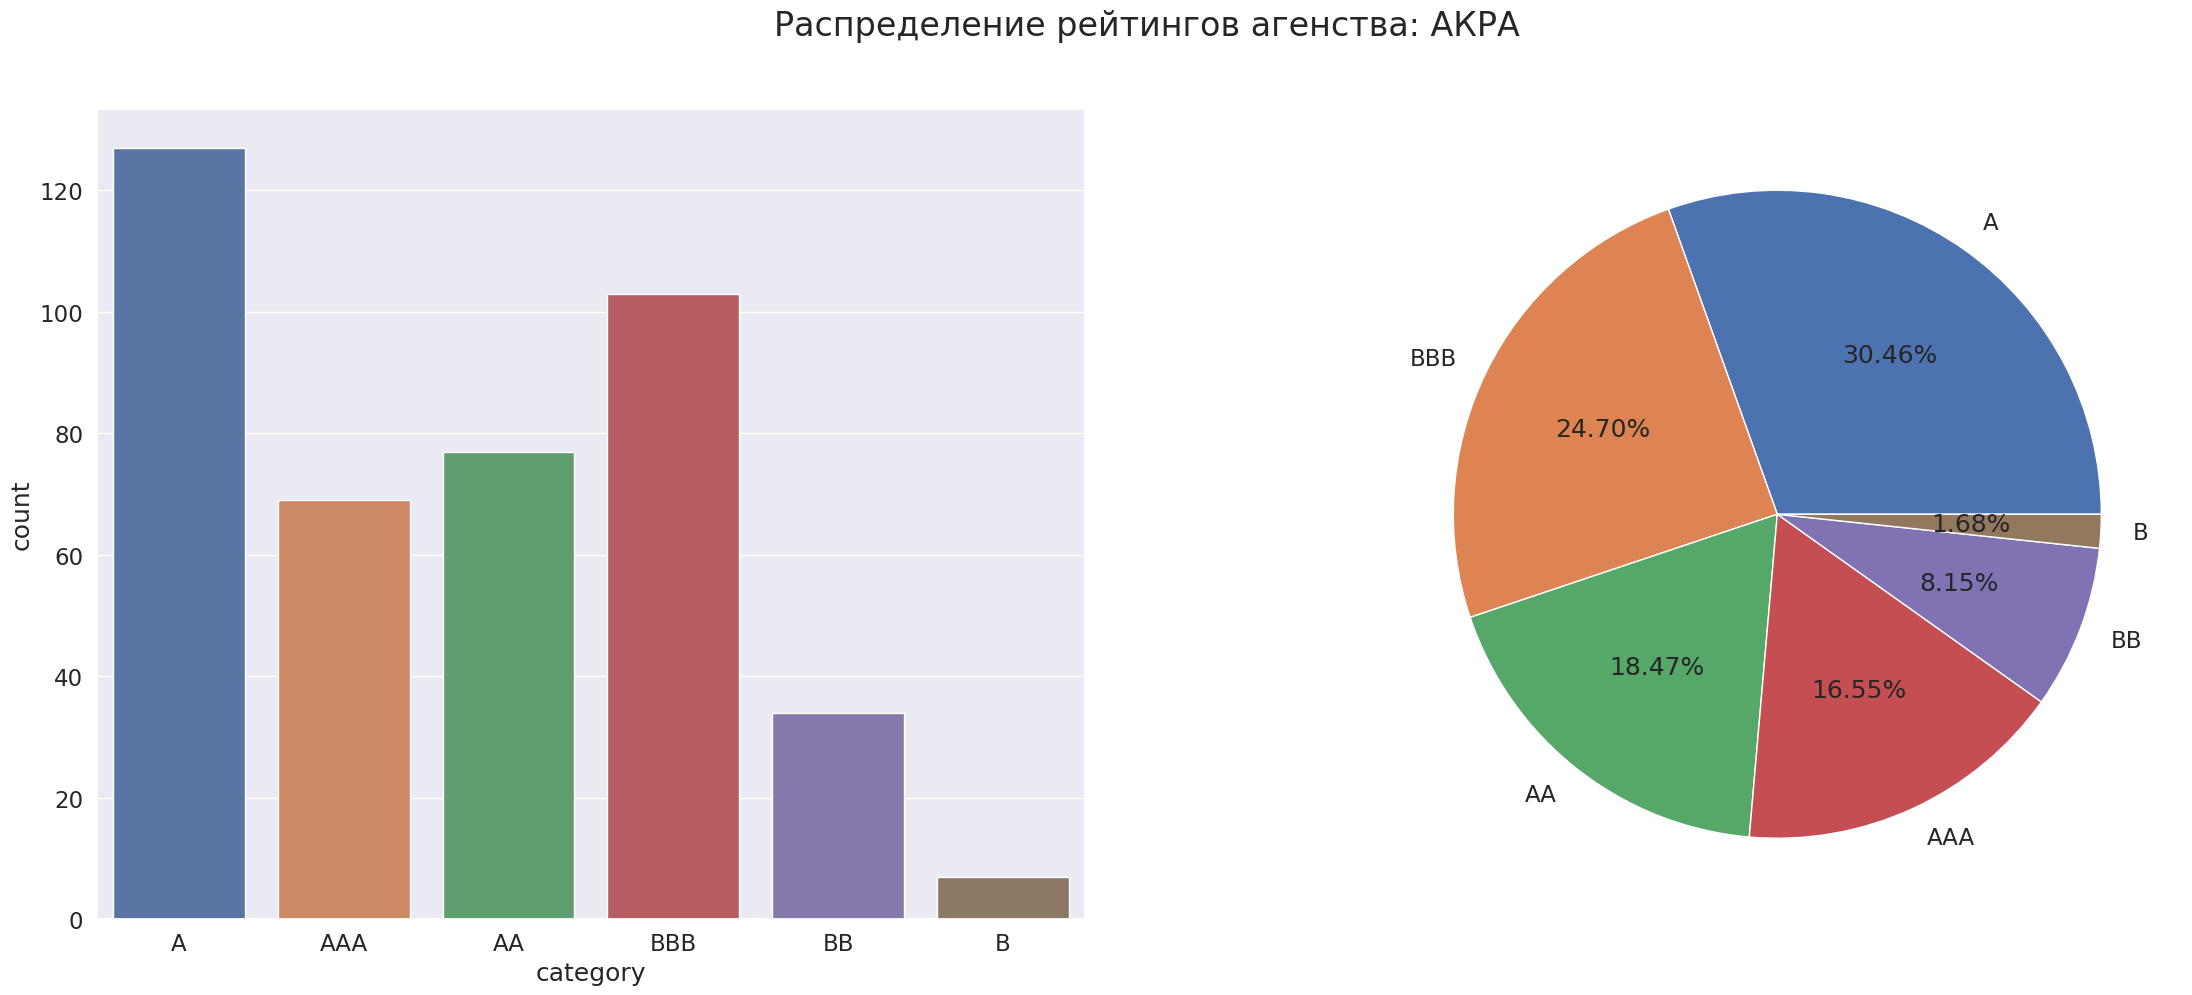

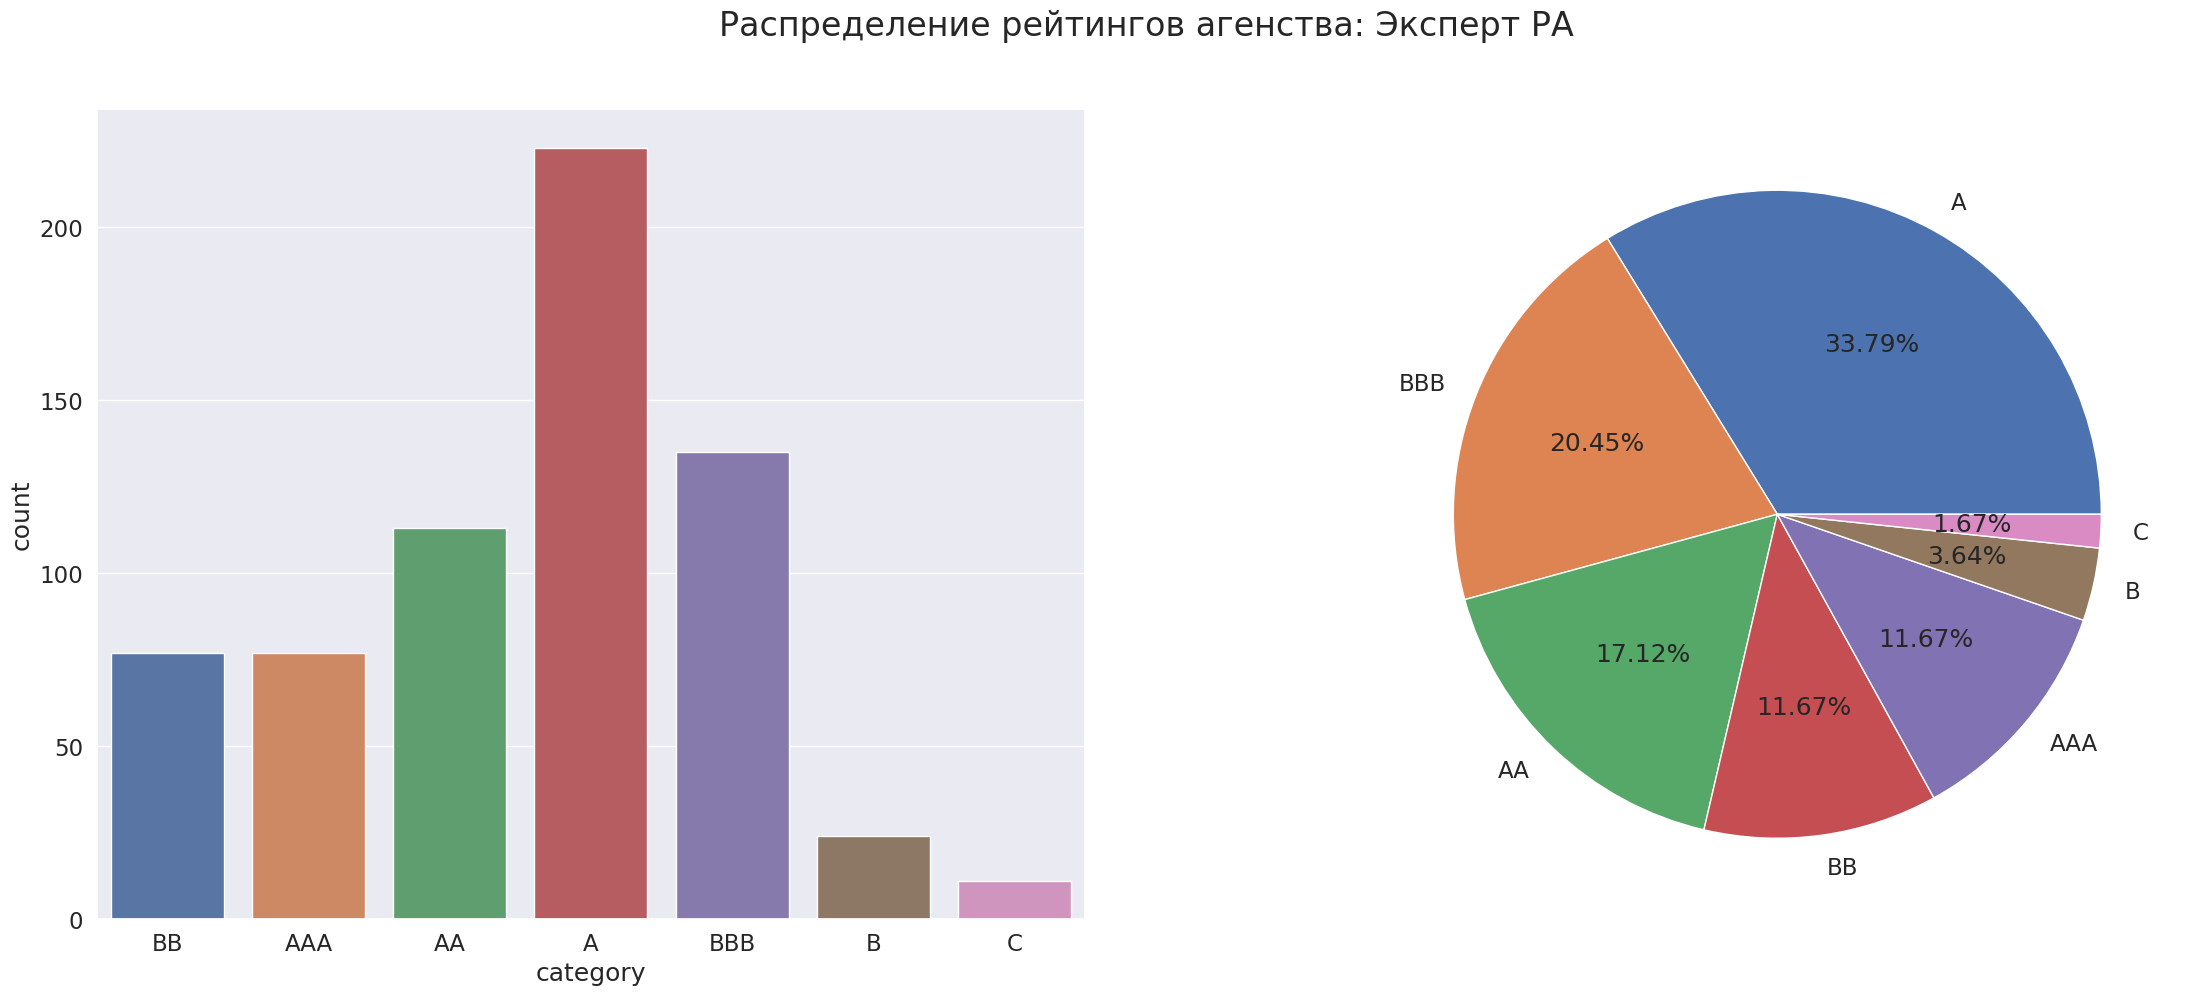

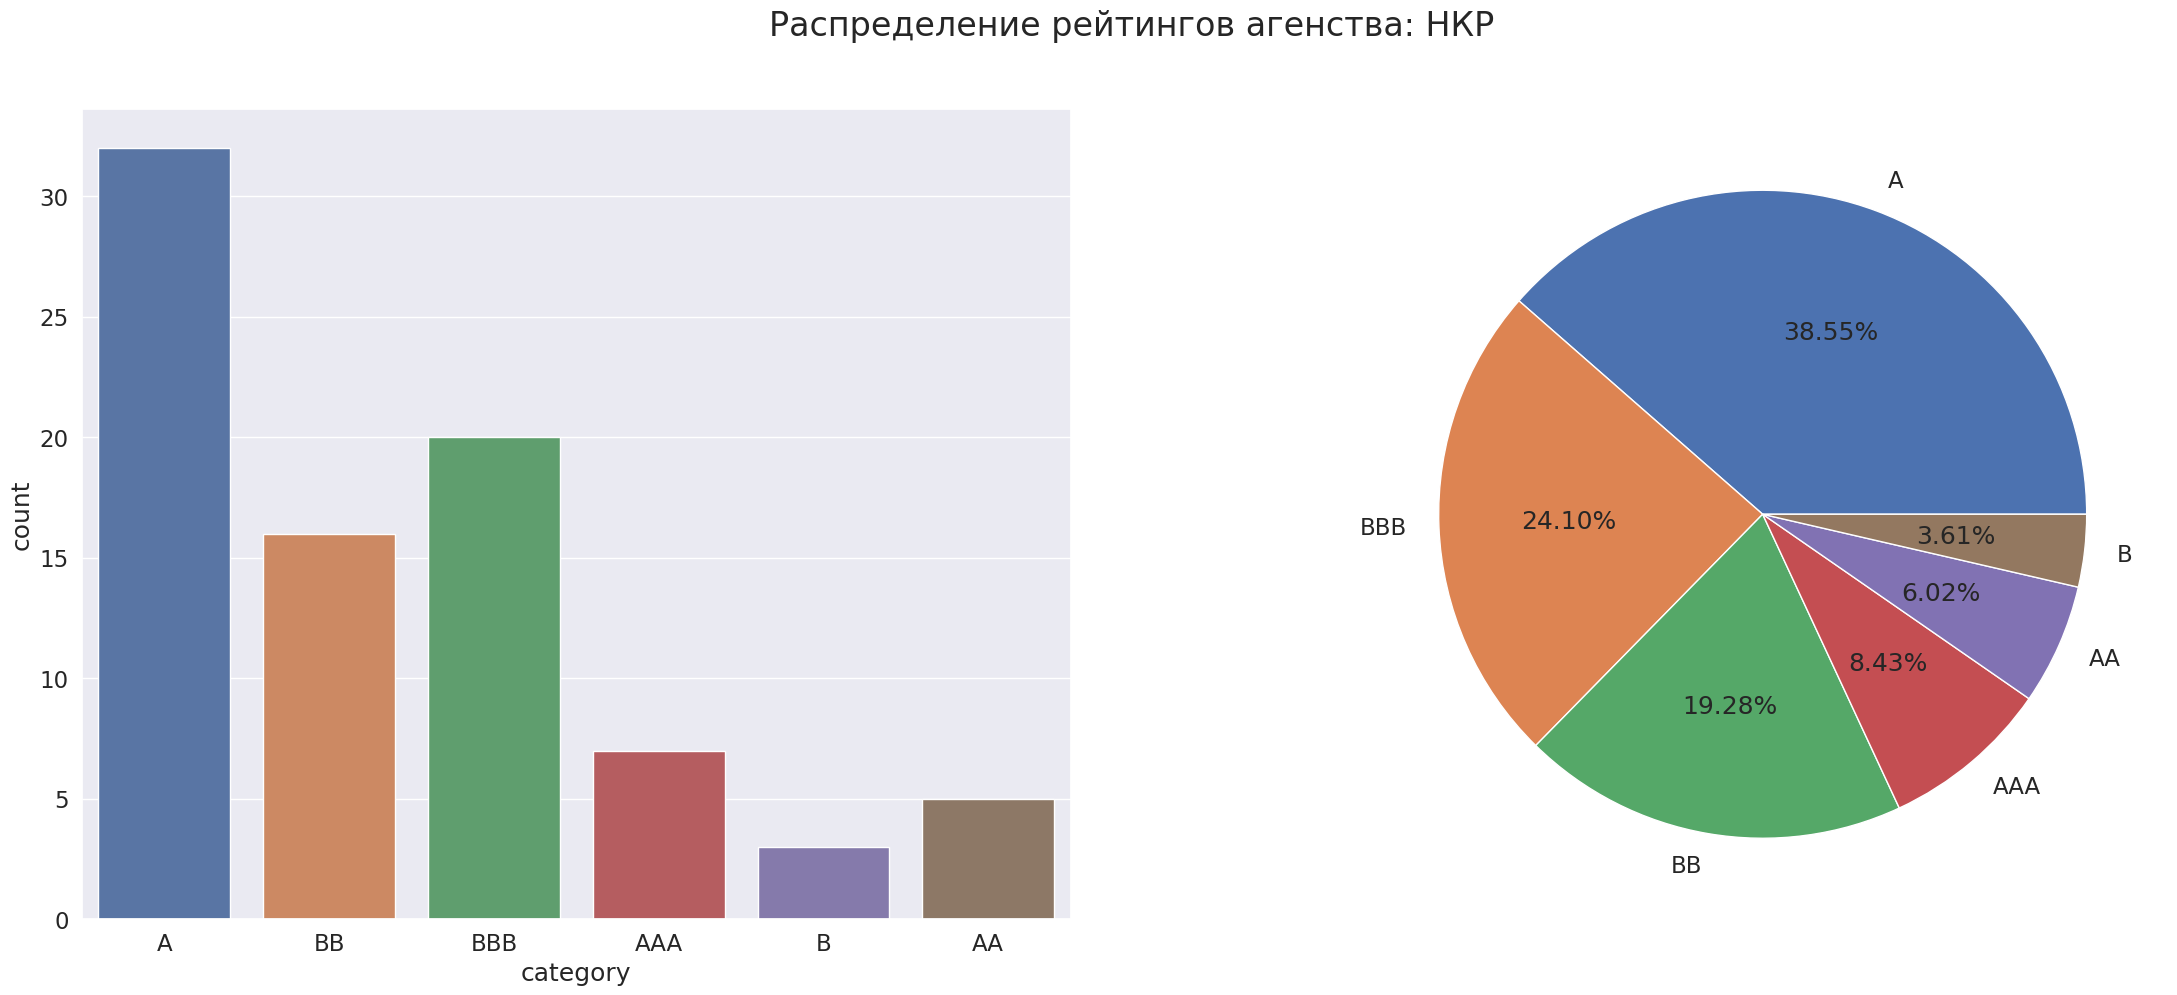

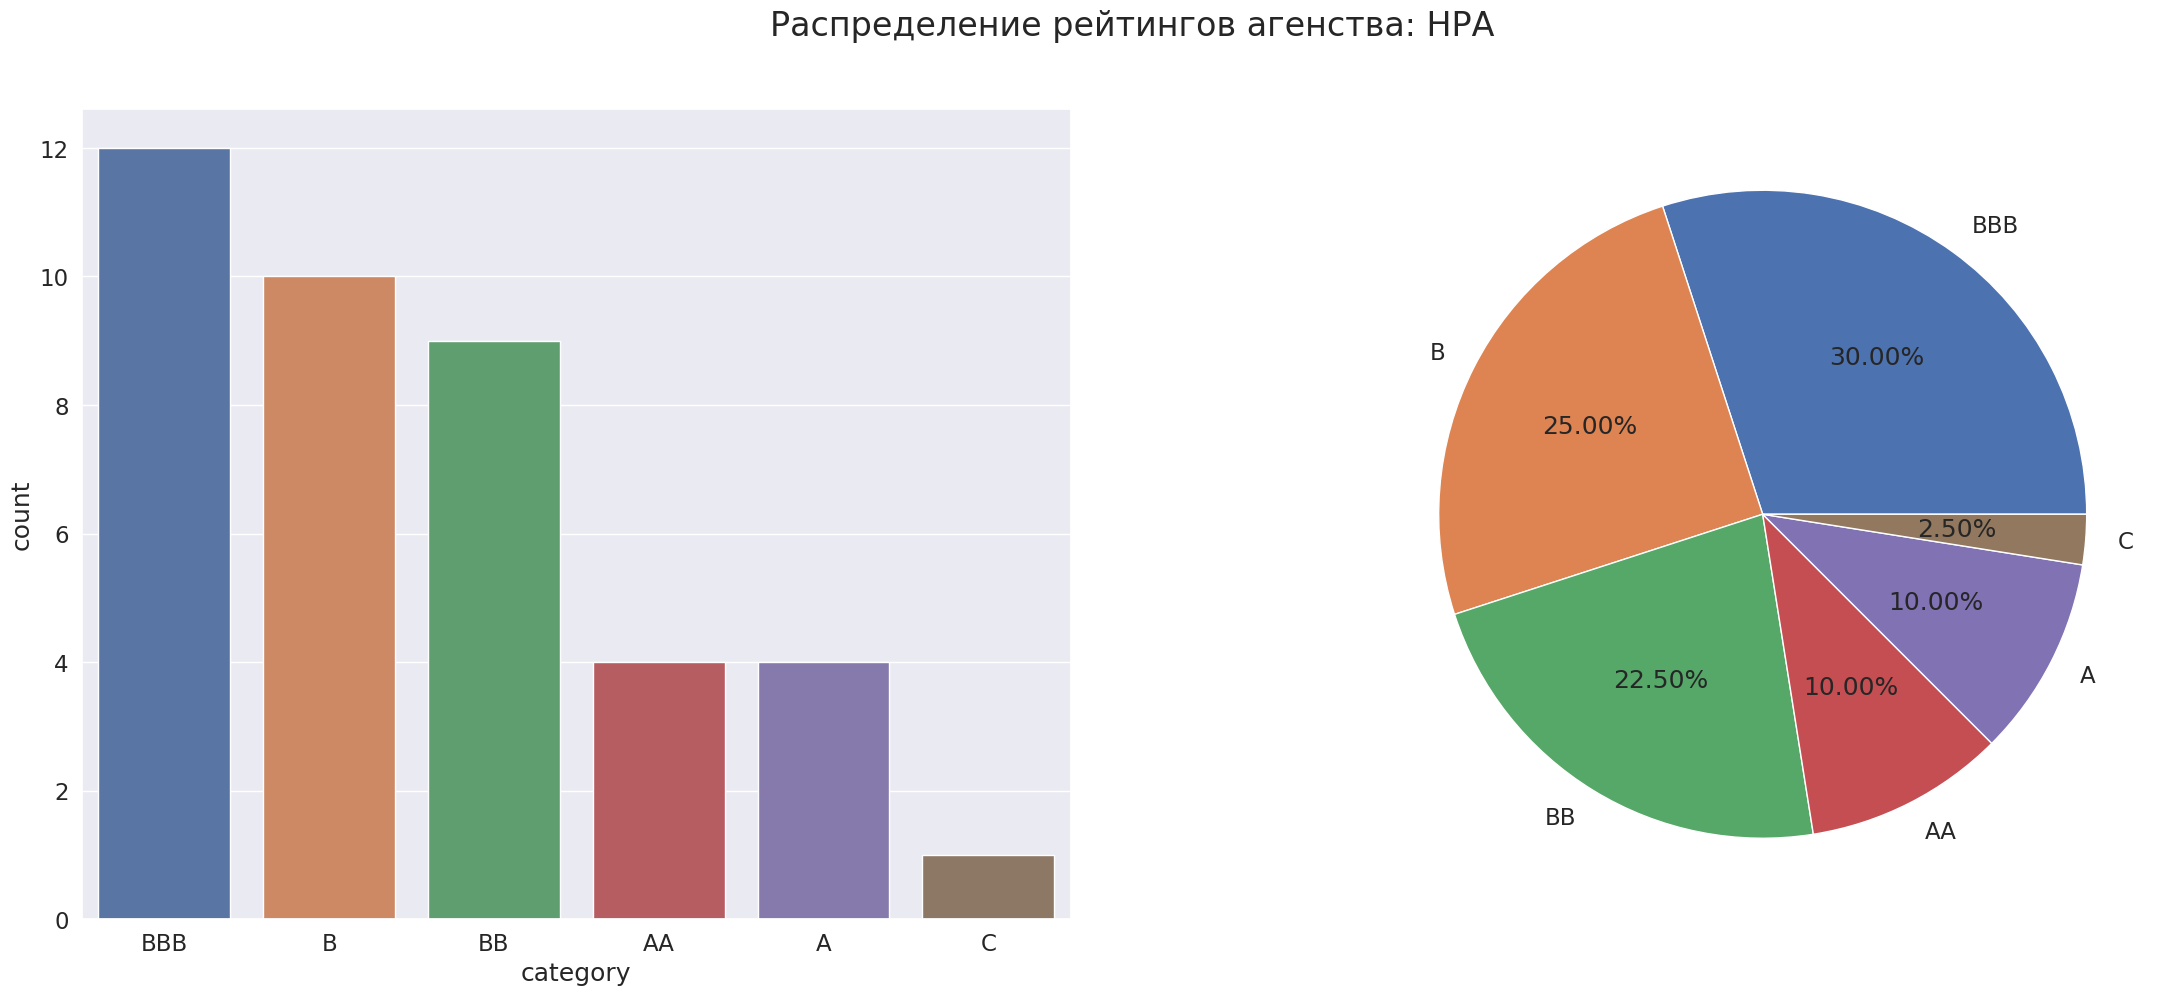

In [356]:
for name in df['agent'].unique():
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 10), dpi=100)
    data = df[df['agent'] == name].reset_index(drop=True)
    data.head()
    sns.countplot(x=data['category'], ax=axes[0])
    axes[1].pie(x=data['category'].value_counts(),
                labels=data['category'].value_counts().index,
                autopct='%1.2f%%',)
                #shadow=True,
                #explode=None,#(0.05, 0)
                #startangle=60)
    fig.suptitle(f'Распределение рейтингов агенства: {name}', fontsize=24)
    plt.show()

#### Вывод: АКРА и НКР дорожат репутацией и не опускаются до компаний с очень низким уровнем кредитоспособности/финансовой надёжности/финансовой устойчивости!

## Чистка данных по каждому рейтинговому агенству

In [357]:
#АКРА
data_acra = df[df['agent'] == 'АКРА'].reset_index(drop=True)

In [358]:
data_acra.head(30)

Id                                               text category   lvl agent
0    1  Повышение кредитного рейтинга  Акционерного об...        A     A  АКРА
1    6  Кредитный рейтинг  ПАО «ФосАгро» (далее — Комп...      AAA   AAA  АКРА
2   10  Кредитный рейтинг  ООО «МВМ»  (далее — Компани...        A     A  АКРА
3   15  Кредитный рейтинг  Акционерного общества «Сина...        A     A  АКРА
4   16  Кредитный рейтинг  ПАО «М.видео» (далее — Груп...        A     A  АКРА
5   18  Кредитный рейтинг  ООО «Брусника. Строительств...        A    A-  АКРА
6   19  Кредитный рейтинг  ООО «Городской супермаркет»...        A    A-  АКРА
7   23  Кредитный рейтинг  Sanymon Corporation Limited...        A    A-  АКРА
8   24  Кредитный рейтинг  АО «Зарубежнефть»  (далее —...      AAA   AAA  АКРА
9   27  Кредитный рейтинг  VK Company Limited (далее —...       AA   AA+  АКРА
10  28  Подтверждение кредитного рейтинга  ПАО «Кокс» ...        A     A  АКРА
11  32  Кредитный рейтинг  ПАО «ВымпелКом» (далее — «В...       AA   AA-  АКРА
12  33  Повышение кредитного рейтинга  ООО «РКС-Холдин...       AA   AA-  АКРА
13  36  Кредитный рейтинг  АО ГК «Азот»  (далее — АО Г...        A    A+  АКРА
14  38  Кредитный рейтинг  Публичного акционерного общ...        A    A+  АКРА
15  40  Подтверждение кредитного рейтинга  ООО «Планет...        A    A-  АКРА
16  43  Кредитный рейтинг  ПАО «Газпром» (далее — Газп...      AAA   AAA  АКРА
17  44  Подтверждение кредитного рейтинга  ПАО «Распад...       AA   AA+  АКРА
18  45  Кредитный рейтинг  АО «Коммерческая недвижимос...      BBB  BBB-  АКРА
19  46  Кредитный рейтинг  ПАО «Европейская Электротех...      BBB   BBB  АКРА
20  47  Повышение кредитного рейтинга  ПАО «ГК «Самоле...        A     A  АКРА
21  50  Кредитный рейтинг  Yandex N.V.  (далее — Yande...       AA   AA+  АКРА
22  51  Изменение прогноза по кредитному рейтингу  ПАО...      BBB  BBB+  АКРА
23  52  Собственная кредитоспособность  ПАО «НК «Росне...      AAA   AAA  АКРА
24  55  Кредитный рейтинг  ООО «Левел Груп» (далее — К...        A    A-  АКРА
25  58  Подтверждение кредитного рейтинга  АО «Лаут»  ...       BB    BB  АКРА
26  59  Кредитный рейтинг  ООО «Электрощит-Стройсистем...       BB   BB+  АКРА
27  60  Кредитный рейтинг  ПАО «ЧЗПСН-Профнастил»  (да...       BB   BB+  АКРА
28  61  Кредитный рейтинг  ООО ТАМИ И КО (далее — HEND...      BBB  BBB+  АКРА
29  62  Подтверждение кредитного рейтинга  ПАО «Россет...       AA   AA+  АКРА

In [5]:
def search_words(words, sroka):
    
    for i, w in enumerate(words):
        sroka = sroka.lower()
        res = re.search(w, sroka)
        if res:
            if i == 0:
                sroka = sroka[:res.start()]
            else:
                sroka = sroka[:max(res.start()+600, len(sroka))]
    return sroka


In [360]:
def search_words_akra(words, sroka):
    
    for i, w in enumerate(words):
        sroka_lower = sroka.lower()
        res = re.search(w, sroka_lower)
        if res:
            if i == 0:
                sroka = sroka[:res.start()]
            else:
                sroka = sroka[:max(res.start()+600, len(sroka))]
    return sroka

In [6]:
def search_words_count(word, sroka):
    res = re.search(word, sroka)
    if res:
        return 'Есть'
    else:
        return 'Нет'

In [362]:
stop_word_acra = ['регуляторное раскрытие', 'рейтинги выпусков', 'обоснование кредитного рейтинга']

In [363]:
data_acra['text'] = data_acra['text'].apply(lambda x: search_words_akra(stop_word_acra, x))

In [ ]:
data_acra['text'][111]

In [365]:
data_acra.to_csv('AKRA.csv')

In [232]:
r = search_words(word, data_acra['text'][5].lower())

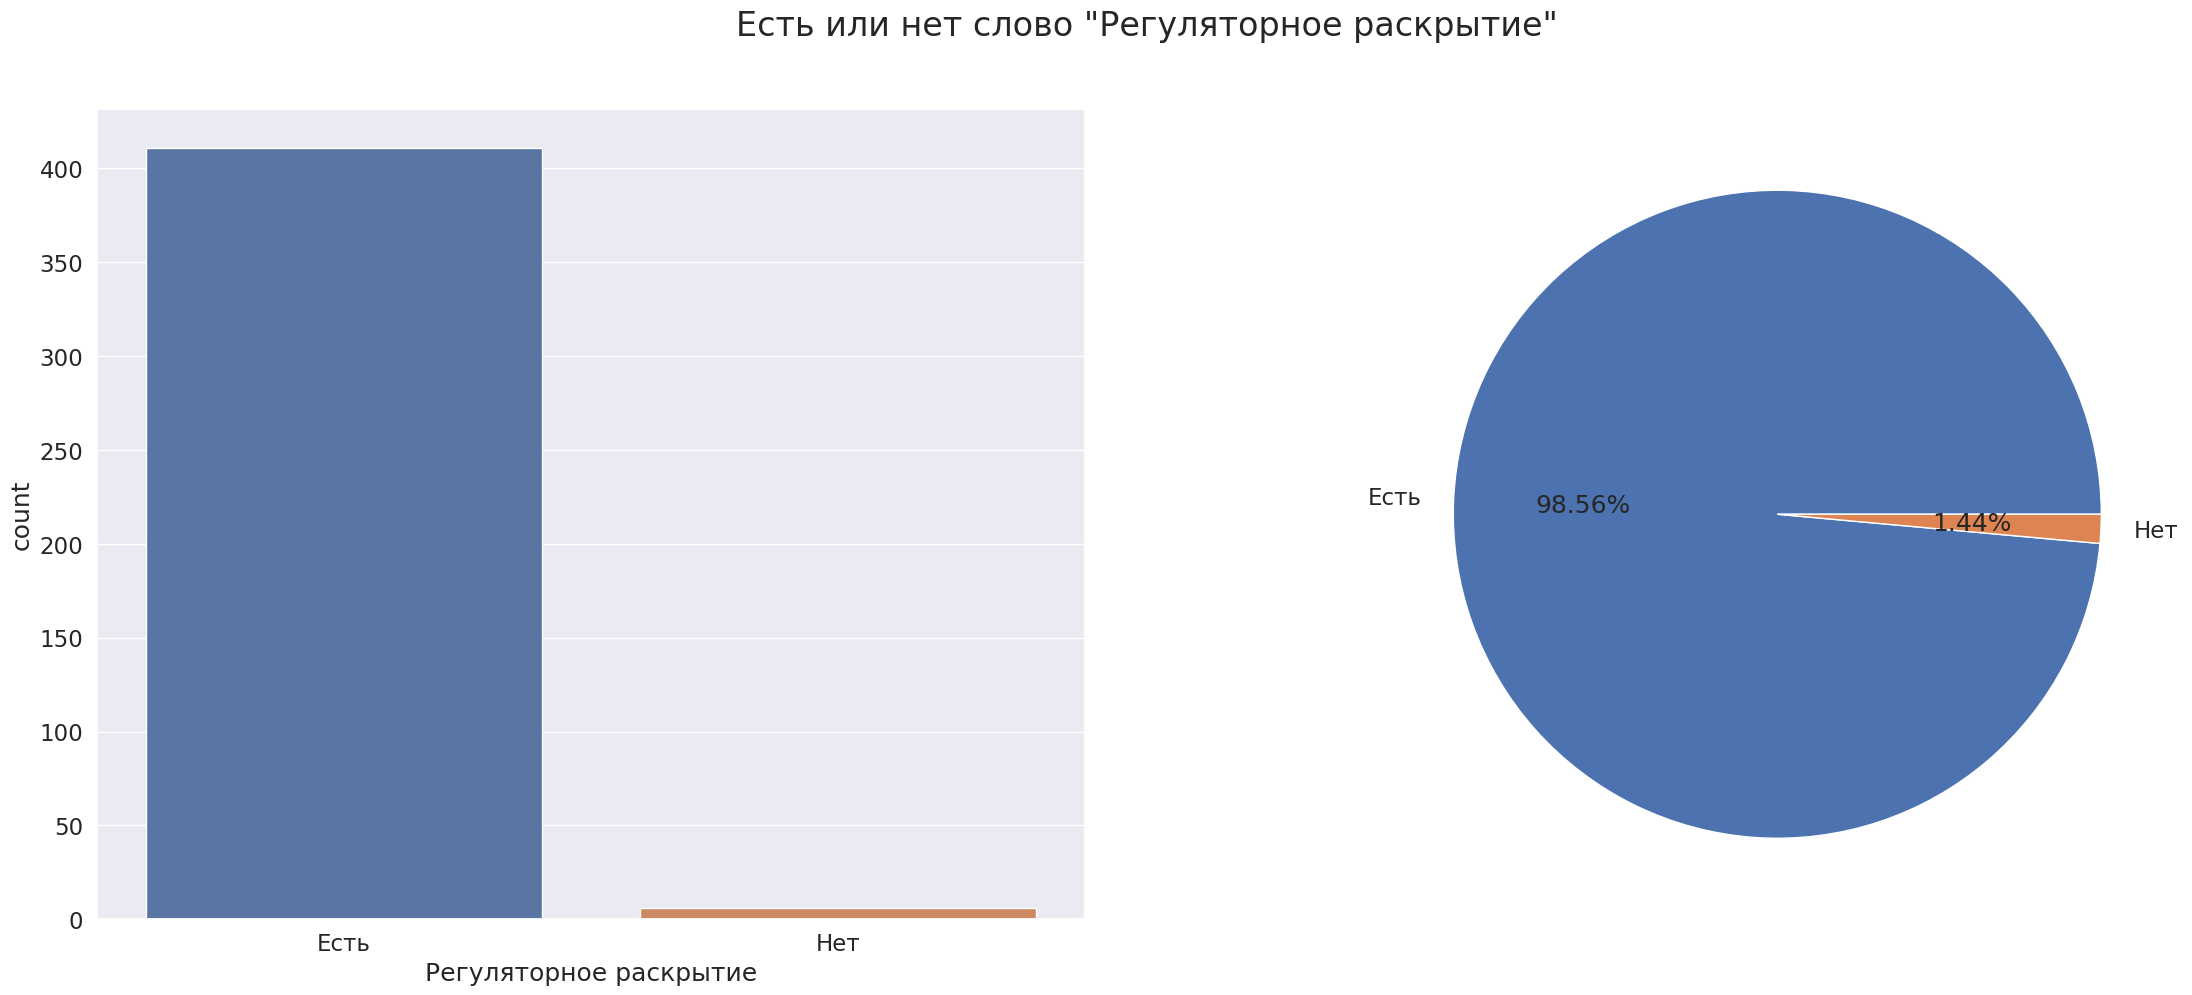

In [233]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 10), dpi=100)
sns.countplot(x=data_acra[word], ax=axes[0])
axes[1].pie(x=data_acra[word].value_counts(),
            labels=data_acra[word].value_counts().index,
            autopct='%1.2f%%',)
            #shadow=True,
            #explode=None,#(0.05, 0)
            #startangle=60)
fig.suptitle(f'Есть или нет слово "{word}"', fontsize=24)
plt.show()

In [234]:
data_acra['text']

0      Повышение кредитного рейтинга  Акционерного об...
1      Кредитный рейтинг  ПАО «ФосАгро» (далее — Комп...
2      Кредитный рейтинг  ООО «МВМ»  (далее — Компани...
3      Кредитный рейтинг  Акционерного общества «Сина...
4      Кредитный рейтинг  ПАО «М.видео» (далее — Груп...
                             ...                        
412    АКРА подтвердило кредитный рейтинг Государстве...
413    АКРА присвоило АО «Загорский трубный завод» кр...
414    АКРА повысило кредитный рейтинг ООО «Т2 РТК Хо...
415    АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...
416    АКРА подтвердило кредитный рейтинг ФГУП «Почта...
Name: text, Length: 417, dtype: object

In [243]:
not_this_group = data_acra[data_acra[word] == "Нет" ].reset_index(drop=True)
not_this_group

Id                                               text category   lvl  \
0   52  Собственная кредитоспособность  ПАО «НК «Росне...      AAA   AAA   
1  205  Кредитный рейтинг  X5 Retail Group N.V.  (дале...      AAA   AAA   
2  398  Кредитный рейтинг  ООО «МВМ»  (далее — Компани...        A    A+   
3  601  Кредитный рейтинг  ПАО «Абрау - Дюрсо»  (далее...        A     A   
4  903  Кредитный рейтинг  ООО «;РТ - Развитие бизнеса...      BBB  BBB+   
5  987  АКРА присвоило Rissa Investments Limited креди...        A    A-   

  agent рейтинги выпусков Регуляторное раскрытие  
0  АКРА               Нет                    Нет  
1  АКРА               Нет                    Нет  
2  АКРА               Нет                    Нет  
3  АКРА               Нет                    Нет  
4  АКРА               Нет                    Нет  
5  АКРА               Нет                    Нет

In [244]:
РЕГУЛЯТОРНОЕ РАСКРЫТИЕ
Рейтинги выпусков  Кредитный рейтинг
Рейтинги выпусков
КЛЮЧЕВЫЕ ХАРАКТЕРИСТИКИ ВЫПУСКОВ
Ключевые характеристики выпусков

SyntaxError: invalid syntax (1983780642.py, line 1)

In [ ]:
not_this_group['text'][1]

In [197]:
word2 = 'РЕГУЛЯТОРНОЕ РАСКРЫТИЕ'.lower()

In [254]:
len("""Рейтинги выпусков  Обоснование кредитного рейтинга.  Перечисленные ниже эмиссии являются старшим необеспеченным долгом ПАО «НК «Роснефть». По причине отсутствия структурной и контрактной субординации выпусков АКРА оценивает эти облигации как равные по очередности исполнения другим существующим и будущим необеспеченным и несубординированным обязательствам ПАО «НК «Роснефть». В соответствии с методологией АКРА кредитный рейтинг эмиссий приравнивается к кредитному рейтингу ПАО «НК «Роснефть» — <rating>.  Ключевые характеристики выпусков    Заемщик / фактический эмитент по всем выпускам  ПАО «НК «Роснефть»  (кредитный рейтинг эмитента  <rating>, прогноз «Стабильный» ).""")

673

In [372]:
#Эксперт РА
data_exc = df[df['agent'] == 'Эксперт РА'].reset_index(drop=True)

In [ ]:
data_exc['text'][66]

In [368]:
data_exc.head(30)

Id                                               text category   lvl  \
0    2  «Эксперт РА» подтвердил кредитный рейтинг комп...       BB    BB   
1    4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...      AAA   AAA   
2    7  «Эксперт РА» повысил кредитный рейтинг ОАО «МР...       AA   AA+   
3    8  «Эксперт РА» понизил кредитный рейтинг ПАО «М....        A     A   
4    9  «Эксперт РА» повысил кредитный рейтинг компани...       BB   BB+   
5   11  «Эксперт РА» подтвердил кредитный рейтинг комп...      AAA   AAA   
6   12  «Эксперт РА» присвоил кредитный рейтинг АО «Но...        A     A   
7   17  «Эксперт РА» подтвердил кредитный рейтинг ООО ...        A    A-   
8   20  «Эксперт РА» повысил кредитный рейтинг АО «РОЛ...        A    A+   
9   22  «Эксперт РА» повысил кредитный рейтинг АО «МХК...       AA   AA+   
10  25  «Эксперт РА» подтвердил кредитный рейтинг комп...       BB   BB+   
11  26  «Эксперт РА» подтвердил кредитный рейтинг ООО ...        A    A-   
12  34  «Эксперт РА» присвоил кредитный рейтинг АО ГК ...        A    A-   
13  35  «Эксперт РА» присвоил кредитный рейтинг АО «ГК...        A    A+   
14  39  «Эксперт РА» подтвердил кредитный рейтинг ПАО ...      AAA   AAA   
15  41  «Эксперт РА» подтвердил рейтинг кредитоспособн...      BBB   BBB   
16  42  «Эксперт РА» присвоил рейтинг компании «Уральс...        A    A-   
17  48  «Эксперт РА» присвоил кредитный рейтинг АО «Со...      BBB  BBB+   
18  53  «Эксперт РА» подтвердил кредитный рейтинг ПАО ...       BB   BB+   
19  56  «Эксперт РА» подтвердил кредитный рейтинг ПАО ...        A     A   
20  63  «Эксперт РА» присвоил кредитный рейтинг ООО «М...        B    B-   
21  64  «Эксперт РА» пересмотрел рейтинг ППК «Российск...        A    A+   
22  65  «Эксперт РА» подтвердил кредитный рейтинг Russ...        A    A+   
23  66  «Эксперт РА» подтвердил кредитный рейтинг АО «...        A    A+   
24  67  «Эксперт РА» присвоил рейтинг Simidella Limite...      BBB  BBB+   
25  69  «Эксперт РА» присвоил кредитный рейтинг АО «Пр...       AA    AA   
26  70  «Эксперт РА» подтвердил кредитный рейтинг ООО ...        B    B+   
27  71  «Эксперт РА» подтвердил кредитный рейтинг АО «...      AAA   AAA   
28  72  «Эксперт РА» снял статус «под наблюдением» по ...      BBB  BBB+   
29  75  «Эксперт РА» пересмотрел кредитный рейтинг АО ...      AAA   AAA   

         agent  
0   Эксперт РА  
1   Эксперт РА  
2   Эксперт РА  
3   Эксперт РА  
4   Эксперт РА  
5   Эксперт РА  
6   Эксперт РА  
7   Эксперт РА  
8   Эксперт РА  
9   Эксперт РА  
10  Эксперт РА  
11  Эксперт РА  
12  Эксперт РА  
13  Эксперт РА  
14  Эксперт РА  
15  Эксперт РА  
16  Эксперт РА  
17  Эксперт РА  
18  Эксперт РА  
19  Эксперт РА  
20  Эксперт РА  
21  Эксперт РА  
22  Эксперт РА  
23  Эксперт РА  
24  Эксперт РА  
25  Эксперт РА  
26  Эксперт РА  
27  Эксперт РА  
28  Эксперт РА  
29  Эксперт РА

In [369]:
data_exc['text'][0]

'«Эксперт РА» подтвердил кредитный рейтинг компании ООО «Энергоконцепции» на уровне <rating>  Москва, 31 марта  2023 г.  Рейтинговое агентство «Эксперт РА» подтвердило  рейтинг кредитоспособности  нефинансовой компании   ООО «Энергоконцепции»   на уровне <rating>. Прогноз по рейтингу – стабильный. ") ООО «Энергоконцепции» (далее – «компания») –  российская компания, занимающаяся поставкой, монтажом и обслуживанием  энергетического оборудования. Основные клиенты представлены производителями  тепловой и электрической энергии группы компаний ООО «Газпром энергохолдинг»  (<rating>, стаб.).   Агентство оценивает риск-профиль отрасли, в  которой компания ведет деятельность, нейтрально. Платежеспособность основных  клиентов компании находится на высоком уровне. Устойчивость к внешним шокам  оценивается агентством на среднем уровне, т.к. спрос на продукцию и услуги ООО  «Энергоконцепции» подвержен колебаниям экономических циклов. Барьеры для входа  находятся на умеренно низком уровне.   Рыночн

In [370]:
word = 'Контакты для СМИ:'.lower()
data_exc[word] = data_exc['text'].apply(lambda x: search_words_count(word, x.lower()))

In [371]:
data_exc['text'][111]

'«Эксперт РА» подтвердил кредитный рейтинг АО «Р-Фарм» на уровне <rating>  Москва,  24 августа 2022 г.  Рейтинговое агентство «Эксперт РА» подтвердило  рейтинг кредитоспособности  нефинансовой компании   АО «Р-Фарм»   на уровне <rating>. Прогноз по рейтингу – стабильный.  ") АО  «Р-Фарм» (далее – компания) специализируется на исследованиях, разработке,  производстве лекарственных средств, лабораторного оборудования и медицинской  техники.  Агентство  оценивает рыночные и конкурентные позиции компании на высоком уровне.  Р-Фарм является крупнейшим фармацевтическим  дистрибутором и производителем в госпитальном секторе с долями рынка. По итогам  2021 года (далее - отчетный период) компания существенно укрепила свои рыночные  позиции и вошла в топ-15 производителей среди российских и иностранных  фармацевтических компаний. Выручка за отчетный период составила 183 млрд руб.,  увеличившись более чем на 50% по сравнению с уровнем прошлого года.  Существенный рост продаж обусловлен повышенным

In [ ]:
r = search_words(word, data_acra['text'][5].lower())

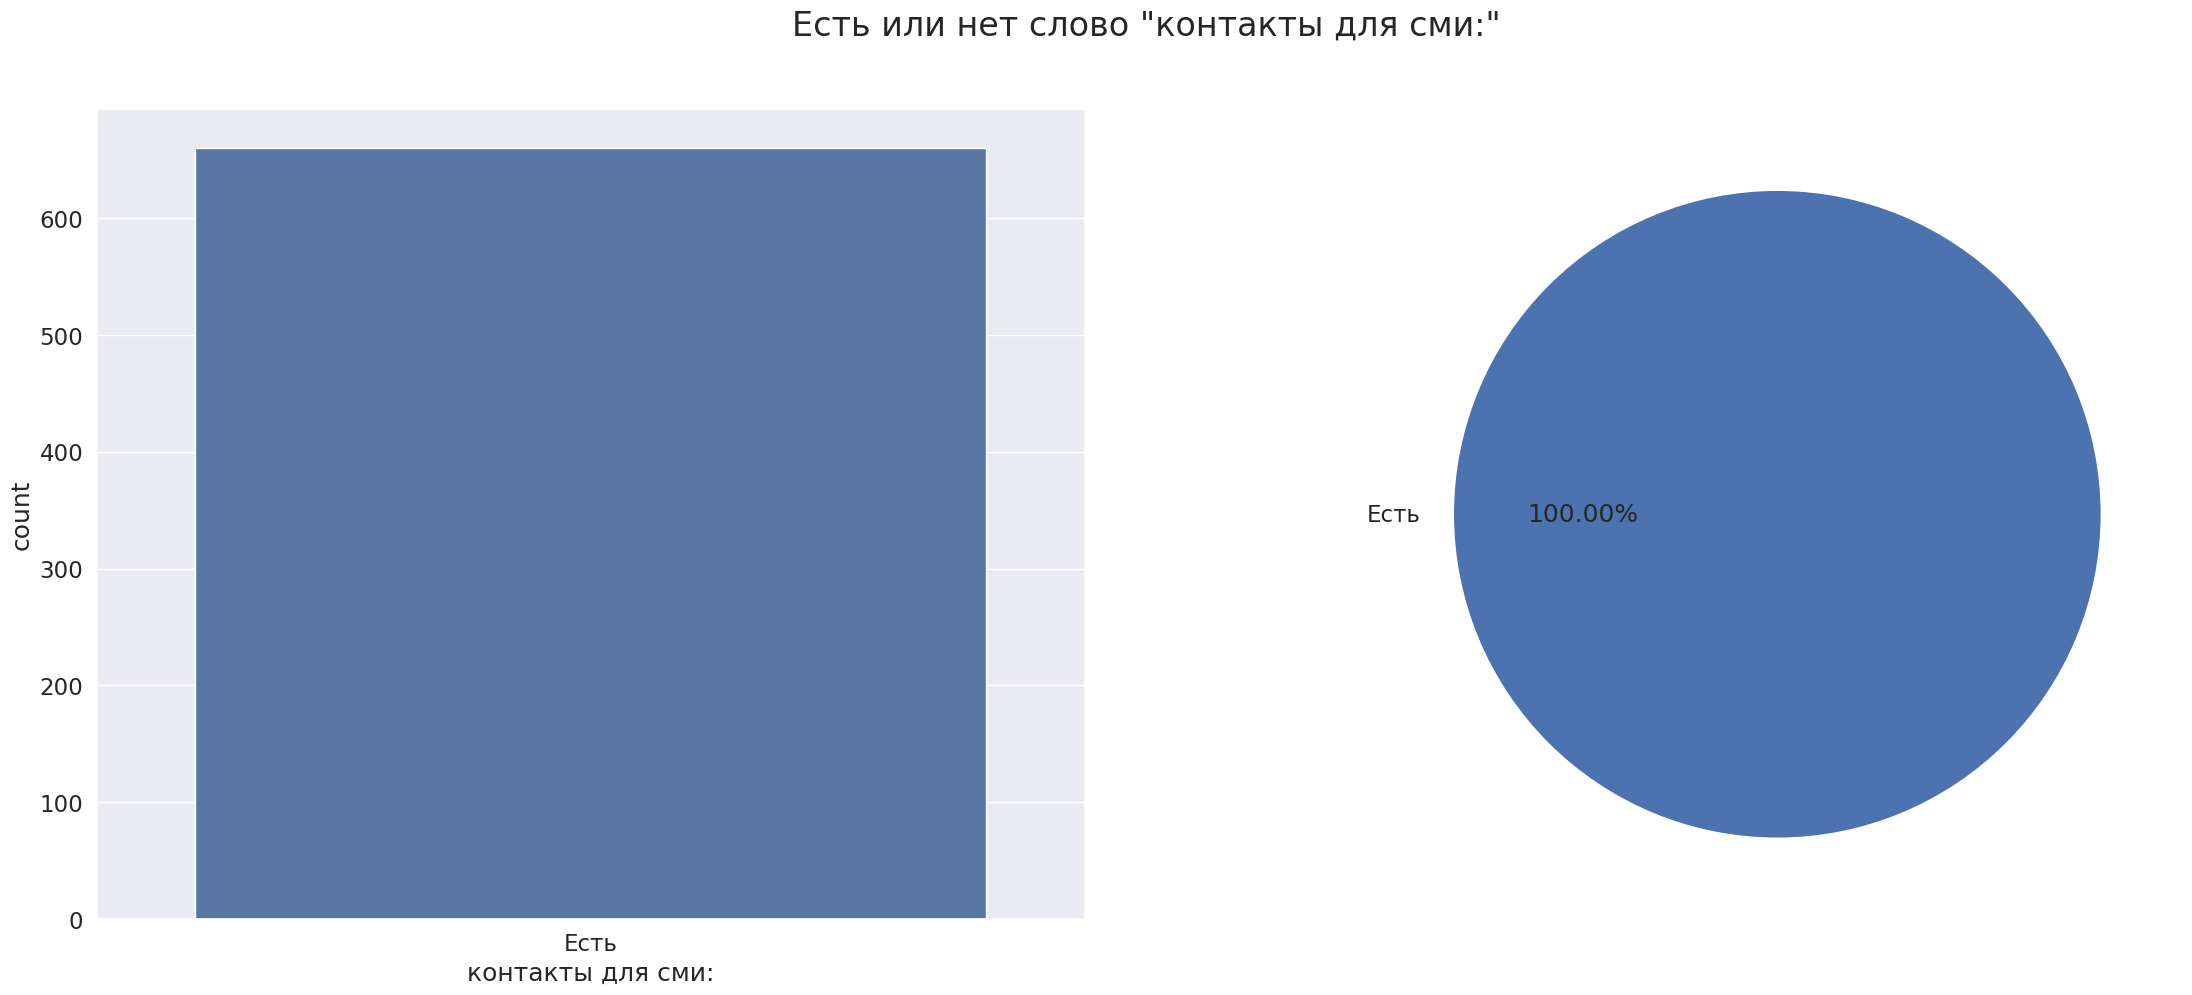

In [302]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 10), dpi=100)
sns.countplot(x=data_exc[word], ax=axes[0])
axes[1].pie(x=data_exc[word].value_counts(),
            labels=data_exc[word].value_counts().index,
            autopct='%1.2f%%',)
            #shadow=True,
            #explode=None,#(0.05, 0)
            #startangle=60)
fig.suptitle(f'Есть или нет слово "{word}"', fontsize=24)
plt.show()

In [374]:
data_exc_stop = ['Контакты для СМИ:'.lower()]

In [375]:
data_exc['text'] = data_exc['text'].apply(lambda x: search_words_akra(data_exc_stop, x))

In [376]:
data_exc['text'][22]

'«Эксперт РА» подтвердил кредитный рейтинг Russian Copper Company Limited на уровне <rating> и установил развивающийся прогноз   Москва,  29 декабря 2022 г.  Рейтинговое агентство «Эксперт РА» подтвердило  рейтинг кредитоспособности  нефинансовой компании   Russian Copper Company Limited   на уровне <rating> и изменило прогноз со стабильного на развивающийся. ") Russian Copper  Company  Limited  является материнской компанией для вертикально интегрированной горнодобывающей и металлургической  группы компаний (Группа «Русская медная компания»,  далее – Группа), являющейся одним из крупнейших производителей  меди в России. Предприятия Группы выпускают медный и цинковый концентрат,  катодную медь, медную катанку, медную фольгу, золото и серебро.   Установление развивающегося прогноза  обусловлено потенциальным риском ухудшения средних оценок метрик блока  финансовых рисков в случае переноса реализации текущих инвестиционных проектов  и риском отклонения показателей долговой и процентной н

In [377]:
data_exc

Id                                               text category  lvl  \
0       2  «Эксперт РА» подтвердил кредитный рейтинг комп...       BB   BB   
1       4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...      AAA  AAA   
2       7  «Эксперт РА» повысил кредитный рейтинг ОАО «МР...       AA  AA+   
3       8  «Эксперт РА» понизил кредитный рейтинг ПАО «М....        A    A   
4       9  «Эксперт РА» повысил кредитный рейтинг компани...       BB  BB+   
..    ...                                                ...      ...  ...   
655  1205  «Эксперт РА» подтвердил рейтинг компании «Энел...       AA   AA   
656  1206  «Эксперт РА» подтвердил рейтинг компании «Этал...        A    A   
657  1207  «Эксперт РА» подтвердил рейтинг компании «Татн...      AAA  AAA   
658  1208  «Эксперт РА» понизил рейтинг компании «Инвестг...       BB   BB   
659  1211  «Эксперт РА» подтвердил рейтинг компании «СИБИ...       BB  BB+   

          agent  
0    Эксперт РА  
1    Эксперт РА  
2    Эксперт РА  
3    Эксперт РА  
4    Эксперт РА  
..          ...  
655  Эксперт РА  
656  Эксперт РА  
657  Эксперт РА  
658  Эксперт РА  
659  Эксперт РА  

[660 rows x 5 columns]

In [378]:
data_exc.to_csv('excpert.csv')

In [403]:
#Эксперт РА
data_nkr = df[df['agent'] == 'НКР'].reset_index(drop=True)

In [400]:
data_nkr['text'][66]

'НКР подтвердило кредитный рейтинг ПАО "ГК "Самолет" на уровне <rating>, прогноз изменён на позитивный 2 июня 2021 года Структура рейтинга Структура БОСК БОСК1 a- ОСК a-.ru Экстраординарная поддержка - Кредитный рейтинг <rating> Прогноз позитивный 1 Базовая оценка собственной кредитоспособности Рейтинговое агентство НКР подтвердило кредитный рейтинг ПАО "Группа компаний "Самолет"" (далее - "Самолет", "компания") на уровне <rating>, прогноз изменён со стабильного на позитивный. Резюме * Позитивный прогноз отражает ожидаемое НКР улучшение рыночных позиций компании за счёт наращивания объёмов строительства, а также улучшение устойчивости финансового профиля по мере успешного завершения начатых проектов и соответствующего раскрытия эскроу-счетов. * Давление на оценку бизнес-профиля оказывают риски снижения темпов роста первичного рынка жилья в РФ вследствие стагнации реальных доходов населения и повышения процентных ставок. * Финансовый профиль характеризуется умеренными уровнями долговой 

In [401]:
word = 'Регуляторное раскрытие'.lower()
data_nkr[word] = data_nkr['text'].apply(lambda x: search_words_count(word, x.lower()))

In [ ]:
r = search_words(word, data_nkr['text'][5].lower())

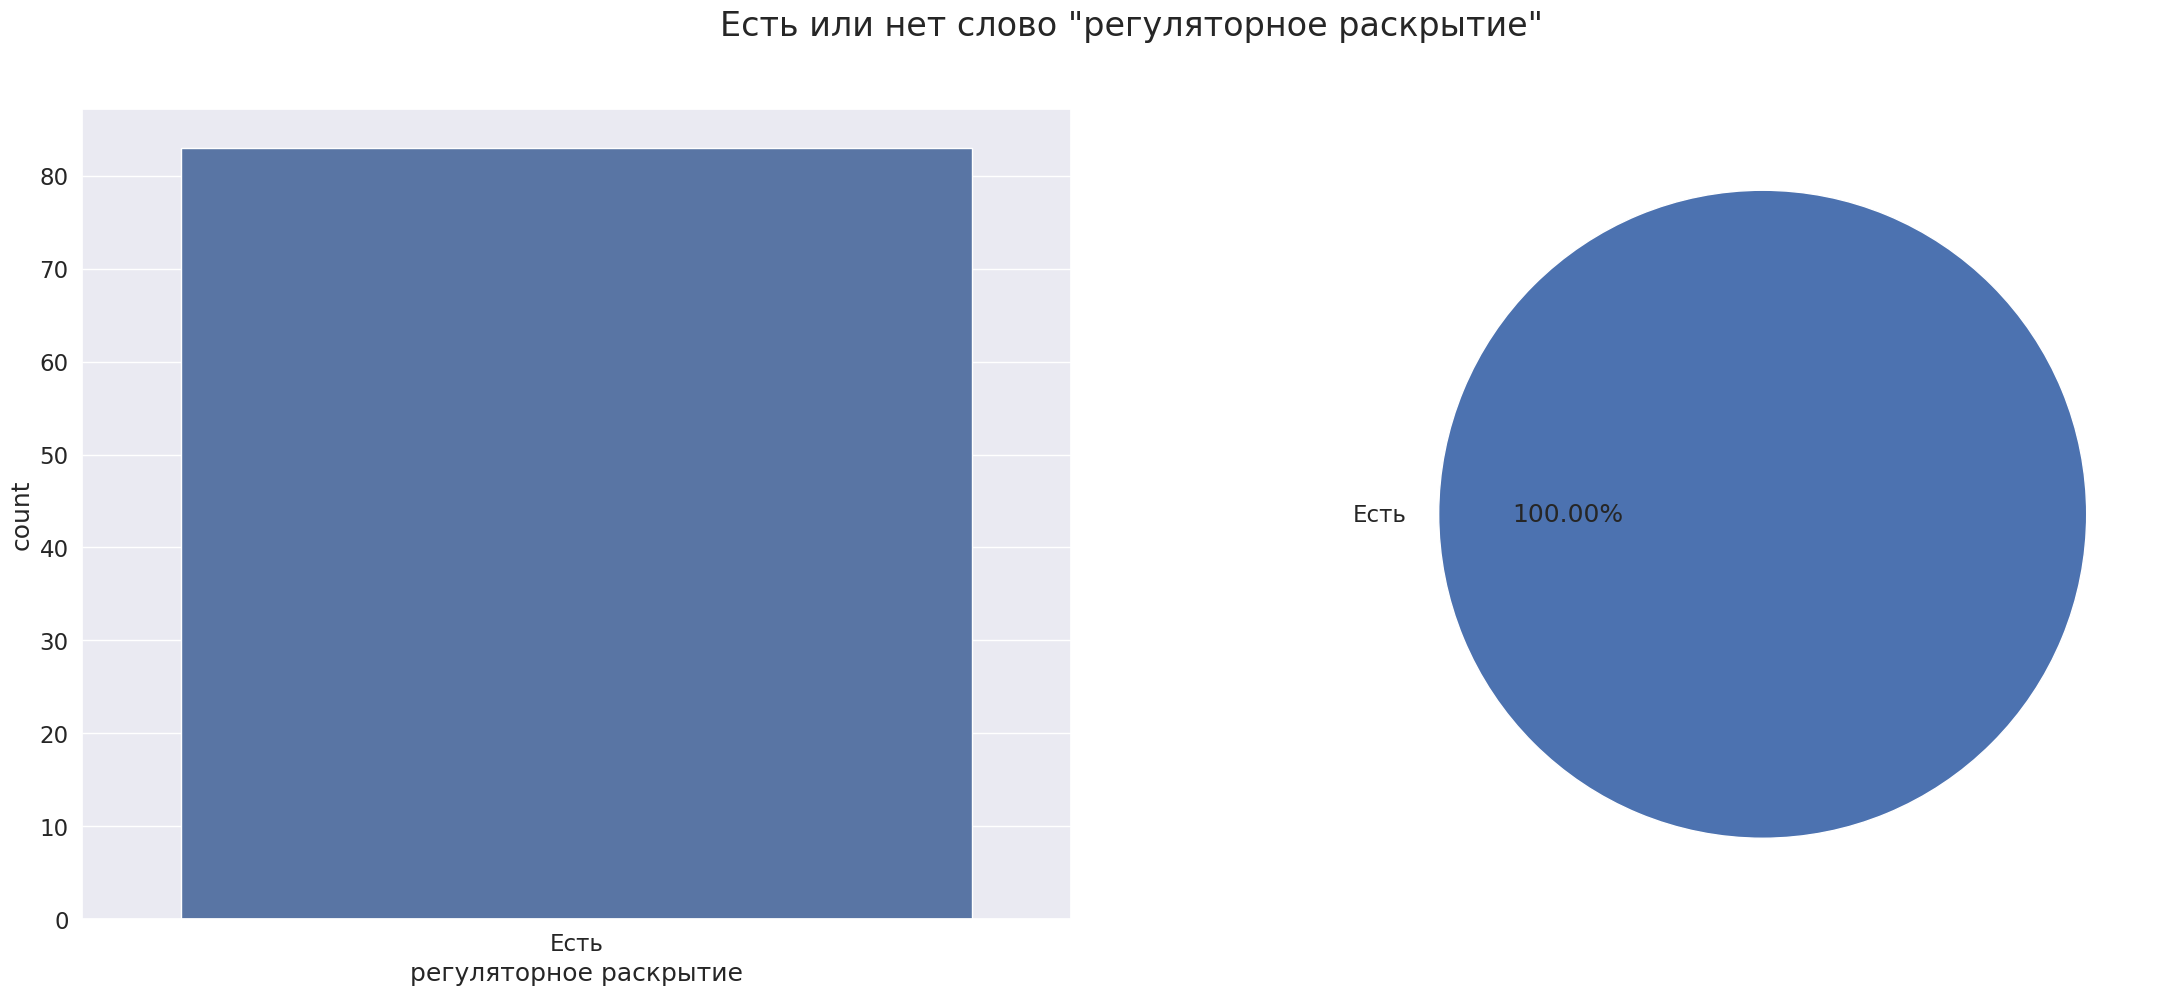

In [402]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 10), dpi=100)
sns.countplot(x=data_nkr[word], ax=axes[0])
axes[1].pie(x=data_nkr[word].value_counts(),
            labels=data_nkr[word].value_counts().index,
            autopct='%1.2f%%',)
            #shadow=True,
            #explode=None,#(0.05, 0)
            #startangle=60)
fig.suptitle(f'Есть или нет слово "{word}"', fontsize=24)
plt.show()

In [404]:
data_nkr_stop = ['Регуляторное раскрытие'.lower()]

In [405]:
data_nkr['text'] = data_nkr['text'].apply(lambda x: search_words_akra(data_nkr_stop, x))

In [406]:
data_nkr['text'][22]

'НКР подтвердило кредитный рейтинг ООО "РГ-Девелопмент" на уровне <rating> со стабильным прогнозом\n29 сентября 2022 года\nСтруктура рейтинга\nСтруктура БОСК\nБОСК1\na-\n\n\nОСК\na-.ru\n\n\nВнешнее влияние\n-\n\n\nКредитный рейтинг\n<rating>\n\n\nПрогноз\nстабильный\n\n\n1 Базовая оценка собственной кредитоспособности\n\n\nРейтинговое агентство НКР подтвердило кредитный рейтинг ООО "РГ-Девелопмент" (далее - "РГ-Девелопмент", "компания") на уровне <rating> со стабильным прогнозом.\nРезюме\n* Положительное влияние на оценку бизнес-профиля компании оказывают высокий спрос и устойчивость рынка жилья комфорт- и бизнес-класса в Московском регионе, на котором работает "РГ-Девелопмент".\n* Давление на оценку бизнес-профиля оказывает высокий уровень концентрации деятельности: в настоящее время компания реализует четыре проекта в Москве.\n* Низкая долговая нагрузка, высокий уровень покрытия краткосрочного долга и процентов по долгу имеющимися денежными средствами и операционной прибылью формирую

In [395]:
data_nkr

Id                                               text category   lvl  \
0      3  НКР повысило кредитный рейтинг ООО "ОТЭКО-Порт...        A     A   
1     13  НКР присвоило ООО "АСПЭК-Домстрой" кредитный р...       BB   BB-   
2     14  НКР подтвердило кредитный рейтинг ООО "Ника-Пе...       BB    BB   
3     21  НКР присвоило ООО "Брусника. Строительство и д...        A    A-   
4     29  НКР присвоило ОАО АФП "Нива" кредитный рейтинг...       BB    BB   
5     30  НКР присвоило ОАО "Родина" кредитный рейтинг <...       BB    BB   
6     37  НКР подтвердило кредитный рейтинг "МаксимаТеле...      BBB  BBB+   
7     49  НКР подтвердило кредитные рейтинги ПАО "МТС" и...      AAA   AAA   
8     54  НКР подтвердило кредитный рейтинг ТМК на уровн...        A    A+   
9     73  НКР присвоило ООО "Т1" кредитный рейтинг <rati...      BBB  BBB+   
10   115  НКР снизило кредитный рейтинг ООО "Завод Криал...        B    B+   
11   116  НКР подтвердило кредитный рейтинг ООО "Патриот...      BBB  BBB-   
12   123  НКР подтвердило кредитный рейтинг "Селигдара" ...        A    A+   
13   148  НКР подтвердило кредитный рейтинг ПАО "Трансне...      AAA   AAA   
14   166  НКР подтвердило кредитный рейтинг ООО "РКС Дев...      BBB  BBB-   
15   183  НКР подтвердило кредитный рейтинг ПАО "ГК "Сам...        A     A   
16   190  НКР установило по кредитному рейтингу ООО "С-И...      BBB   BBB   
17   196  НКР подтвердило кредитный рейтинг ООО «ПИК-Кор...       AA   AA-   
18   197  НКР подтвердило кредитный рейтинг ПАО "ПИК СЗ"...       AA   AA-   
19   204  НКР присвоило ООО "Электроаппарат" кредитный р...       BB   BB-   
20   208  НКР подтвердило кредитный рейтинг АО "ГИДРОМАШ...        A    A-   
21   211  НКР присвоило ООО "ТРОНИТЕК" кредитный рейтинг...       BB   BB-   
22   217  НКР подтвердило кредитный рейтинг ООО "РГ-Деве...        A    A-   
23   225  НКР присвоило ООО "ИВКС" кредитный рейтинг <ra...       BB    BB   
24   226  НКР снизило кредитный рейтинг ООО "Завод Криал...       BB   BB-   
25   235  НКР повысило кредитный рейтинг ДВМП с <rating>...      BBB  BBB+   
26   244  НКР подтвердило кредитный рейтинг "Инграда"\nн...        A    A-   
27   277  НКР присвоило АО АПРИ "Флай Плэнинг" кредитный...       BB   BB-   
28   283  НКР присвоило ООО "Агротек" кредитный рейтинг ...       BB    BB   
29   286  НКР подтвердило кредитный рейтинг "Русской Акв...        A    A-   
30   291  НКР подтвердило прогноз по кредитному рейтингу...      BBB   BBB   
31   295  НКР присвоило АО им. Т. Г. Шевченко кредитный ...       BB   BB+   
32   310  НКР присвоило ООО "Литана" кредитный рейтинг <...        B    B+   
33   328  НКР подтвердило кредитный рейтинг "СГ-транса" ...        A    A+   
34   342  НКР присвоило АО "Аэроклуб" кредитный рейтинг ...       BB   BB+   
35   351  НКР повысило кредитный рейтинг ПАО «Ростелеком...      AAA   AAA   
36   368  НКР подтвердило кредитный рейтинг ООО "Бифорко...      BBB   BBB   
37   375  НКР подтвердило кредитный рейтинг ООО «С-Иннов...      BBB   BBB   
38   387  НКР подтвердило кредитный рейтинг АО "ЭР-Телек...        A    A-   
39   391  НКР присвоило ООО "ОТЭКО-Портсервис" кредитный...        A    A-   
40   392  НКР подтвердило кредитный рейтинг ООО "Амур зо...        A    A+   
41   402  НКР подтвердило прогноз по кредитному рейтингу...        A    A+   
42   405  НКР установило по кредитному рейтингу ООО «С-И...      BBB   BBB   
43   410  НКР подтвердило кредитный рейтинг ООО "Ника-Пе...       BB    BB   
44   426  НКР подтвердило кредитный рейтинг "МаксимаТеле...      BBB  BBB+   
45   443  НКР подтвердило кредитный рейтинг ПАО "МТС" на...      AAA   AAA   
46   446  НКР присвоило ТМК кредитный рейтинг <rating> с...        A    A+   
47   475  НКР установило по кредитному рейтингу АО "СГ-т...        A    A+   
48   503  НКР присвоило ООО "Патриот Групп" кредитный ре...      BBB  BBB-   
49   515  НКР подтвердило кредитный рейтинг "Селигдара" ...        A    A+   
50   536  НКР подтвердило кр

In [407]:
data_nkr.to_csv('nkr.csv')

In [414]:
#Эксперт РА
data_nra = df[df['agent'] == 'НРА'].reset_index(drop=True)

In [411]:
data_nra['text'][2]

'16 января 2023 г. Ведущий рейтинговый аналитик Юрова Алла Младший директор корпоративных рейтингов +7 (495) 122-22-55 (109) yurova@ra-national.ru \xa0 Второй рейтинговый аналитик Станислав Письменный Директор корпоративных рейтингов рейтинговой службы +7 (495) 122-22-55 (125) pismenniy@ra-national.ru \xa0 Дата Рейтингового комитета 13.01.2023 г. \xa0 ПРИСВОЕН КРЕДИТНЫЙ РЕЙТИНГ Общество с ограниченной ответственностью «Национальное Рейтинговое Агентство» (далее – НРА, Агентство) присвоило кредитный рейтинг АО «УК «ОРГ» на уровне «<rating>» по национальной рейтинговой шкале для Российской Федерации, прогноз «Развивающийся». \xa0 ПРОГНОЗ Развивающийся прогноз предполагает пересмотр текущего уровня рейтинга в течение следующих 3 (трех) месяцев. РЕЗЮМЕ Кредитный рейтинг (далее – Рейтинг)АО «УК «ОРГ» (далее — Компания) на уровне «<rating>» обусловлен: (1) комфортным уровнем долговой нагрузки; (2) комфортной оценкой покрытия долга денежным потоком от операционной деятельности; (3) высокой оц

In [412]:
word = 'ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ'.lower()
data_nra[word] = data_nra['text'].apply(lambda x: search_words_count(word, x.lower()))

In [ ]:
r = search_words(word, data_acra['text'][5].lower())

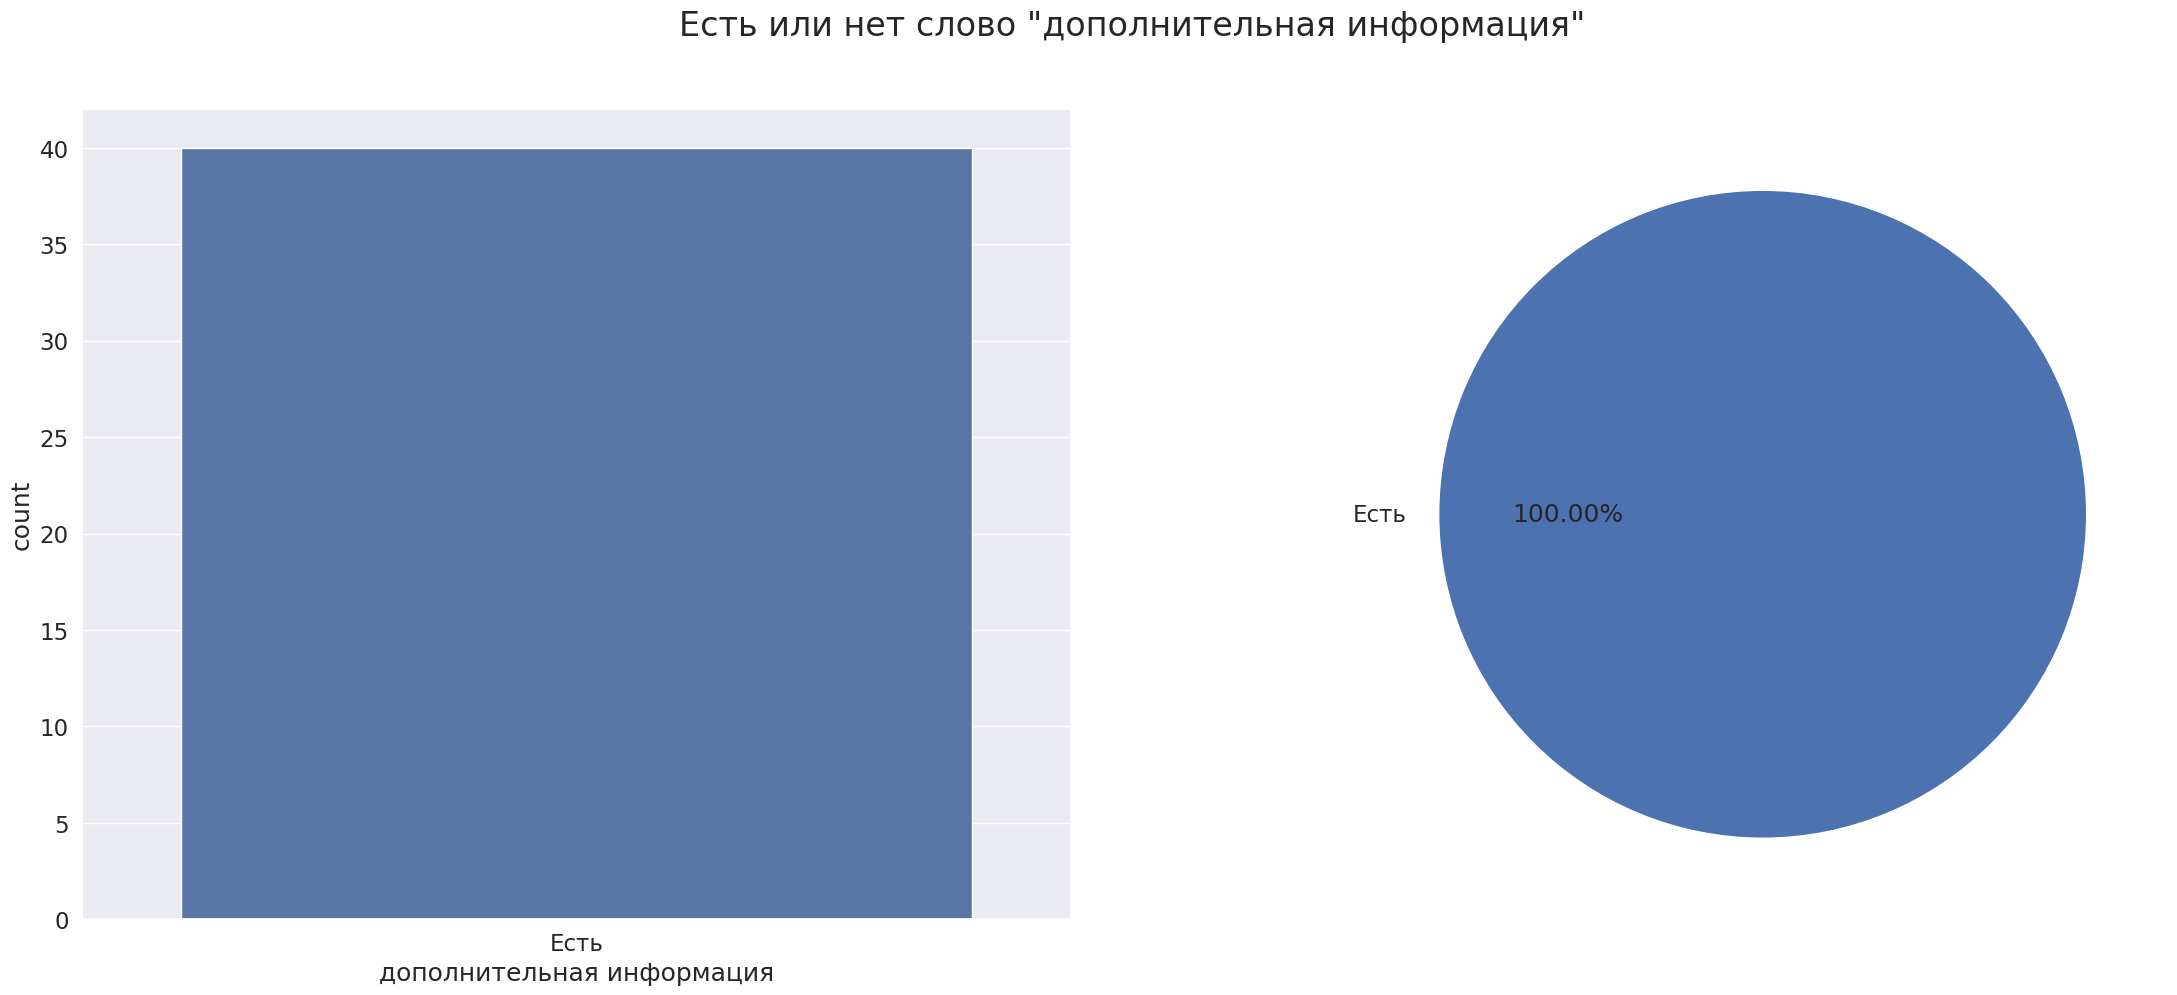

In [413]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 10), dpi=100)
sns.countplot(x=data_nra[word], ax=axes[0])
axes[1].pie(x=data_nra[word].value_counts(),
            labels=data_nra[word].value_counts().index,
            autopct='%1.2f%%',)
            #shadow=True,
            #explode=None,#(0.05, 0)
            #startangle=60)
fig.suptitle(f'Есть или нет слово "{word}"', fontsize=24)
plt.show()

In [415]:
data_nra_stop = ['ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ'.lower()]

In [416]:
data_nra['text'] = data_nra['text'].apply(lambda x: search_words_akra(data_nra_stop, x))

In [417]:
data_nra['text'][22]

'8 ноября 2021 г. Ведущий рейтинговый аналитик Алла Юрова Младший директор корпоративных рейтингов +7 (495) 122-22-55 (109) yurova@ra-national.ru \xa0 Второй рейтинговый аналитик Сергей Гришунин Управляющий директор рейтинговой службы +7 (495) 122-22-55 (126) grishunin@ra-national.ru \xa0 Дата Рейтингового комитета 02.11.2021 г. \xa0 ПРИСВОЕН КРЕДИТНЫЙ РЕЙТИНГ Общество с ограниченной ответственностью «Национальное Рейтинговое Агентство» (далее – НРА, Агентство) присвоило кредитный рейтинг ООО «РЕАТОРГ» на уровне «<rating>» по национальной рейтинговой шкале для Российской Федерации, прогноз по рейтингу «Стабильный». \xa0 ПРОГНОЗ Стабильный прогноз предполагает с высокой долей вероятности сохранение текущего уровня рейтинга в течение следующих 12 (двенадцати) месяцев. \xa0 РЕЗЮМЕ Кредитный рейтинг (далее – Рейтинг) ООО «РЕАТОРГ» (далее – Компания) на уровне «<rating>» обусловлен: (1) продолжительным сроком работы на рынке; (2) низкой зависимостью от поставщиков продукции; (3) простой стр

In [418]:
data_nra

Id                                               text category   lvl  \
0     5  29 марта 2023 г. Ведущий рейтинговый аналитик ...      BBB   BBB   
1    31  14 февраля 2023 г. Ведущий рейтинговый аналити...        B     B   
2    57  16 января 2023 г. Ведущий рейтинговый аналитик...       BB   BB-   
3    86  21 декабря 2022 г. Ведущий рейтинговый аналити...        B    B-   
4   127  29 ноября 2022 г. Ведущий рейтинговый аналитик...       AA   AA-   
5   128  29 ноября 2022 г. Ведущий рейтинговый аналитик...       AA   AA-   
6   167  НРА подтвердило кредитный рейтинг ПАО «ИНГРАД»...      BBB  BBB+   
7   175  24 октября 2022 г. Ведущий рейтинговый аналити...       BB   BB+   
8   188  18 октября 2022 г. Ведущий рейтинговый аналити...       BB   BB+   
9   201  10 октября 2022 г. Ведущий рейтинговый аналити...        A    A-   
10  241  6 сентября 2022 г. Ведущий рейтинговый аналити...       BB   BB-   
11  255  24 августа 2022 г. Ведущий рейтинговый аналити...        B     B   
12  292  21 июля 2022 г. Ведущий рейтинговый аналитик Ю...      BBB   BBB   
13  336  15 июня 2022 г. Ведущий рейтинговый аналитик Ю...      BBB   BBB   
14  347  1 июня 2022 г. Ведущий рейтинговый аналитик Юр...       BB   BB-   
15  393  7 апреля 2022 г. Ведущий рейтинговый аналитик ...      BBB   BBB   
16  411  14 марта 2022 г. Ведущий рейтинговый аналитик ...        B    B-   
17  422  18 февраля 2022 г. Ведущий рейтинговый аналити...        B    B-   
18  452  14 января 2022 г. Ведущий рейтинговый аналитик...      BBB  BBB+   
19  465  28 декабря 2021 г. Ведущий рейтинговый аналити...        B    B-   
20  523  2 декабря 2021 г. Ведущий рейтинговый аналитик...       AA   AA-   
21  524  2 декабря 2021 г. Ведущий рейтинговый аналитик...       AA   AA-   
22  553  8 ноября 2021 г. Ведущий рейтинговый аналитик ...      BBB  BBB-   
23  555  3 ноября 2021 г. Ведущий рейтинговый аналитик ...      BBB  BBB+   
24  567  НРА присвоило кредитный рейтинг ООО «Племзавод...       BB   BB+   
25  582  13 октября 2021 г. Ведущий рейтинговый аналити...        A    A-   
26  602  27 сентября 2021 г. Ведущий рейтинговый аналит...        B     B   
27  627  27августа 2021 г. Ведущий рейтинговый аналитик...        B    B-   
28  648  11 августа 2021 г. Ведущий рейтинговый аналити...        B    B+   
29  662  23 июля 2021 г. Ведущий рейтинговый аналитик Ю...      BBB   BBB   
30  688  28 июня 2021 г. Ведущий рейтинговый аналитик Ю...      BBB   BBB   
31  696  17 июня 2021 г. Ведущий рейтинговый аналитик Ю...        C     C   
32  706  07 июня 2021 г. Ведущий рейтинговый аналитик М...       BB   BB-   
33  721  26 мая 2021 г. Ведущий рейтинговый аналитик Ма...        B    B-   
34  734  НРА пересмотрело прогноз по кредитному рейтинг...       BB    BB   
35  758  НРА присвоило кредитный рейтинг ООО НПО «ХимТэ...      BBB   BBB   
36  791  20 февраля 2021 г. Ведущий рейтинговый аналити...       BB    BB   
37  840  Ведущий рейтинговый аналитик Юрова Алла Аналит...        A    A+   
38  862  30ноября 2020 г. Ведущий рейтинговый аналитик ...        A    A-   
39  865  27ноября 2020 г. Ведущий рейтинговый аналитик ...      BBB  BBB-   

   agent  
0    НРА  
1    НРА  
2    НРА  
3    НРА  
4    НРА  
5    НРА  
6    НРА  
7    НРА  
8    НРА  
9    НРА  
10   НРА  
11   НРА  
12   НРА  
13   НРА  
14   НРА  
15   НРА  
16   НРА  
17   НРА  
18   НРА  
19   НРА  
20   НРА  
21   НРА  
22   НРА  
23   НРА  
24   НРА  
25   НРА  
26   НРА  
27   НРА  
28   НРА  
29   НРА  
30   НРА  
31   НРА  
32   НРА  
33   НРА  
34   НРА  
35   НРА  
36   НРА  
37   НРА  
38   НРА  
39   НРА

In [419]:
data_exc.to_csv('nra.csv')

## check

In [1]:
import pandas as pd

In [2]:
akra = pd.read_csv('AKRA.csv')
akra.head()

Unnamed: 0  Id                                               text category  \
0           0   1  Повышение кредитного рейтинга  Акционерного об...        A   
1           1   6  Кредитный рейтинг  ПАО «ФосАгро» (далее — Комп...      AAA   
2           2  10  Кредитный рейтинг  ООО «МВМ»  (далее — Компани...        A   
3           3  15  Кредитный рейтинг  Акционерного общества «Сина...        A   
4           4  16  Кредитный рейтинг  ПАО «М.видео» (далее — Груп...        A   

   lvl agent  
0    A  АКРА  
1  AAA  АКРА  
2    A  АКРА  
3    A  АКРА  
4    A  АКРА

In [3]:
akra['text'][0]

'Повышение кредитного рейтинга  Акционерного общества «Уральская сталь»  (далее — «Уральская сталь», Компания) вызвано улучшением качественной оценки ликвидности в связи с рефинансированием краткосрочного банковского кредита посредством выпуска облигационного займа с погашением в 2025 году. Также пересмотр стратегических планов по реализации ряда инвестиционных проектов способствовал улучшению показателя «капитальные затраты к выручке». Улучшение ценовой конъюнктуры на мировом рынке чугуна обеспечило запуск доменной печи №3, находившейся ранее в резерве, что окажет дополнительное положительное влияние на денежный поток Компании в 2023 году.   Кредитный рейтинг Компании определяется средними рыночной позицией, бизнес-профилем и уровнем корпоративного управления, а также средней оценкой за размер бизнеса. Показатели рентабельности, ликвидности, долговой нагрузки, обслуживания долга и денежного потока получили высокие оценки.   «Уральская сталь» — один из крупнейших в России производителе

In [ ]:
def search_words_start_end(words, sroka):
    
    for i, w in enumerate(words):
        sroka = sroka.lower()
        res = re.search(w, sroka)
        if res:
            if i == 0:
                sroka = sroka[:res.start()]
            else:
                sroka = sroka[:max(res.start()+600, len(sroka))]
    return sroka


In [7]:
def search_words_count(word, sroka):
    res = re.search(word, sroka)
    if res:
        return 'Есть'
    else:
        return 'Нет'

In [8]:
stop_word_acra = ['КЛЮЧЕВЫЕ ФАКТОРЫ РЕЙТИНГОВОЙ ОЦЕНКИ'.lower(), 'КЛЮЧЕВЫЕ ДОПУЩЕНИЯ'.lower()]

In [ ]:
data_acra['text'] = data_acra['text'].apply(lambda x: search_words_akra(stop_word_acra, x))

In [9]:
word = 'КЛЮЧЕВЫЕ ДОПУЩЕНИЯ'.lower()
akra[word] = akra['text'].apply(lambda x: search_words_count(word, x.lower()))

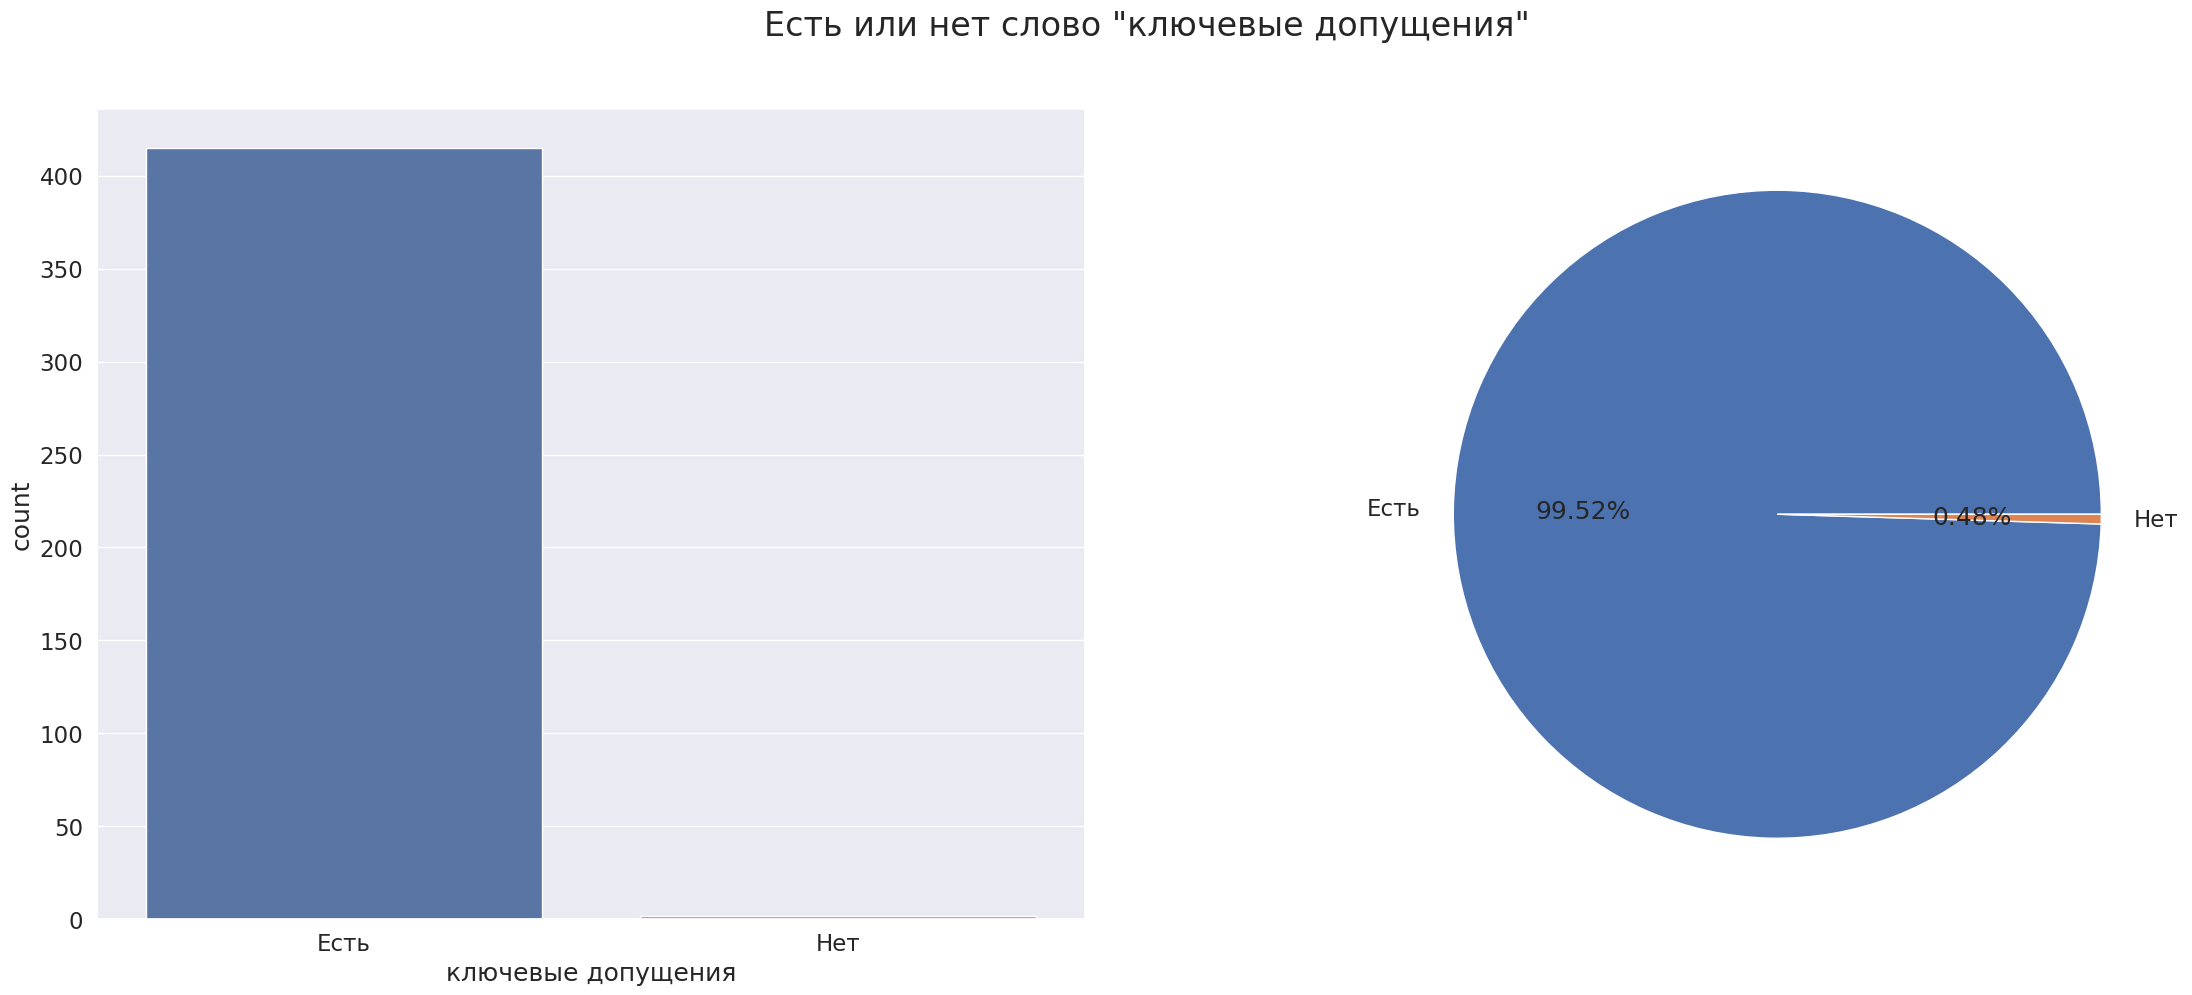

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 10), dpi=100)
sns.countplot(x=akra[word], ax=axes[0])
axes[1].pie(x=akra[word].value_counts(),
            labels=akra[word].value_counts().index,
            autopct='%1.2f%%',)
            #shadow=True,
            #explode=None,#(0.05, 0)
            #startangle=60)
fig.suptitle(f'Есть или нет слово "{word}"', fontsize=24)
plt.show()

In [12]:
akra['text']

0      Повышение кредитного рейтинга  Акционерного об...
1      Кредитный рейтинг  ПАО «ФосАгро» (далее — Комп...
2      Кредитный рейтинг  ООО «МВМ»  (далее — Компани...
3      Кредитный рейтинг  Акционерного общества «Сина...
4      Кредитный рейтинг  ПАО «М.видео» (далее — Груп...
                             ...                        
412    АКРА подтвердило кредитный рейтинг Государстве...
413    АКРА присвоило АО «Загорский трубный завод» кр...
414    АКРА повысило кредитный рейтинг ООО «Т2 РТК Хо...
415    АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...
416    АКРА подтвердило кредитный рейтинг ФГУП «Почта...
Name: text, Length: 417, dtype: object

In [13]:
not_this_group = akra[akra[word] == "Нет" ].reset_index(drop=True)
not_this_group

Unnamed: 0   Id                                               text  \
0          52  136  Присвоение статуса «Рейтинг на пересмотре — не...   
1          65  157  Присвоение статуса «Рейтинг на пересмотре — ра...   

  category   lvl agent ключевые допущения  
0      BBB  BBB-  АКРА                Нет  
1       AA   AA-  АКРА                Нет

In [14]:
not_this_group['text'][0]

'Присвоение статуса «Рейтинг на пересмотре — негативный» по кредитным рейтингам  АО «Коммерческая недвижимость ФПК «Гарант-Инвест»  (далее — Компания, Гарант-Инвест) и его облигаций связано с неопределенностью относительно будущих оценок факторов финансового риск-профиля Компании, в том числе вследствие наличия у нее планов по реализации нового проекта на фоне ожидаемых АКРА более слабых финансовых результатов 2022 года по сравнению с изначальным прогнозом Агентства. АКРА планирует в краткосрочной перспективе пересмотреть кредитный рейтинг Компании и прогноз по нему с учетом ее фактических результатов за 2022 год, что может привести к изменению кредитных рейтингов Гарант-Инвеста и выпусков его облигаций и обуславливает присвоение статуса «Рейтинг на пересмотре — негативный».   Текущий уровень кредитного рейтинга Компании — <rating> — обусловлен высоким отраслевым риском, малым размером бизнеса (чистый операционный доход составлял менее 5 млрд руб.), высокой долговой нагрузкой при низко

In [15]:
not_this_group['text'][1]

'Присвоение статуса «Рейтинг на пересмотре — развивающийся» по кредитному рейтингу  ПАО «ВымпелКом» (далее — «ВымпелКом», Компания) связано с заявлением со стороны его материнской структуры — VEON Holdings B.V. — о ее планах продажи российского сегмента бизнеса.   Текущий уровень кредитного рейтинга Компании — <rating> — был обусловлен сильным операционным риск-профилем. АКРА учитывало высокую вероятность экстраординарной поддержки со стороны материнской структуры — VEON Holdings B.V. — в части доступа к источникам ликвидности группы. На текущий момент «ВымпелКом» является ключевым активом группы VEON, по ряду обязательств установлено условие кросс-дефолта.   Финансовый риск-профиль «ВымпелКома» был оценен на среднем уровне, что во многом обусловлено увеличением долговой нагрузки до среднего уровня в 2021–2022 годах из-за роста арендной составляющей скорректированного долга вследствие продажи башенной инфраструктуры. Агентство отмечало высокую рентабельность и очень крупный размер бизн

In [16]:
excpert = pd.read_csv('excpert.csv')
excpert.head()

Unnamed: 0  Id                                               text category  \
0           0   2  «Эксперт РА» подтвердил кредитный рейтинг комп...       BB   
1           1   4  «Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...      AAA   
2           2   7  «Эксперт РА» повысил кредитный рейтинг ОАО «МР...       AA   
3           3   8  «Эксперт РА» понизил кредитный рейтинг ПАО «М....        A   
4           4   9  «Эксперт РА» повысил кредитный рейтинг компани...       BB   

   lvl       agent  
0   BB  Эксперт РА  
1  AAA  Эксперт РА  
2  AA+  Эксперт РА  
3    A  Эксперт РА  
4  BB+  Эксперт РА

In [17]:
excpert['text'][0]

'«Эксперт РА» подтвердил кредитный рейтинг компании ООО «Энергоконцепции» на уровне <rating>  Москва, 31 марта  2023 г.  Рейтинговое агентство «Эксперт РА» подтвердило  рейтинг кредитоспособности  нефинансовой компании   ООО «Энергоконцепции»   на уровне <rating>. Прогноз по рейтингу – стабильный. ") ООО «Энергоконцепции» (далее – «компания») –  российская компания, занимающаяся поставкой, монтажом и обслуживанием  энергетического оборудования. Основные клиенты представлены производителями  тепловой и электрической энергии группы компаний ООО «Газпром энергохолдинг»  (<rating>, стаб.).   Агентство оценивает риск-профиль отрасли, в  которой компания ведет деятельность, нейтрально. Платежеспособность основных  клиентов компании находится на высоком уровне. Устойчивость к внешним шокам  оценивается агентством на среднем уровне, т.к. спрос на продукцию и услуги ООО  «Энергоконцепции» подвержен колебаниям экономических циклов. Барьеры для входа  находятся на умеренно низком уровне.   Рыночн

In [ ]:
stop_word_acra = ['КЛЮЧЕВЫЕ ФАКТОРЫ РЕЙТИНГОВОЙ ОЦЕНКИ'.lower(), 'КЛЮЧЕВЫЕ ДОПУЩЕНИЯ'.lower()]

In [ ]:
data_acra['text'] = data_acra['text'].apply(lambda x: search_words_akra(stop_word_acra, x))

In [18]:
word = 'КЛЮЧЕВЫЕ ДОПУЩЕНИЯ'.lower()
excpert[word] = excpert['text'].apply(lambda x: search_words_count(word, x.lower()))

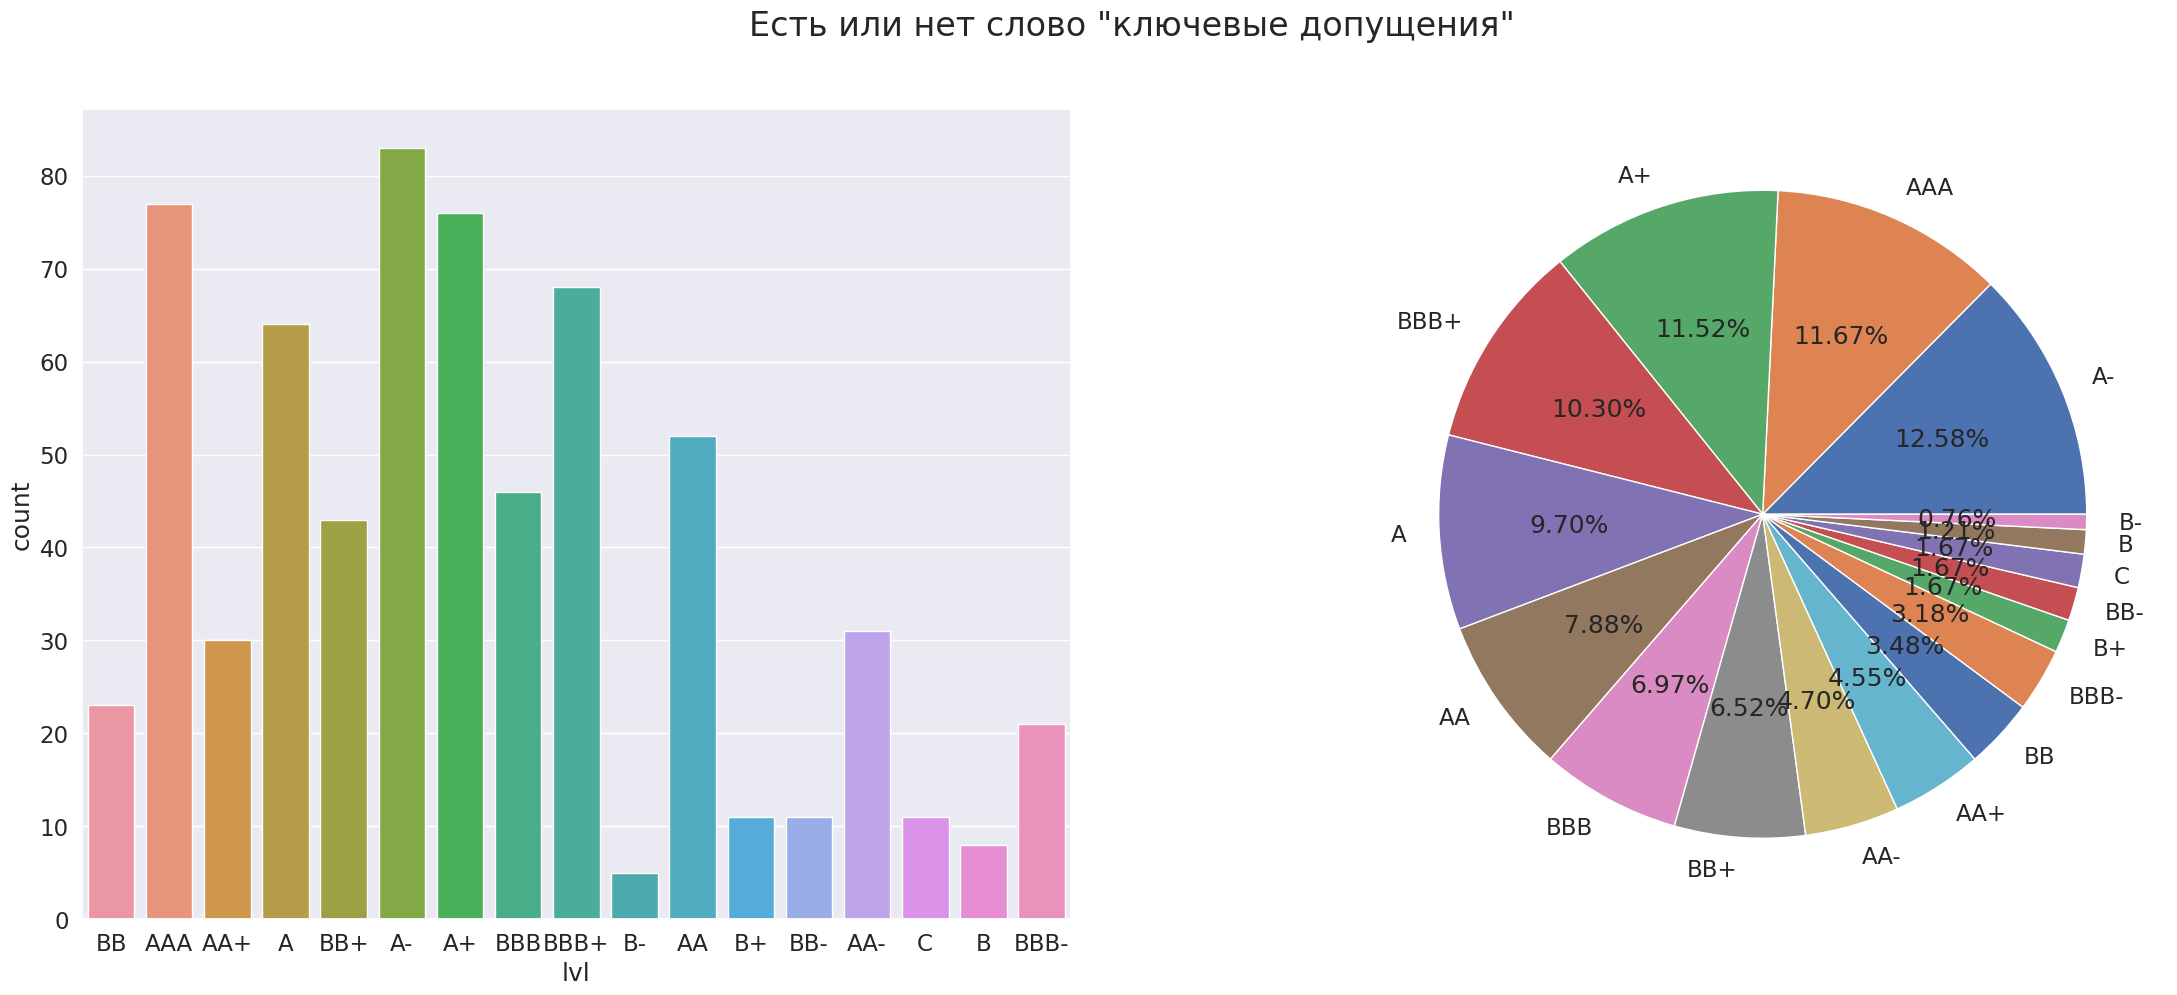

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 10), dpi=100)
sns.countplot(x=excpert['lvl'], ax=axes[0])
axes[1].pie(x=excpert['lvl'].value_counts(),
            labels=excpert['lvl'].value_counts().index,
            autopct='%1.2f%%',)
            #shadow=True,
            #explode=None,#(0.05, 0)
            #startangle=60)
fig.suptitle(f'Есть или нет слово "{word}"', fontsize=24)
plt.show()

In [25]:
reyt = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B' ,'C']

In [26]:
all_reyt = []
adds = ['+', "", "-"]
for i in reyt:
    if i!='C' and i!='AAA':
        for j in adds:
            all_reyt.append(i+j)
    else:
        all_reyt.append(i)
all_reyt

['AAA',
 'AA+',
 'AA',
 'AA-',
 'A+',
 'A',
 'A-',
 'BBB+',
 'BBB',
 'BBB-',
 'BB+',
 'BB',
 'BB-',
 'B+',
 'B',
 'B-',
 'C']

In [27]:
all_reyt_dict = {all_reyt[-i]: i-1 for i in range(1, len(all_reyt)+1)}
all_reyt_dict

{'C': 0,
 'B-': 1,
 'B': 2,
 'B+': 3,
 'BB-': 4,
 'BB': 5,
 'BB+': 6,
 'BBB-': 7,
 'BBB': 8,
 'BBB+': 9,
 'A-': 10,
 'A': 11,
 'A+': 12,
 'AA-': 13,
 'AA': 14,
 'AA+': 15,
 'AAA': 16}

In [29]:
excpert['lvl'].value_counts() < 30

A-      False
AAA     False
A+      False
BBB+    False
A       False
AA      False
BBB     False
BB+     False
AA-     False
AA+     False
BB       True
BBB-     True
B+       True
BB-      True
C        True
B        True
B-       True
Name: lvl, dtype: bool

In [34]:
list(excpert['lvl'].value_counts()[excpert['lvl'].value_counts() < 30].index)

['BB', 'BBB-', 'B+', 'BB-', 'C', 'B', 'B-']

In [37]:
akra['text']

0      Повышение кредитного рейтинга  Акционерного об...
1      Кредитный рейтинг  ПАО «ФосАгро» (далее — Комп...
2      Кредитный рейтинг  ООО «МВМ»  (далее — Компани...
3      Кредитный рейтинг  Акционерного общества «Сина...
4      Кредитный рейтинг  ПАО «М.видео» (далее — Груп...
                             ...                        
412    АКРА подтвердило кредитный рейтинг Государстве...
413    АКРА присвоило АО «Загорский трубный завод» кр...
414    АКРА повысило кредитный рейтинг ООО «Т2 РТК Хо...
415    АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...
416    АКРА подтвердило кредитный рейтинг ФГУП «Почта...
Name: text, Length: 417, dtype: object

In [ ]:
not_this_group = akra[akra[word] == "Нет" ].reset_index(drop=True)
not_this_group

Unnamed: 0   Id                                               text  \
0          52  136  Присвоение статуса «Рейтинг на пересмотре — не...   
1          65  157  Присвоение статуса «Рейтинг на пересмотре — ра...   

  category   lvl agent ключевые допущения  
0      BBB  BBB-  АКРА                Нет  
1       AA   AA-  АКРА                Нет

In [ ]:
not_this_group['text'][0]

'Присвоение статуса «Рейтинг на пересмотре — негативный» по кредитным рейтингам  АО «Коммерческая недвижимость ФПК «Гарант-Инвест»  (далее — Компания, Гарант-Инвест) и его облигаций связано с неопределенностью относительно будущих оценок факторов финансового риск-профиля Компании, в том числе вследствие наличия у нее планов по реализации нового проекта на фоне ожидаемых АКРА более слабых финансовых результатов 2022 года по сравнению с изначальным прогнозом Агентства. АКРА планирует в краткосрочной перспективе пересмотреть кредитный рейтинг Компании и прогноз по нему с учетом ее фактических результатов за 2022 год, что может привести к изменению кредитных рейтингов Гарант-Инвеста и выпусков его облигаций и обуславливает присвоение статуса «Рейтинг на пересмотре — негативный».   Текущий уровень кредитного рейтинга Компании — <rating> — обусловлен высоким отраслевым риском, малым размером бизнеса (чистый операционный доход составлял менее 5 млрд руб.), высокой долговой нагрузкой при низко

In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [42]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,2), stop_words=stop)

In [38]:
akra['text_clean'] = akra['text'].replace(r'\(.*?\)\ *','',regex=True)
akra['text_clean'] = akra['text'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()

In [43]:
features = tfidf.fit_transform(akra.text_clean).toarray()
labels = akra.lvl
features.shape

(417, 13456)

In [60]:
len(all_reyt_dict)

17

In [44]:
N = 2
for sign, sign_id in sorted(all_reyt_dict.items()):
    features_chi2 = chi2(features, labels == sign_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
    bigrams = [v for v in feature_names if len(v.split(" ")) == 2]
    print("n--> %s:" %(sign))
    print("  * Most Correlated Unigrams are: %s" %(", ".join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(", ".join(bigrams[-N:])))

n--> A:
  * Most Correlated Unigrams are: компенсацию, января
  * Most Correlated Bigrams are: компании увеличилась, компании составила
n--> A+:
  * Most Correlated Unigrams are: компенсацию, января
  * Most Correlated Bigrams are: компании увеличилась, компании составила
n--> A-:
  * Most Correlated Unigrams are: компенсацию, января
  * Most Correlated Bigrams are: компании увеличилась, компании составила
n--> AA:
  * Most Correlated Unigrams are: компенсацию, января
  * Most Correlated Bigrams are: компании увеличилась, компании составила
n--> AA+:
  * Most Correlated Unigrams are: компенсацию, января
  * Most Correlated Bigrams are: компании увеличилась, компании составила
n--> AA-:
  * Most Correlated Unigrams are: компенсацию, января
  * Most Correlated Bigrams are: компании увеличилась, компании составила
n--> AAA:
  * Most Correlated Unigrams are: компенсацию, января
  * Most Correlated Bigrams are: компании увеличилась, компании составила
n--> B:
  * Most Correlated Unigrams ar

In [45]:
akra

Unnamed: 0    Id                                               text  \
0             0     1  Повышение кредитного рейтинга  Акционерного об...   
1             1     6  Кредитный рейтинг  ПАО «ФосАгро» (далее — Комп...   
2             2    10  Кредитный рейтинг  ООО «МВМ»  (далее — Компани...   
3             3    15  Кредитный рейтинг  Акционерного общества «Сина...   
4             4    16  Кредитный рейтинг  ПАО «М.видео» (далее — Груп...   
..          ...   ...                                                ...   
412         412  1194  АКРА подтвердило кредитный рейтинг Государстве...   
413         413  1197  АКРА присвоило АО «Загорский трубный завод» кр...   
414         414  1200  АКРА повысило кредитный рейтинг ООО «Т2 РТК Хо...   
415         415  1209  АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...   
416         416  1210  АКРА подтвердило кредитный рейтинг ФГУП «Почта...   

    category   lvl agent ключевые допущения  \
0          A     A  АКРА               Есть   
1        AAA   AAA  АКРА               Есть   
2          A     A  АКРА               Есть   
3          A     A  АКРА               Есть   
4          A     A  АКРА               Есть   
..       ...   ...   ...                ...   
412       AA    AA  АКРА               Есть   
413      BBB  BBB+  АКРА               Есть   
414        A     A  АКРА               Есть   
415        A    A+  АКРА               Есть   
416      AAA   AAA  АКРА               Есть   

                                            text_clean  
0    повышение кредитного рейтинга акционерного общ...  
1    кредитный рейтинг пао фосагро далее компания ф...  
2    кредитный рейтинг ооо мвм далее компания мвм о...  
3    кредитный рейтинг акционерного общества синара...  
4    кредитный рейтинг пао м видео далее группа м в...  
..                                                 ...  
412  акра подтвердило кредитный рейтинг государстве...  
413  акра присвоило ао загорский трубный завод кред...  
414  акра повысило кредитный рейтинг ооо т2 ртк хол...  
415  акра подтвердило пао камаз кредитный рейтинг r...  
416  акра подтвердило кредитный рейтинг фгуп почта ...  

[417 rows x 8 columns]

In [46]:
akra['lvl_label'] = akra["lvl"].apply(lambda x: all_reyt_dict[x])

In [47]:
akra

Unnamed: 0    Id                                               text  \
0             0     1  Повышение кредитного рейтинга  Акционерного об...   
1             1     6  Кредитный рейтинг  ПАО «ФосАгро» (далее — Комп...   
2             2    10  Кредитный рейтинг  ООО «МВМ»  (далее — Компани...   
3             3    15  Кредитный рейтинг  Акционерного общества «Сина...   
4             4    16  Кредитный рейтинг  ПАО «М.видео» (далее — Груп...   
..          ...   ...                                                ...   
412         412  1194  АКРА подтвердило кредитный рейтинг Государстве...   
413         413  1197  АКРА присвоило АО «Загорский трубный завод» кр...   
414         414  1200  АКРА повысило кредитный рейтинг ООО «Т2 РТК Хо...   
415         415  1209  АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...   
416         416  1210  АКРА подтвердило кредитный рейтинг ФГУП «Почта...   

    category   lvl agent ключевые допущения  \
0          A     A  АКРА               Есть   
1        AAA   AAA  АКРА               Есть   
2          A     A  АКРА               Есть   
3          A     A  АКРА               Есть   
4          A     A  АКРА               Есть   
..       ...   ...   ...                ...   
412       AA    AA  АКРА               Есть   
413      BBB  BBB+  АКРА               Есть   
414        A     A  АКРА               Есть   
415        A    A+  АКРА               Есть   
416      AAA   AAA  АКРА               Есть   

                                            text_clean  lvl_label  
0    повышение кредитного рейтинга акционерного общ...         11  
1    кредитный рейтинг пао фосагро далее компания ф...         16  
2    кредитный рейтинг ооо мвм далее компания мвм о...         11  
3    кредитный рейтинг акционерного общества синара...         11  
4    кредитный рейтинг пао м видео далее группа м в...         11  
..                                                 ...        ...  
412  акра подтвердило кредитный рейтинг государстве...         14  
413  акра присвоило ао загорский трубный завод кред...          9  
414  акра повысило кредитный рейтинг ооо т2 ртк хол...         11  
415  акра подтвердило пао камаз кредитный рейтинг r...         12  
416  акра подтвердило кредитный рейтинг фгуп почта ...         16  

[417 rows x 9 columns]

In [48]:
X = akra["text_clean"] # Collection of blogs
y = akra["lvl_label"] # Target or the labels we want to predict (i.e. the 12 different zodiac signs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [50]:
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
]
# Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:   
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring="precision_macro", cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "precision_macro"])

In [52]:
mean_accuracy = cv_df.groupby("model_name").precision_macro.mean()
std_accuracy = cv_df.groupby("model_name").precision_macro.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1, ignore_index=True)
acc.columns = ["Mean precision_macro", "Standard deviation"]
acc

Mean precision_macro  Standard deviation
model_name                                                      
LinearSVC                           0.655864            0.123024
LogisticRegression                  0.411554            0.070725
MultinomialNB                       0.276689            0.068809
RandomForestClassifier              0.662636            0.131974

In [54]:
from sklearn.metrics import f1_score

In [56]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, akra.index, test_size=0.25, random_state=42)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))

0.602928496842524


In [62]:
[i for i in range(len(all_reyt_dict))]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [63]:
print(metrics.classification_report(y_test, y_pred, labels=[i for i in range(len(all_reyt_dict))], target_names= akra["lvl"].unique()))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         0
         AAA       0.00      0.00      0.00         0
          A-       0.00      0.00      0.00         0
         AA+       0.00      0.00      0.00         0
         AA-       0.00      0.00      0.00         0
          A+       0.00      0.00      0.00         0
        BBB-       0.00      0.00      0.00         0
         BBB       0.00      0.00      0.00         0
        BBB+       0.00      0.00      0.00         0
          BB       0.00      0.00      0.00         0
         BB+       0.00      0.00      0.00         0
          AA       0.00      0.00      0.00         0
         BB-       0.00      0.00      0.00         0
          B+       0.00      0.00      0.00         0
           B       0.00      0.00      0.00         0
          B-       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00   